In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
    
    
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1 + residual_2 + residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
eigenvector_solution_df.columns = ['state_0', 'state_1', 'state_2']

N_u = 1
N_f = 10000

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([60000.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f = lb + (ub - lb) * lhs(1, N_f*2) #生成N_f个随机点
    indices = np.arange(X_f.shape[0])
    id = np.random.choice(indices, N_f_1, replace=False) #从indices中随机选择10个数，replace=False表示不允许重复选择，最后将这10个数赋值给id，代表训练过的数据索引
    X_f_train = X_f[id, :] #从X_f_train中选取id对应的的10行，赋值给X_f_train


    nIter = 80000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)

    #删除已经训练过的数据的索引
    indices = np.setdiff1d(indices, id) #从indices中去除id中的元素，最后将结果赋值给indices

    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 #重新采样500个点
        # 生成新的X_f_train数据
        id = np.random.choice(indices, N_f_new, replace=False) #从indices中随机选择N_f_new个数，replace=False表示不允许重复选择，最后将这N_f_new个数赋值给id，代表训练过的数据索引

        X_f_train_new = X_f[id, :] #从X_f_train中选取id对应的的N_f_new行，赋值给X_f_train_new

        X_f_train = np.vstack((X_f_train, X_f_train_new)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

        # 删除已经训练过的数据的索引
        indices = np.setdiff1d(indices, id)


    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    up = 80000
    n_star = 5000+1
    x_star = np.linspace(lb, up, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 50)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.98it/s]

Adam:  11%|█         | 87/800 [00:00<00:01, 481.97it/s]

Adam:  20%|██        | 160/800 [00:00<00:01, 594.28it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 646.71it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 681.55it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 702.07it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 712.61it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 727.06it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 701.66it/s]

Adam:  85%|████████▍ | 678/800 [00:01<00:00, 700.63it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 715.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 676.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.58it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.23it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 690.66it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 687.51it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 706.49it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 705.99it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 721.33it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 735.14it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 744.79it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 749.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.08it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 755.86it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 756.58it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 755.72it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 745.30it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 741.93it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 740.46it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 743.84it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 746.21it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 759.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 715.38it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 761.04it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 776.62it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 767.16it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 773.87it/s]

Adam:  58%|█████▊    | 467/800 [00:00<00:00, 765.11it/s]

Adam:  68%|██████▊   | 546/800 [00:00<00:00, 771.19it/s]

Adam:  78%|███████▊  | 624/800 [00:00<00:00, 765.66it/s]

Adam:  88%|████████▊ | 701/800 [00:00<00:00, 765.88it/s]

Adam:  97%|█████████▋| 778/800 [00:01<00:00, 762.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 764.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.00it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.90it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 760.96it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 757.41it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 761.78it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 760.89it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 761.71it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 754.48it/s]

Adam:  86%|████████▋ | 691/800 [00:00<00:00, 759.00it/s]

Adam:  96%|█████████▌| 767/800 [00:01<00:00, 750.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 756.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.62it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 750.46it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 758.36it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 759.81it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 764.07it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 751.12it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 747.99it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 754.39it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 757.59it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 761.37it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 769.40it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 708.11it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 720.42it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 700.81it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 713.75it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 703.96it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 691.66it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 713.70it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 729.30it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 739.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.72it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 763.33it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 738.29it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 748.62it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 729.06it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 741.74it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 749.22it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 752.49it/s]

Adam:  86%|████████▋ | 690/800 [00:00<00:00, 756.76it/s]

Adam:  96%|█████████▌| 767/800 [00:01<00:00, 760.25it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.17it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 761.24it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 749.76it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 751.15it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 749.96it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 752.47it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 748.22it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 741.89it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 722.83it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 731.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.33it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 759.77it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 759.61it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 707.22it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 715.45it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 719.73it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 731.95it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 740.09it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 746.36it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 750.07it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.94it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 692.85it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 707.91it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 722.56it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 730.62it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 728.17it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 733.51it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 743.35it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 749.06it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 752.34it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.36it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.58it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 756.65it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 758.80it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 758.23it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 745.42it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 750.64it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 754.01it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 746.40it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 747.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.06it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 747.03it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 739.45it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 730.15it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 740.37it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 748.34it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 745.73it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 749.33it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 736.35it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 745.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.53it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 746.15it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 746.61it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 747.82it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 748.60it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 743.70it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 725.53it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 732.36it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 733.45it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 714.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.12it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 738.47it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 736.12it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 735.90it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 736.89it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 741.30it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 745.48it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 744.57it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 739.81it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 731.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.01it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.46it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 745.97it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 742.10it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 724.73it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 733.88it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 735.79it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 743.85it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 744.14it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 748.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 730.81it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.79it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 744.74it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 719.84it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 728.78it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 686.11it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 705.30it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 717.68it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 727.78it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 736.67it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.51it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.41it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 745.70it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 745.20it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 746.32it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 739.50it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 740.40it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 730.12it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 690.49it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 700.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.40it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 720.96it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 730.18it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 700.78it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 702.38it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 715.57it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 729.47it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 736.73it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 729.10it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 737.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.43it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 757.47it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 691.97it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 714.54it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 707.69it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 685.46it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 685.56it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 694.56it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 710.41it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 724.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 706.45it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:01, 641.35it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 656.63it/s]

Adam:  35%|███▌      | 282/800 [00:00<00:00, 674.73it/s]

Adam:  44%|████▍     | 351/800 [00:00<00:00, 677.67it/s]

Adam:  53%|█████▎    | 425/800 [00:00<00:00, 696.11it/s]

Adam:  63%|██████▎   | 501/800 [00:00<00:00, 715.10it/s]

Adam:  72%|███████▏  | 576/800 [00:00<00:00, 725.35it/s]

Adam:  82%|████████▏ | 652/800 [00:00<00:00, 733.79it/s]

Adam:  91%|█████████ | 729/800 [00:01<00:00, 743.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.31it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 753.99it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 757.23it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 757.76it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 734.37it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 724.66it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 730.79it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 737.64it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 745.44it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 739.36it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 706.46it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 725.91it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 740.55it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 745.13it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 749.98it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 752.41it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 744.26it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 686.68it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 702.91it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 698.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 735.14it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 747.56it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 730.53it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 740.29it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 722.98it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 698.58it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 699.25it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 717.77it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 728.21it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 736.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.95it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 715.48it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 731.54it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 717.13it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 726.58it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 729.96it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 737.76it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 713.25it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 725.88it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 717.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 689.96it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:01, 615.88it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 675.49it/s]

Adam:  35%|███▌      | 283/800 [00:00<00:00, 661.87it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 682.44it/s]

Adam:  53%|█████▎    | 425/800 [00:00<00:00, 678.24it/s]

Adam:  62%|██████▏   | 499/800 [00:00<00:00, 695.94it/s]

Adam:  72%|███████▏  | 574/800 [00:00<00:00, 710.87it/s]

Adam:  81%|████████  | 649/800 [00:00<00:00, 722.87it/s]

Adam:  91%|█████████ | 725/800 [00:01<00:00, 732.23it/s]

Adam: 100%|█████████▉| 799/800 [00:01<00:00, 720.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 699.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.46it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 723.16it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 735.13it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 740.71it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 705.37it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 721.25it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 731.17it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 736.21it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 739.31it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 740.37it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.98it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 717.11it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 730.05it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 737.37it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 740.29it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 742.40it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 732.07it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 733.51it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 736.21it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 723.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 688.16it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 694.61it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 716.37it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 712.16it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 723.01it/s]

Adam:  54%|█████▍    | 434/800 [00:00<00:00, 716.95it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 726.66it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 721.89it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 718.29it/s]

Adam:  91%|█████████ | 728/800 [00:01<00:00, 719.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.83it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 737.45it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 685.10it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 689.66it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 678.11it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 697.75it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 693.72it/s]

Adam:  72%|███████▏  | 578/800 [00:00<00:00, 687.14it/s]

Adam:  81%|████████  | 647/800 [00:00<00:00, 686.73it/s]

Adam:  90%|████████▉ | 716/800 [00:01<00:00, 687.67it/s]

Adam:  98%|█████████▊| 785/800 [00:01<00:00, 680.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 689.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 659.10it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 708.80it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 721.55it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 717.84it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 730.04it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 732.28it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 739.39it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 744.03it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 746.05it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 751.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.96it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 741.79it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 725.14it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 735.93it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 730.41it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 737.00it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 740.74it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 743.40it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 726.01it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 728.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.54it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 717.29it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 736.52it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 737.20it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 712.53it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 717.16it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 731.29it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 737.28it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 742.65it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 743.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.68it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 744.59it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 731.53it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 728.84it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 737.58it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 719.20it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 726.64it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 732.46it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 737.46it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 742.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.89it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 718.70it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 731.92it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 711.91it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 721.26it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 697.91it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 700.13it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 701.61it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 701.21it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 714.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.18it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 748.49it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 742.31it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 725.00it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 730.83it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 719.18it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 728.50it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 731.44it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 731.50it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 737.02it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.61it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 744.47it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.81it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 749.18it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 743.84it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 744.85it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 746.76it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 744.81it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 719.97it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 724.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 721.52it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 727.29it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 736.07it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 737.06it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 714.70it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 725.70it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 733.08it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 738.50it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 728.26it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 730.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.28it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 739.65it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 743.13it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 726.96it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 734.47it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 739.24it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 742.80it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 742.71it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 730.70it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 731.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 738.53it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.38it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 745.44it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 747.32it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 739.43it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 742.58it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 720.98it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 728.97it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 706.00it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 707.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.34it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 739.87it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 735.01it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 727.05it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 731.00it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 715.48it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 725.33it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 726.01it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 717.43it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 722.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 658.55it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 705.07it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 725.36it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 732.27it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 726.27it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 718.71it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 725.39it/s]

Adam:  73%|███████▎  | 584/800 [00:00<00:00, 714.62it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 717.60it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 720.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.09it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 681.02it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 705.19it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 715.49it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 725.66it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 722.76it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 724.44it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 712.40it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 707.84it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 704.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.51it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 745.30it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 743.62it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 720.14it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 725.06it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 728.49it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 733.33it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 702.41it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 712.98it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 723.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.59it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 738.14it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 737.28it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 740.60it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 742.02it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 745.00it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 735.10it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 738.86it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 739.73it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 743.14it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 715.39it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 725.11it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 732.45it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 682.09it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 677.01it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 685.03it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 698.41it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 714.34it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 698.60it/s]

Adam:  91%|█████████ | 729/800 [00:01<00:00, 710.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.51it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 752.55it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 680.28it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 705.36it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 712.30it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 722.35it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 728.36it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 732.94it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 739.71it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 740.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 65/800 [00:00<00:01, 643.68it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 706.37it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 698.48it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 717.19it/s]

Adam:  45%|████▍     | 359/800 [00:00<00:00, 714.67it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 727.33it/s]

Adam:  64%|██████▍   | 510/800 [00:00<00:00, 734.03it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 741.22it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 744.25it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 747.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.38it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 744.70it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 747.48it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 746.05it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 746.18it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 747.12it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 739.08it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 730.06it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 716.22it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 726.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.31it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 735.54it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 732.60it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 739.04it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 742.40it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 745.54it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 738.22it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 737.95it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 740.87it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 743.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 714.47it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 734.78it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 740.96it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 745.03it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 746.04it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 741.35it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 734.58it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 738.61it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 742.49it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 744.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.93it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 736.03it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 741.48it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 744.98it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 745.94it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 746.94it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 746.59it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 746.21it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 742.80it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 743.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.36it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 748.31it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 748.81it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 750.17it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 724.94it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 733.59it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 721.78it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 732.37it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 730.46it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 703.54it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 722.33it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 719.08it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 733.97it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 724.02it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 732.37it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 735.70it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 738.35it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 709.15it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 719.91it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 726.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 674.97it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 693.81it/s]

Adam:  26%|██▌       | 209/800 [00:00<00:00, 677.24it/s]

Adam:  35%|███▌      | 282/800 [00:00<00:00, 694.85it/s]

Adam:  44%|████▍     | 354/800 [00:00<00:00, 700.89it/s]

Adam:  53%|█████▎    | 425/800 [00:00<00:00, 692.04it/s]

Adam:  62%|██████▏   | 495/800 [00:00<00:00, 677.92it/s]

Adam:  70%|███████   | 563/800 [00:00<00:00, 663.32it/s]

Adam:  80%|███████▉  | 636/800 [00:00<00:00, 682.27it/s]

Adam:  89%|████████▉ | 712/800 [00:01<00:00, 703.57it/s]

Adam:  98%|█████████▊| 787/800 [00:01<00:00, 715.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 695.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 62/800 [00:00<00:01, 612.74it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:00, 693.05it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 718.45it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 731.47it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 739.13it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 742.07it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 725.14it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 693.27it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 711.30it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 724.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.77it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 728.49it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 715.99it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 694.59it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 712.76it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 724.36it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 730.84it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 730.55it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 735.00it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 713.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.47it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 745.95it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 738.51it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 740.70it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 737.93it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 739.98it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 741.28it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 737.85it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 738.38it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 691.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 716.99it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 710.11it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 724.18it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 734.51it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 737.53it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 730.53it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 732.80it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 738.31it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 741.67it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 743.22it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 714.30it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 735.11it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 740.80it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 742.60it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 746.80it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 748.68it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 749.89it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 749.17it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 746.63it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 746.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 719.42it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 740.70it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 746.54it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 722.56it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 732.28it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 731.55it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 738.32it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 713.81it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 704.26it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 718.37it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 676.62it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 716.10it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 730.83it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 734.25it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 736.93it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 731.30it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 731.93it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 737.44it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 733.28it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 712.04it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.59it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.71it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 750.96it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 752.17it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 724.18it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 733.24it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 736.90it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 730.34it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 729.95it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 735.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.42it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.02it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 731.13it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 727.57it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 734.09it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 722.05it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 730.46it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 735.39it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 739.57it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 741.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.10it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.32it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.01it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 751.31it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 750.65it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 750.99it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 750.09it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 744.63it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 747.28it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 745.78it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 711.46it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 660.98it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 696.66it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 716.44it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 725.34it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 694.68it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 705.32it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 718.41it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 728.48it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 735.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.41it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 750.49it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 749.97it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 731.12it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 738.85it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 742.73it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 738.48it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 740.29it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 730.78it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 732.02it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 665.96it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 700.13it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 716.48it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 703.01it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 705.84it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 719.00it/s]

Adam:  63%|██████▎   | 505/800 [00:00<00:00, 711.97it/s]

Adam:  72%|███████▏  | 577/800 [00:00<00:00, 690.64it/s]

Adam:  82%|████████▏ | 652/800 [00:00<00:00, 707.97it/s]

Adam:  91%|█████████ | 727/800 [00:01<00:00, 720.34it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 730.47it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 745.60it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 746.99it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 748.12it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 745.26it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 740.74it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 743.96it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 745.56it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 747.55it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 750.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.26it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 708.99it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 721.77it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 730.86it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 737.16it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 741.60it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 743.47it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 718.86it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 727.55it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 653.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 706.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.82it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.11it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 719.18it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 729.99it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 735.59it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 734.69it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 740.09it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 739.70it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 735.39it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 738.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.69it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 747.57it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 747.99it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 748.55it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 744.24it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 735.08it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 738.89it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 723.11it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 701.34it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 666.62it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 714.92it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 698.45it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 724.45it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 735.40it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 729.22it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 694.01it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 707.98it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 709.42it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 720.63it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 728.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.96it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 739.07it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 702.55it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 674.61it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 696.52it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 708.36it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 718.73it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 714.54it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 719.07it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 721.42it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.97it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 667.60it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 691.61it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 700.51it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 715.80it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 722.55it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 715.71it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 702.62it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 708.62it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 719.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 739.82it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 740.15it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 736.13it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 692.89it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 666.92it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 691.40it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 706.08it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 672.63it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 694.81it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 708.08it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 694.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 687.64it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 671.64it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 695.90it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 717.00it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 727.18it/s]

Adam:  54%|█████▍    | 434/800 [00:00<00:00, 694.38it/s]

Adam:  63%|██████▎   | 504/800 [00:00<00:00, 684.78it/s]

Adam:  72%|███████▏  | 574/800 [00:00<00:00, 687.29it/s]

Adam:  80%|████████  | 644/800 [00:00<00:00, 690.23it/s]

Adam:  90%|████████▉ | 717/800 [00:01<00:00, 700.91it/s]

Adam:  98%|█████████▊| 788/800 [00:01<00:00, 680.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 692.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.28it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 705.58it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 722.44it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 724.93it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 731.69it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 736.65it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 740.38it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 743.07it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 746.12it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 745.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.64it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 745.24it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 723.53it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 732.72it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 723.31it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 711.86it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 722.86it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 691.68it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 704.19it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 699.21it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.82it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 740.96it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 742.72it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 741.30it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 702.54it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 700.69it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 707.38it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 710.37it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 699.21it/s]

Adam:  92%|█████████▏| 733/800 [00:01<00:00, 692.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 702.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 707.58it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 692.51it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 708.14it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 710.56it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 716.65it/s]

Adam:  54%|█████▍    | 432/800 [00:00<00:00, 703.63it/s]

Adam:  63%|██████▎   | 503/800 [00:00<00:00, 700.95it/s]

Adam:  72%|███████▏  | 579/800 [00:00<00:00, 716.75it/s]

Adam:  82%|████████▏ | 654/800 [00:00<00:00, 724.75it/s]

Adam:  91%|█████████ | 728/800 [00:01<00:00, 727.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.53it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.87it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 743.01it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 742.91it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 713.94it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 720.33it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 729.11it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 731.51it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 727.37it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 732.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.24it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 739.82it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 712.43it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 724.01it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 732.37it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 736.44it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 740.28it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 744.40it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 722.25it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 731.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.17it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 737.72it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 727.64it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 669.98it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 648.68it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 678.68it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 700.11it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 716.17it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 727.12it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 730.37it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.29it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 736.68it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 741.49it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 743.54it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 722.56it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 734.01it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 740.54it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 723.19it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 728.25it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 734.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.37it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 743.17it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 747.06it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 731.52it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 715.01it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 713.58it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 718.63it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 718.18it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 727.09it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 701.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.58it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 685.28it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 660.32it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 693.62it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 712.47it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 724.28it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 707.70it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 712.77it/s]

Adam:  83%|████████▎ | 662/800 [00:01<00:00, 562.90it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 610.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 658.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.43it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 738.71it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 734.83it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 724.05it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 697.90it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 639.94it/s]

Adam:  63%|██████▎   | 505/800 [00:00<00:00, 629.42it/s]

Adam:  72%|███████▎  | 580/800 [00:00<00:00, 663.43it/s]

Adam:  82%|████████▏ | 653/800 [00:00<00:00, 682.92it/s]

Adam:  91%|█████████ | 728/800 [00:01<00:00, 700.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 693.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.67it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 701.79it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 724.17it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 717.29it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 726.03it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 726.36it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 730.23it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 731.84it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 714.08it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 682.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 693.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 724.90it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 732.07it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 667.06it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 690.86it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 696.66it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 674.89it/s]

Adam:  63%|██████▎   | 505/800 [00:00<00:00, 661.45it/s]

Adam:  72%|███████▏  | 576/800 [00:00<00:00, 675.63it/s]

Adam:  82%|████████▏ | 652/800 [00:00<00:00, 698.83it/s]

Adam:  91%|█████████ | 727/800 [00:01<00:00, 713.31it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 698.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 712.79it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 695.38it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 692.84it/s]

Adam:  36%|███▌      | 284/800 [00:00<00:00, 684.50it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 696.66it/s]

Adam:  54%|█████▎    | 428/800 [00:00<00:00, 701.97it/s]

Adam:  63%|██████▎   | 503/800 [00:00<00:00, 716.60it/s]

Adam:  72%|███████▏  | 578/800 [00:00<00:00, 724.83it/s]

Adam:  81%|████████▏ | 651/800 [00:00<00:00, 703.71it/s]

Adam:  90%|█████████ | 722/800 [00:01<00:00, 657.80it/s]

Adam:  99%|█████████▊| 789/800 [00:01<00:00, 655.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 685.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.06it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 704.02it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 718.71it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 724.87it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 728.14it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 733.04it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 714.12it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 720.01it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 726.14it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 726.66it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 749.91it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 695.99it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 718.24it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 711.30it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 709.25it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 696.01it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 702.55it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 701.19it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 711.22it/s]

Adam:  92%|█████████▏| 732/800 [00:01<00:00, 705.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 719.79it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 724.68it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 731.01it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 734.64it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 709.38it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 712.25it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 716.25it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 720.98it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 704.97it/s]

Adam:  92%|█████████▏| 732/800 [00:01<00:00, 706.14it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.38it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 711.27it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 688.50it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 705.12it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 700.21it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 712.53it/s]

Adam:  64%|██████▍   | 510/800 [00:00<00:00, 717.88it/s]

Adam:  73%|███████▎  | 584/800 [00:00<00:00, 720.87it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 718.65it/s]

Adam:  91%|█████████▏| 731/800 [00:01<00:00, 722.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 666.16it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 708.63it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 680.23it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 701.43it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 712.04it/s]

Adam:  54%|█████▍    | 432/800 [00:00<00:00, 689.65it/s]

Adam:  63%|██████▎   | 502/800 [00:00<00:00, 683.30it/s]

Adam:  72%|███████▏  | 577/800 [00:00<00:00, 701.79it/s]

Adam:  81%|████████  | 649/800 [00:00<00:00, 706.36it/s]

Adam:  90%|█████████ | 720/800 [00:01<00:00, 698.10it/s]

Adam:  99%|█████████▉| 795/800 [00:01<00:00, 712.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 675.96it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:00, 673.19it/s]

Adam:  26%|██▌       | 207/800 [00:00<00:00, 686.97it/s]

Adam:  35%|███▌      | 282/800 [00:00<00:00, 711.11it/s]

Adam:  45%|████▍     | 357/800 [00:00<00:00, 722.97it/s]

Adam:  54%|█████▍    | 431/800 [00:00<00:00, 726.55it/s]

Adam:  63%|██████▎   | 506/800 [00:00<00:00, 733.72it/s]

Adam:  73%|███████▎  | 581/800 [00:00<00:00, 738.62it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 737.93it/s]

Adam:  91%|█████████▏| 731/800 [00:01<00:00, 742.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 729.40it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 739.18it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 736.88it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 732.42it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 733.85it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 728.29it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 729.80it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 732.38it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 735.45it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 719.66it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 714.78it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 727.19it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 702.64it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 702.85it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 687.65it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 704.83it/s]

Adam:  64%|██████▍   | 510/800 [00:00<00:00, 716.73it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 727.48it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 731.03it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 734.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.36it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 695.45it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 709.94it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 697.17it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 691.35it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 688.15it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 703.82it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 710.44it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 722.25it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 723.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.17it/s]

Training time: 110.7745
当前为第1次循环，种子为0
Error y : 1.093456e-01
MAE: 2.802018e-02
MSE: 3.297404e-03
Chaos: 8.172014e-02
Residual: 3.656763e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/800 [00:00<00:06, 118.61it/s]

Adam:  11%|█         | 85/800 [00:00<00:01, 474.46it/s]

Adam:  20%|██        | 161/800 [00:00<00:01, 604.13it/s]

Adam:  30%|██▉       | 238/800 [00:00<00:00, 666.84it/s]

Adam:  40%|███▉      | 316/800 [00:00<00:00, 704.68it/s]

Adam:  49%|████▉     | 393/800 [00:00<00:00, 723.95it/s]

Adam:  59%|█████▊    | 469/800 [00:00<00:00, 735.35it/s]

Adam:  68%|██████▊   | 545/800 [00:00<00:00, 742.11it/s]

Adam:  78%|███████▊  | 620/800 [00:00<00:00, 743.83it/s]

Adam:  87%|████████▋ | 696/800 [00:01<00:00, 748.77it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 748.66it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 698.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.79it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.50it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.78it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 697.11it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 639.82it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 675.83it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 695.34it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 713.32it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 725.53it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 734.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<02:44,  4.84it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 153.51it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:01, 367.51it/s]

Adam:  24%|██▎       | 188/800 [00:00<00:01, 501.59it/s]

Adam:  31%|███       | 247/800 [00:00<00:01, 530.50it/s]

Adam:  40%|████      | 323/800 [00:00<00:00, 601.76it/s]

Adam:  50%|████▉     | 397/800 [00:00<00:00, 643.96it/s]

Adam:  59%|█████▉    | 472/800 [00:00<00:00, 674.86it/s]

Adam:  69%|██████▉   | 550/800 [00:01<00:00, 705.46it/s]

Adam:  78%|███████▊  | 625/800 [00:01<00:00, 718.87it/s]

Adam:  87%|████████▋ | 698/800 [00:01<00:00, 709.77it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 716.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 587.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 695.48it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 694.01it/s]

Adam:  26%|██▋       | 210/800 [00:00<00:00, 674.31it/s]

Adam:  35%|███▌      | 283/800 [00:00<00:00, 694.52it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 717.96it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 726.39it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 737.06it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 737.51it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 746.16it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 749.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.33it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 741.90it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 721.63it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 731.36it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 738.15it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 747.01it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 749.72it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 737.96it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 725.38it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 731.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.44it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 761.74it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 737.12it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 739.33it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 751.97it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 753.15it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 756.31it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 758.14it/s]

Adam:  86%|████████▋ | 691/800 [00:00<00:00, 759.09it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 762.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 756.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 776.52it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 771.93it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 770.52it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 728.16it/s]

Adam:  48%|████▊     | 387/800 [00:00<00:00, 733.75it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 739.55it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 744.47it/s]

Adam:  77%|███████▋  | 615/800 [00:00<00:00, 748.18it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 752.45it/s]

Adam:  96%|█████████▌| 768/800 [00:01<00:00, 752.34it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 728.84it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 746.16it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 749.91it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 751.32it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 746.11it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 752.28it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 752.70it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 755.81it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 739.88it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 746.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.12it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 740.10it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 746.69it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 749.71it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 753.96it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 744.62it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 747.56it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 749.92it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 753.30it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 737.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.48it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 759.94it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 756.33it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 758.76it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 758.89it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 759.74it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 757.28it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 737.62it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 745.95it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 750.49it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.95it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 763.42it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 763.54it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 763.12it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 762.94it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 761.08it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 761.64it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 719.11it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 705.62it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 722.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 765.33it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 763.66it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 765.32it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 765.48it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 764.16it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 762.90it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 763.27it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 765.17it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 764.93it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 766.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 764.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.13it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 762.07it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 761.52it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 752.43it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 731.07it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 719.66it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 732.81it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 744.13it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 751.18it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 754.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.47it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 753.49it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 700.31it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 698.33it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 721.56it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 736.83it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 704.18it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 717.07it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 709.59it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 726.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 704.02it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 708.53it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 736.36it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 724.06it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 737.60it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 734.17it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 744.86it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 751.05it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 757.25it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 759.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 768.57it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 764.05it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 762.98it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 743.95it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 694.31it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 707.63it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 724.91it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 737.52it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 745.38it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 751.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.21it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 763.01it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 764.35it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 732.58it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 737.88it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 742.52it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 747.97it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 749.65it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 743.71it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 748.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 708.03it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 719.39it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 735.35it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 715.59it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 733.66it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 737.58it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 746.07it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 746.74it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 751.93it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 746.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.05it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 744.67it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 738.07it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 746.08it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 737.66it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 742.68it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 717.91it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 730.71it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 739.65it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 746.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 766.78it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 737.15it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 750.12it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 739.18it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 749.24it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 646.21it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 637.98it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 612.27it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 648.04it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 681.03it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 687.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 731.07it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 700.13it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 730.44it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 744.96it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 751.14it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 749.03it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 755.04it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 757.86it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 740.68it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 747.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.82it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 755.11it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 758.38it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 730.19it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 675.53it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 703.15it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 675.39it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 701.25it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 689.18it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 709.22it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.73it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 702.55it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 729.52it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 727.68it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 740.50it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 747.17it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 725.15it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 736.22it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 721.16it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 732.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.22it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 711.17it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 728.91it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 710.99it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 729.50it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 715.69it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 724.76it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 737.75it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 743.33it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 739.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 63/800 [00:00<00:01, 626.70it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:01, 641.81it/s]

Adam:  26%|██▌       | 204/800 [00:00<00:00, 683.80it/s]

Adam:  35%|███▍      | 279/800 [00:00<00:00, 707.49it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 727.34it/s]

Adam:  54%|█████▍    | 432/800 [00:00<00:00, 738.00it/s]

Adam:  63%|██████▎   | 506/800 [00:00<00:00, 719.66it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 733.10it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 742.60it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 748.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 673.13it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 694.67it/s]

Adam:  26%|██▌       | 209/800 [00:00<00:00, 630.90it/s]

Adam:  36%|███▌      | 285/800 [00:00<00:00, 675.66it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 691.41it/s]

Adam:  54%|█████▍    | 430/800 [00:00<00:00, 698.72it/s]

Adam:  63%|██████▎   | 506/800 [00:00<00:00, 717.02it/s]

Adam:  72%|███████▏  | 579/800 [00:00<00:00, 718.06it/s]

Adam:  81%|████████▏ | 651/800 [00:00<00:00, 704.02it/s]

Adam:  90%|█████████ | 723/800 [00:01<00:00, 708.62it/s]

Adam: 100%|█████████▉| 798/800 [00:01<00:00, 719.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 684.74it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 724.33it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 737.36it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 743.96it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 746.78it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 744.35it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 745.27it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 747.97it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 747.17it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 720.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.62it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.01it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 743.47it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 742.23it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 744.86it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 747.29it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 750.33it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 722.22it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 713.46it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 712.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.43it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 747.10it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 746.18it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 744.66it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 739.30it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 743.11it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 744.84it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 745.16it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 686.82it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 700.04it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.47it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:01, 647.09it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 682.10it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 705.91it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 718.69it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 728.57it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 732.49it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 733.98it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 738.78it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 742.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 679.39it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 727.27it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 742.74it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 734.45it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 734.11it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 743.18it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 732.31it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 737.01it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 715.37it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 724.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 668.16it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 719.55it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 739.42it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 730.88it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 742.23it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 748.67it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 723.72it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 695.54it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 714.89it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 711.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 688.96it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 713.56it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 733.40it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 745.65it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 687.41it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 707.62it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 695.98it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 715.40it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 699.61it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 718.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 678.35it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 721.77it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 737.82it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 727.34it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 736.15it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 727.41it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 702.23it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 717.62it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 708.23it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 720.25it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.87it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 735.55it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 690.53it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 680.13it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 655.66it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 691.05it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 712.60it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 725.85it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 735.93it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 732.54it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.25it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.22it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.87it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 757.03it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 759.26it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 749.45it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 750.22it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 751.98it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 749.52it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 752.22it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.32it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 672.08it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 684.27it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 706.57it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 718.03it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 731.91it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 740.50it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 747.75it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 752.67it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 752.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.95it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 724.91it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 739.92it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 743.83it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 747.50it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 751.21it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 752.07it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 744.42it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 746.71it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 740.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.60it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 708.12it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 720.60it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 703.43it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 701.37it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 720.41it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 701.64it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 718.83it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 728.17it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 720.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.50it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 731.85it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 741.77it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 748.74it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 751.30it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 746.74it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 741.00it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 744.87it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 742.59it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 686.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.90it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.48it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 753.29it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 754.87it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 753.78it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 754.17it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 708.71it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 703.57it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 697.86it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 700.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.83it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 747.70it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 747.23it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 748.24it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 719.13it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 725.38it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 709.69it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 717.32it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 728.40it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 732.11it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.19it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.32it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 749.68it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 750.53it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 750.39it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 746.43it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 747.89it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 746.34it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 746.99it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 748.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.11it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 738.65it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 744.65it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 742.08it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 742.36it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 709.85it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 698.27it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 696.69it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 706.90it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 719.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.90it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 742.55it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 677.81it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 700.02it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 715.41it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 727.52it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 734.97it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 741.82it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 720.79it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 684.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 705.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.13it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 742.46it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 743.84it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 746.81it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 711.68it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 704.73it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 717.49it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 721.91it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 731.01it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 736.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.19it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 730.18it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 743.87it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 703.21it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 719.00it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 730.57it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 703.34it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 713.38it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 711.85it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 713.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 676.38it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 693.89it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 704.66it/s]

Adam:  35%|███▌      | 282/800 [00:00<00:00, 700.16it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 720.69it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 727.62it/s]

Adam:  63%|██████▎   | 506/800 [00:00<00:00, 720.24it/s]

Adam:  72%|███████▏  | 579/800 [00:00<00:00, 721.55it/s]

Adam:  82%|████████▏ | 652/800 [00:00<00:00, 698.94it/s]

Adam:  90%|█████████ | 723/800 [00:01<00:00, 672.55it/s]

Adam: 100%|█████████▉| 798/800 [00:01<00:00, 693.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.20it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 736.94it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 705.64it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 723.05it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 723.15it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 725.92it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 713.16it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 724.93it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 725.67it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 723.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.09it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 672.55it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 683.99it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 712.03it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 723.44it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 719.46it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 720.21it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 729.34it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 737.63it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 740.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.59it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.67it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 754.47it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 753.96it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 752.85it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 733.02it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 713.52it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 719.14it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 719.58it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 695.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.95it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 755.54it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 753.21it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 744.75it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 745.99it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 741.52it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 745.06it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 742.82it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 746.97it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 748.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.50it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 748.83it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.23it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.73it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 745.32it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 738.31it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 723.64it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 679.95it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 682.17it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 708.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.26it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.04it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 754.15it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 754.38it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 710.07it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 723.34it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 704.81it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 715.36it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 727.47it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 720.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.68it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 721.65it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 734.08it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 740.24it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 741.47it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 747.45it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 735.22it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 741.76it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 728.16it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 737.23it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.90it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 756.52it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 697.17it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 720.97it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 734.09it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 742.79it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 747.38it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 749.54it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 752.20it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 751.85it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.01it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 717.60it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 694.78it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 717.11it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 688.23it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 670.42it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 699.05it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 716.29it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 730.35it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 738.02it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.08it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 711.39it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 676.37it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 695.55it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 716.85it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 718.91it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 732.25it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 731.43it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 738.87it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 739.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.97it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 717.66it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 734.56it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 743.35it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 736.04it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 742.68it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 741.60it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 748.22it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 744.66it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 748.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.54it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 730.95it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 742.54it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 745.35it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 748.19it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 747.46it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 749.06it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 749.99it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 727.17it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 725.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 703.58it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 729.83it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 741.38it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 747.96it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 744.35it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 739.54it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 745.69it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 749.70it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 751.50it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 755.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 673.97it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 723.21it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 715.85it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 715.58it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 726.38it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 729.12it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 699.31it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 713.04it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 686.50it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 707.54it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 678.50it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:00, 672.88it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 709.35it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 719.48it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:00, 731.71it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 731.32it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 738.20it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 739.95it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 730.79it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 726.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.16it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 757.45it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 753.16it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 751.46it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 715.29it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 728.12it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 731.53it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 729.05it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 736.53it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 736.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.99it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 737.19it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 700.04it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 695.31it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 716.09it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 728.63it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 736.77it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 736.49it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 740.10it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 712.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.49it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.62it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.78it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 751.38it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 741.40it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 736.98it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 743.61it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 709.87it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 723.37it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 732.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.18it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 713.76it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 732.92it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 740.75it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 748.79it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 737.66it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 733.34it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 740.70it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 720.36it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 727.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.38it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 687.62it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 695.17it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 718.45it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 675.84it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 699.53it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 700.19it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 717.02it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 729.45it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 738.43it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.94it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 747.33it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 739.30it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 742.52it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 745.19it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 745.15it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 743.54it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 735.76it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 741.90it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 744.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 720.47it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 737.55it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 702.52it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 714.06it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 726.96it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 736.46it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 726.22it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 711.04it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 698.43it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 704.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 749.97it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.10it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.64it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.75it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 749.11it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 734.45it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 723.70it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 720.16it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 729.45it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 731.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 59/800 [00:00<00:01, 583.09it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:00, 683.95it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 718.84it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 733.23it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:00, 733.09it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 735.75it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 709.14it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 705.05it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 718.26it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 697.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.92it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 744.55it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 732.08it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 737.88it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 707.63it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 708.72it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 716.19it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 730.22it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 737.92it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 733.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.97it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.14it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 751.30it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 751.80it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 751.84it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 751.29it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 744.09it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 747.03it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 749.76it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 750.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.84it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 725.55it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 736.98it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 739.88it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 744.91it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 748.92it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 751.62it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 751.44it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 738.22it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 745.30it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.01it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 757.38it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 719.49it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 735.91it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 743.86it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 745.85it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 743.83it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 749.03it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 746.99it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 736.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.86it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 734.26it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 738.53it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 742.19it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 747.20it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 743.95it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 746.73it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 749.24it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 750.13it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 751.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.88it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 729.81it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 738.73it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 709.29it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 723.02it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 734.45it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 742.30it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 745.18it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 750.35it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 752.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.82it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 757.07it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 751.46it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 704.49it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 713.93it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 728.84it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 735.43it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 741.24it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 692.04it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 683.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 702.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.30it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 734.60it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 742.35it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 747.18it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 748.89it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 728.27it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 737.45it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 714.66it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 693.59it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 704.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 704.82it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:01, 613.16it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 657.71it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 692.80it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 712.66it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 724.60it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 733.64it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 735.91it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 739.33it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 739.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.17it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.62it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.85it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 754.15it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 754.19it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 753.81it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 754.13it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 739.14it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 744.03it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 660.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.71it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.58it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 754.79it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 746.49it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 741.22it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 744.70it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 745.49it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 747.66it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 748.20it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 746.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.36it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 759.11it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 758.35it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 739.03it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 744.36it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 745.31it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 744.78it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 747.12it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 672.95it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 692.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.80it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 736.27it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 745.81it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 750.32it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 752.02it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 753.53it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 751.35it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 743.18it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 738.30it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 741.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.43it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.73it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.76it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 753.34it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 750.06it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 743.22it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 736.64it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 742.95it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 741.35it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 744.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.14it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 743.42it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 748.74it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 710.50it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 724.36it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 725.89it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 735.14it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 732.24it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 740.03it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 736.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.06it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 755.18it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 707.14it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 721.71it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 704.09it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 708.11it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 716.42it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 707.74it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 701.10it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 712.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.28it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 744.08it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 744.66it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 747.01it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 741.30it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 744.03it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 748.53it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 742.96it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 744.24it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 714.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.97it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 747.90it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 725.91it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 736.22it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 737.13it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 714.61it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 709.26it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 721.06it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 725.92it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 733.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 717.50it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:01, 648.19it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 690.29it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 714.45it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 688.31it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 694.00it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 708.32it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 718.10it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 726.27it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 684.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 695.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 678.98it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 716.88it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 733.42it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 646.81it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 679.47it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 696.46it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 711.45it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 714.54it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 702.66it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 717.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 706.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 730.89it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 742.34it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 741.69it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 739.67it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 659.35it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 653.66it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 672.40it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 689.39it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 684.96it/s]

Adam:  91%|█████████ | 727/800 [00:01<00:00, 687.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 695.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.05it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 744.25it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 738.69it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 726.64it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 734.41it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 726.70it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 725.89it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 717.05it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 727.13it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 705.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 677.53it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 701.65it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 718.43it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 731.46it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 736.09it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 735.41it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 712.42it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 692.64it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 704.63it/s]

Adam:  92%|█████████▏| 732/800 [00:01<00:00, 711.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.95it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.18it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 743.54it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 743.78it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 704.12it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 697.90it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 714.07it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 721.65it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 726.58it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 699.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.60it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 732.08it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 726.89it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 729.28it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 726.00it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 733.79it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 733.33it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 738.56it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 742.09it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 713.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.21it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.56it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 746.50it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 745.49it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 714.64it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 725.37it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 733.99it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 741.37it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 737.58it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 735.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.99it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 665.18it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 682.75it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 706.11it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 718.31it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 727.00it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 732.53it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 733.55it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 732.66it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 735.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.59it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 719.04it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 725.69it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 707.20it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 719.37it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 714.72it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 720.33it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 729.07it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 733.10it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 732.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.01it/s]

Training time: 110.2782
当前为第2次循环，种子为1
Error y : 9.874054e-02
MAE: 2.599242e-02
MSE: 2.707931e-03
Chaos: 4.409560e+02
Residual: 3.944107e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.38it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 712.19it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 721.28it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 734.22it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 743.65it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 749.01it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 749.70it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 756.82it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 749.57it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 758.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 769.72it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:00, 770.20it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 717.27it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 736.36it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 748.13it/s]

Adam:  58%|█████▊    | 465/800 [00:00<00:00, 755.13it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 759.06it/s]

Adam:  77%|███████▋  | 619/800 [00:00<00:00, 755.15it/s]

Adam:  87%|████████▋ | 697/800 [00:00<00:00, 760.39it/s]

Adam:  97%|█████████▋| 775/800 [00:01<00:00, 764.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 755.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 768.17it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 758.38it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 712.61it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 705.29it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 725.95it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 715.73it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 733.99it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 748.98it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 761.29it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 780.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 83/800 [00:00<00:00, 821.53it/s]

Adam:  21%|██        | 166/800 [00:00<00:00, 815.19it/s]

Adam:  31%|███       | 248/800 [00:00<00:00, 812.62it/s]

Adam:  41%|████▏     | 330/800 [00:00<00:00, 813.40it/s]

Adam:  52%|█████▏    | 412/800 [00:00<00:00, 795.40it/s]

Adam:  62%|██████▏   | 492/800 [00:00<00:00, 780.29it/s]

Adam:  71%|███████▏  | 571/800 [00:00<00:00, 773.83it/s]

Adam:  81%|████████  | 649/800 [00:00<00:00, 766.94it/s]

Adam:  91%|█████████ | 726/800 [00:00<00:00, 766.42it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 782.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.12it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 747.29it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 714.72it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 738.34it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 752.85it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 736.43it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 747.91it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 710.00it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 719.53it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 699.05it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 747.93it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 725.78it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 707.92it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 732.60it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 725.73it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 742.14it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 677.52it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 705.86it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 725.51it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 734.27it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.97it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 711.35it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 641.78it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 683.27it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 694.72it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 717.02it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 676.08it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 691.11it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 712.43it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 728.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 708.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 662.97it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:00, 672.56it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:00, 695.04it/s]

Adam:  35%|███▍      | 278/800 [00:00<00:00, 680.59it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 712.47it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 731.62it/s]

Adam:  63%|██████▎   | 507/800 [00:00<00:00, 722.43it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 738.16it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 720.41it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 731.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 662.56it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 704.88it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 730.95it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 743.98it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 747.36it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 720.88it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 692.54it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 709.66it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 700.70it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 719.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.57it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 695.39it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 724.52it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 737.49it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 724.48it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 679.06it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 674.01it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 698.30it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 715.30it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 695.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 706.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 674.65it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 693.86it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 715.35it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 732.08it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 741.03it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 745.65it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 749.20it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 752.35it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 752.80it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 744.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.15it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:00, 767.01it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 749.18it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 756.95it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 753.94it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 707.89it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 721.28it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 728.79it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 735.68it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 743.25it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.15it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 757.64it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 758.67it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 762.91it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 761.35it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 742.93it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 733.00it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 735.11it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 743.09it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 744.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 777.49it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 773.14it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 765.39it/s]

Adam:  39%|███▉      | 311/800 [00:00<00:00, 751.26it/s]

Adam:  48%|████▊     | 387/800 [00:00<00:00, 752.38it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 739.19it/s]

Adam:  68%|██████▊   | 540/800 [00:00<00:00, 748.81it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 749.88it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 734.73it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 743.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 60/800 [00:00<00:01, 595.94it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:00, 684.14it/s]

Adam:  26%|██▌       | 204/800 [00:00<00:00, 662.64it/s]

Adam:  35%|███▍      | 277/800 [00:00<00:00, 686.10it/s]

Adam:  44%|████▍     | 352/800 [00:00<00:00, 707.14it/s]

Adam:  54%|█████▎    | 429/800 [00:00<00:00, 727.60it/s]

Adam:  63%|██████▎   | 505/800 [00:00<00:00, 737.09it/s]

Adam:  73%|███████▎  | 581/800 [00:00<00:00, 744.08it/s]

Adam:  82%|████████▏ | 656/800 [00:00<00:00, 717.12it/s]

Adam:  91%|█████████ | 728/800 [00:01<00:00, 704.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 689.42it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 731.48it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 747.40it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 759.52it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 764.15it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 766.77it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 765.40it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 748.64it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 749.07it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 732.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 704.06it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 737.32it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 727.03it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 740.55it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 739.11it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 728.44it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 694.71it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 716.11it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 719.62it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 711.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.25it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 739.72it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 749.76it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 735.77it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 742.32it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 723.11it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 737.54it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 710.82it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 724.72it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 737.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 767.48it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 767.12it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 758.27it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 761.66it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 760.07it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 736.15it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 746.11it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 741.03it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 736.86it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 745.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 721.45it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 744.66it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 751.11it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 757.31it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 758.85it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 727.71it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 736.96it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 704.91it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 723.55it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 713.07it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 685.74it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 712.50it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 721.35it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 732.96it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 747.73it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 716.83it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 717.60it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 733.31it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 739.51it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 744.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 773.72it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 769.20it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 767.97it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 767.44it/s]

Adam:  48%|████▊     | 387/800 [00:00<00:00, 762.95it/s]

Adam:  58%|█████▊    | 464/800 [00:00<00:00, 751.90it/s]

Adam:  68%|██████▊   | 541/800 [00:00<00:00, 756.93it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 759.57it/s]

Adam:  87%|████████▋ | 695/800 [00:00<00:00, 762.37it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 750.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 757.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 765.61it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 747.19it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 753.09it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 732.66it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 740.42it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 749.17it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 754.09it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 751.02it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 753.38it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 756.36it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 695.58it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 726.46it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 727.06it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 741.30it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 670.77it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 671.47it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 693.87it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 704.23it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 722.41it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 736.11it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 766.40it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 688.47it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 709.46it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 703.47it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 711.50it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 728.06it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 722.35it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 734.68it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 741.78it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 747.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.05it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 744.85it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 737.43it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 740.46it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 744.53it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 749.23it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 744.79it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 743.95it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 745.14it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 746.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.52it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 741.78it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 746.32it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 739.83it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 745.97it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 727.45it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 735.84it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 727.90it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 736.40it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 735.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.71it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.88it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 740.69it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 746.14it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 744.91it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 749.75it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 725.09it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 732.53it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 737.64it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 743.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.24it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 731.85it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 739.40it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 735.22it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 741.05it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 719.36it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 727.91it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 734.69it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 738.31it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 742.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.34it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 742.22it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 732.76it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 735.81it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 735.78it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 736.96it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 739.76it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 724.63it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 711.77it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 713.03it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.70it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.46it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 752.37it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 737.59it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 738.76it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 743.19it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 745.50it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 732.32it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 741.13it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 701.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 658.51it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:00, 678.41it/s]

Adam:  26%|██▌       | 204/800 [00:00<00:00, 678.48it/s]

Adam:  35%|███▌      | 281/800 [00:00<00:00, 713.25it/s]

Adam:  45%|████▍     | 357/800 [00:00<00:00, 728.67it/s]

Adam:  54%|█████▍    | 431/800 [00:00<00:00, 729.79it/s]

Adam:  63%|██████▎   | 504/800 [00:00<00:00, 729.35it/s]

Adam:  72%|███████▏  | 577/800 [00:00<00:00, 715.03it/s]

Adam:  81%|████████  | 649/800 [00:00<00:00, 709.62it/s]

Adam:  90%|█████████ | 724/800 [00:01<00:00, 721.12it/s]

Adam: 100%|█████████▉| 797/800 [00:01<00:00, 720.34it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.12it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 698.57it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 674.03it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 702.57it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 713.55it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 673.30it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 697.86it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 694.33it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 712.23it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 721.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 704.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 62/800 [00:00<00:01, 618.38it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 702.87it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 722.47it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 716.07it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 722.77it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 735.22it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 739.06it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 745.89it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 702.27it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 711.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.41it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 736.77it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 747.05it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 724.18it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 731.94it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 740.06it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 688.79it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 710.94it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 718.45it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 713.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 678.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 685.51it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 681.90it/s]

Adam:  26%|██▌       | 207/800 [00:00<00:00, 673.40it/s]

Adam:  35%|███▍      | 278/800 [00:00<00:00, 685.72it/s]

Adam:  44%|████▍     | 354/800 [00:00<00:00, 710.48it/s]

Adam:  53%|█████▎    | 426/800 [00:00<00:00, 695.83it/s]

Adam:  62%|██████▏   | 496/800 [00:00<00:00, 681.48it/s]

Adam:  71%|███████   | 567/800 [00:00<00:00, 688.34it/s]

Adam:  80%|████████  | 643/800 [00:00<00:00, 709.79it/s]

Adam:  90%|████████▉ | 719/800 [00:01<00:00, 722.94it/s]

Adam:  99%|█████████▉| 793/800 [00:01<00:00, 725.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 704.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.43it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 717.26it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 713.57it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 727.41it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 674.20it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 672.19it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 690.11it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 694.01it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 701.21it/s]

Adam:  91%|█████████ | 729/800 [00:01<00:00, 672.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 695.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 65/800 [00:00<00:01, 647.36it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 710.30it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 729.41it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 696.31it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 705.01it/s]

Adam:  54%|█████▍    | 434/800 [00:00<00:00, 686.60it/s]

Adam:  64%|██████▍   | 510/800 [00:00<00:00, 707.86it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 720.67it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 693.64it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 711.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 704.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 738.42it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 735.85it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 742.45it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 748.23it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 733.38it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 741.49it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 746.51it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 735.51it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 735.87it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 716.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 682.88it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 722.93it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 727.33it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 738.50it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 714.69it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 730.04it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 737.16it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 744.22it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 739.44it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 738.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.29it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 750.06it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.94it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 748.36it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 721.85it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 726.45it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 733.84it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 735.89it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 741.32it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 745.27it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.78it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.05it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.51it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 753.20it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 713.12it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 727.22it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 733.39it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 721.86it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 729.17it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 699.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.83it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 748.21it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 740.79it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 697.32it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 668.73it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 683.89it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 666.49it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 690.13it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 708.88it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 700.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.11it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 749.30it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 697.22it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 717.39it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 725.79it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 733.27it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 717.02it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 718.27it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 728.30it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 730.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 699.55it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:01, 653.75it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 697.14it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 694.94it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 711.71it/s]

Adam:  54%|█████▍    | 434/800 [00:00<00:00, 716.61it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 725.27it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 734.08it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 738.41it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 741.59it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.83it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.67it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.99it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 731.12it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 723.01it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 732.64it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 736.95it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 721.61it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 729.28it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 731.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▋         | 52/800 [00:00<00:01, 515.36it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:01, 582.62it/s]

Adam:  23%|██▎       | 186/800 [00:00<00:00, 634.86it/s]

Adam:  33%|███▎      | 262/800 [00:00<00:00, 681.36it/s]

Adam:  41%|████▏     | 331/800 [00:00<00:00, 671.18it/s]

Adam:  51%|█████     | 405/800 [00:00<00:00, 691.91it/s]

Adam:  60%|█████▉    | 479/800 [00:00<00:00, 706.19it/s]

Adam:  69%|██████▉   | 550/800 [00:00<00:00, 706.49it/s]

Adam:  78%|███████▊  | 625/800 [00:00<00:00, 718.71it/s]

Adam:  87%|████████▋ | 697/800 [00:01<00:00, 689.11it/s]

Adam:  96%|█████████▌| 767/800 [00:01<00:00, 686.07it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 681.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 669.35it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 696.66it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 719.82it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 729.98it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:00, 722.00it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 728.02it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 734.51it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 715.47it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 713.97it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 691.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 668.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 700.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.55it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.33it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 743.49it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 748.70it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 745.69it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 749.45it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 747.83it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 716.88it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 718.27it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 701.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.28it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 746.71it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 743.98it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 743.09it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 716.37it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 694.00it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 701.57it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 693.69it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 698.49it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 709.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.59it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 744.37it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 739.61it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 733.76it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 737.72it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 737.53it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 742.00it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 728.48it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 719.66it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 726.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 684.00it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:01, 626.11it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:00, 655.78it/s]

Adam:  35%|███▌      | 283/800 [00:00<00:00, 691.65it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 710.48it/s]

Adam:  54%|█████▍    | 430/800 [00:00<00:00, 671.64it/s]

Adam:  62%|██████▏   | 498/800 [00:00<00:00, 659.35it/s]

Adam:  72%|███████▏  | 574/800 [00:00<00:00, 688.27it/s]

Adam:  81%|████████  | 646/800 [00:00<00:00, 697.02it/s]

Adam:  90%|████████▉ | 718/800 [00:01<00:00, 703.80it/s]

Adam:  99%|█████████▉| 793/800 [00:01<00:00, 716.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 691.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.51it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 715.18it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 729.79it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 740.86it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 725.34it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 711.22it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 711.21it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 719.48it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 729.45it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 708.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.54it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 702.15it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 726.48it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 738.42it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 738.38it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 685.13it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 689.59it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 687.50it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 708.55it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 675.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 699.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.61it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 725.29it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 726.67it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 714.70it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 701.84it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 720.83it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 732.46it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 737.11it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 710.09it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 720.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 701.55it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 731.67it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 674.89it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 642.98it/s]

Adam:  45%|████▍     | 359/800 [00:00<00:00, 659.70it/s]

Adam:  54%|█████▎    | 428/800 [00:00<00:00, 667.73it/s]

Adam:  63%|██████▎   | 501/800 [00:00<00:00, 685.62it/s]

Adam:  71%|███████▏  | 570/800 [00:00<00:00, 679.94it/s]

Adam:  81%|████████  | 645/800 [00:00<00:00, 700.40it/s]

Adam:  90%|████████▉ | 716/800 [00:01<00:00, 679.14it/s]

Adam:  99%|█████████▊| 789/800 [00:01<00:00, 694.03it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 683.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.00it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 735.14it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 708.21it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 720.24it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 717.27it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 730.70it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 726.59it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 709.34it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 722.21it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 727.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 685.93it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:01, 634.19it/s]

Adam:  27%|██▋       | 213/800 [00:00<00:00, 683.70it/s]

Adam:  35%|███▌      | 283/800 [00:00<00:00, 687.09it/s]

Adam:  45%|████▍     | 357/800 [00:00<00:00, 705.71it/s]

Adam:  54%|█████▎    | 428/800 [00:00<00:00, 672.63it/s]

Adam:  63%|██████▎   | 502/800 [00:00<00:00, 691.31it/s]

Adam:  72%|███████▏  | 578/800 [00:00<00:00, 709.73it/s]

Adam:  82%|████████▏ | 652/800 [00:00<00:00, 717.31it/s]

Adam:  91%|█████████ | 728/800 [00:01<00:00, 728.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 706.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.83it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.14it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 745.85it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 724.25it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 716.06it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 690.59it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 709.98it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 688.05it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 706.83it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 710.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.96it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.00it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 683.62it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 709.40it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 703.92it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 722.72it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 732.48it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 689.44it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 708.40it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 716.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.55it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 718.09it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 728.49it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 738.04it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 742.65it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 696.73it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 692.78it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 711.15it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 718.84it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 730.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 652.23it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:01, 651.27it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:00, 699.15it/s]

Adam:  35%|███▌      | 283/800 [00:00<00:00, 717.37it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 726.87it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 734.05it/s]

Adam:  63%|██████▎   | 507/800 [00:00<00:00, 716.67it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 729.28it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 734.85it/s]

Adam:  92%|█████████▏| 733/800 [00:01<00:00, 739.00it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 728.94it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 681.19it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 662.84it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 695.51it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 706.86it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 721.60it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 731.78it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 722.45it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 702.59it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 718.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.44it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 749.72it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 732.16it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 739.61it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 711.51it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 718.41it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 679.72it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 642.11it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 674.32it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 698.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 704.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.80it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 705.93it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 700.11it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 686.60it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 709.00it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 725.46it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 683.95it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 686.74it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 706.51it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 716.67it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 725.83it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 668.50it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 703.16it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 719.24it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 723.79it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 723.78it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 712.01it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 725.40it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 707.39it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 706.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.51it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 661.06it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 680.51it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 697.17it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 709.80it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 722.66it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 732.65it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 739.08it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 732.48it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 729.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 738.73it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 739.91it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 733.91it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 726.58it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 731.13it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 733.81it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 738.61it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 742.62it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 725.77it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 687.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.18it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 736.46it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 734.15it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 737.90it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 726.89it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 727.75it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 730.95it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 699.16it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 704.78it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 712.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 735.26it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 734.70it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 682.53it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 701.93it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 711.50it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 718.08it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 696.27it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 707.45it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 715.81it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 693.34it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 711.31it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 733.01it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 740.02it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 744.41it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 747.16it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 748.47it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 749.24it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 750.23it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 678.60it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 685.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.58it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 734.81it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 746.33it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 749.15it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 746.35it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 745.36it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 746.64it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 729.37it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 735.47it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 702.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.58it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 654.39it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 661.71it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 694.59it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 671.00it/s]

Adam:  54%|█████▍    | 431/800 [00:00<00:00, 661.74it/s]

Adam:  62%|██████▏   | 498/800 [00:00<00:00, 663.11it/s]

Adam:  72%|███████▏  | 572/800 [00:00<00:00, 684.87it/s]

Adam:  81%|████████  | 648/800 [00:00<00:00, 707.11it/s]

Adam:  90%|█████████ | 722/800 [00:01<00:00, 715.43it/s]

Adam:  99%|█████████▉| 794/800 [00:01<00:00, 708.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 690.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.01it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 734.93it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 716.84it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 727.33it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 732.34it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 736.16it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 701.70it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 690.05it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 709.61it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 723.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 727.13it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 736.65it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 712.09it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 696.80it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 715.76it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 675.73it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 689.10it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 699.11it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 703.22it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 702.49it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 698.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 64/800 [00:00<00:01, 637.64it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:00, 691.18it/s]

Adam:  27%|██▋       | 213/800 [00:00<00:00, 719.19it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 733.95it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 740.83it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 746.59it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 742.78it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 746.62it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 747.84it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 742.75it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.48it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 737.62it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 742.76it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 748.49it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 702.92it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 718.62it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 729.39it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 735.78it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 695.37it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 712.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.45it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 750.10it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 716.79it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 726.03it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 724.65it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 730.70it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 736.17it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 737.09it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 736.64it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 740.05it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.76it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 755.42it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 758.39it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 754.65it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 754.45it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 755.13it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 753.05it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 718.63it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 704.69it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 719.30it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 679.67it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 713.53it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 689.98it/s]

Adam:  36%|███▌      | 284/800 [00:00<00:00, 682.63it/s]

Adam:  44%|████▍     | 353/800 [00:00<00:00, 663.60it/s]

Adam:  53%|█████▎    | 422/800 [00:00<00:00, 670.76it/s]

Adam:  62%|██████▏   | 494/800 [00:00<00:00, 684.27it/s]

Adam:  71%|███████   | 565/800 [00:00<00:00, 691.00it/s]

Adam:  80%|████████  | 641/800 [00:00<00:00, 709.90it/s]

Adam:  89%|████████▉ | 715/800 [00:01<00:00, 718.56it/s]

Adam:  99%|█████████▉| 790/800 [00:01<00:00, 726.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 729.51it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 683.27it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 719.47it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 698.79it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 718.25it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 694.82it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 710.94it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 722.42it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 732.14it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 729.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.18it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 748.95it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 747.48it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 751.24it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 749.49it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 751.29it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 710.53it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 722.79it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 720.72it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 729.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.82it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 698.19it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 718.25it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 733.96it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 739.74it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 733.54it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 727.82it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 734.22it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 738.65it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 732.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.18it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 731.77it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 702.01it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 709.19it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 720.87it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 731.57it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 725.22it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 723.59it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 732.55it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 716.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 664.81it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 698.53it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 719.25it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 724.14it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 730.33it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 714.41it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 722.35it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 698.03it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 693.41it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 709.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 54/800 [00:00<00:01, 537.95it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:01, 667.95it/s]

Adam:  26%|██▌       | 206/800 [00:00<00:00, 709.65it/s]

Adam:  35%|███▍      | 277/800 [00:00<00:00, 708.99it/s]

Adam:  44%|████▍     | 351/800 [00:00<00:00, 718.54it/s]

Adam:  53%|█████▎    | 425/800 [00:00<00:00, 725.39it/s]

Adam:  63%|██████▎   | 501/800 [00:00<00:00, 736.02it/s]

Adam:  72%|███████▏  | 575/800 [00:00<00:00, 733.69it/s]

Adam:  81%|████████▏ | 651/800 [00:00<00:00, 739.68it/s]

Adam:  91%|█████████ | 725/800 [00:01<00:00, 734.08it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.68it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.40it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 728.84it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 738.61it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 734.76it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 735.38it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 734.17it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 717.59it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 722.46it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 731.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 729.34it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 701.15it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 722.31it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 706.65it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 715.70it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 717.53it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 726.22it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 713.43it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 720.48it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 726.59it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.88it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 692.33it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 683.07it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 706.98it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 721.66it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 728.15it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 710.82it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 704.76it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 718.16it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 723.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.94it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 742.94it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 727.91it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 735.58it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 692.97it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 712.52it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 723.38it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 706.40it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 718.25it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 727.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.05it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 714.20it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 730.59it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 726.76it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 725.78it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 719.23it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 727.17it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 735.35it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 714.42it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 724.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 662.32it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 708.62it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 712.34it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 720.72it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 658.44it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 685.15it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 702.94it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 715.90it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 726.40it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 734.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 708.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.45it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 735.76it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 742.99it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 738.13it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 738.30it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 732.13it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 707.39it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 719.34it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 717.03it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 726.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.57it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 684.92it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 707.63it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 720.61it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 721.97it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 675.46it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 699.43it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 669.88it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 685.40it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 702.23it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 695.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.20it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 743.47it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 718.74it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 723.97it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 733.79it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 734.33it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 739.65it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 741.62it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 737.62it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 742.43it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 674.29it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 710.49it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 720.63it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 724.72it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 696.41it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 713.98it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 728.35it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 734.86it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 700.45it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 713.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.52it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 735.85it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 698.77it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 709.00it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 713.72it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 725.87it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 727.39it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 710.06it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 719.78it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 728.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.36it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 740.49it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 741.90it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 732.28it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 736.14it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 736.80it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 739.19it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 741.97it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 742.28it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 741.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.34it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.11it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 723.58it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 724.33it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 725.67it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 729.90it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 689.69it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 698.81it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 696.19it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 708.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.17it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 677.26it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 702.02it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 717.71it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 729.04it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 734.20it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 732.97it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 732.75it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 710.41it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 689.07it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 705.36it/s]

Training time: 111.0713
当前为第3次循环，种子为12
Error y : 1.164844e-01
MAE: 3.014974e-02
MSE: 3.736976e-03
Chaos: 3.592702e+03
Residual: 3.821987e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|          | 5/800 [00:00<00:18, 43.23it/s]

Adam:   8%|▊         | 68/800 [00:00<00:02, 365.23it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:01, 538.46it/s]

Adam:  26%|██▋       | 210/800 [00:00<00:01, 585.27it/s]

Adam:  35%|███▍      | 279/800 [00:00<00:00, 622.11it/s]

Adam:  44%|████▍     | 350/800 [00:00<00:00, 651.52it/s]

Adam:  53%|█████▎    | 427/800 [00:00<00:00, 687.43it/s]

Adam:  63%|██████▎   | 501/800 [00:00<00:00, 701.44it/s]

Adam:  72%|███████▏  | 577/800 [00:00<00:00, 717.65it/s]

Adam:  81%|████████  | 649/800 [00:01<00:00, 705.33it/s]

Adam:  91%|█████████ | 726/800 [00:01<00:00, 722.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 650.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 728.13it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.23it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 752.69it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 756.95it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 758.71it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 751.53it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 752.55it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 756.47it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 757.32it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 757.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 754.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<02:58,  4.47it/s]

Adam:   5%|▍         | 39/800 [00:00<00:05, 150.80it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:01, 364.59it/s]

Adam:  24%|██▍       | 191/800 [00:00<00:01, 499.58it/s]

Adam:  33%|███▎      | 263/800 [00:00<00:00, 569.52it/s]

Adam:  42%|████▏     | 339/800 [00:00<00:00, 627.94it/s]

Adam:  52%|█████▏    | 412/800 [00:00<00:00, 658.34it/s]

Adam:  61%|██████    | 488/800 [00:00<00:00, 688.38it/s]

Adam:  70%|███████   | 563/800 [00:01<00:00, 706.98it/s]

Adam:  80%|███████▉  | 639/800 [00:01<00:00, 721.89it/s]

Adam:  89%|████████▉ | 715/800 [00:01<00:00, 733.27it/s]

Adam:  99%|█████████▉| 790/800 [00:01<00:00, 732.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 594.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.83it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 756.00it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 757.13it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 754.22it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 756.70it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 755.00it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 727.46it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 734.64it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 741.89it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 734.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 777.94it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 727.98it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 705.85it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 731.07it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 744.98it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 752.79it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 749.00it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 755.29it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 732.06it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 742.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 718.91it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 734.69it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 751.29it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 761.63it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 755.00it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 758.80it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 758.99it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 757.93it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 761.52it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 766.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 759.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 783.26it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 781.44it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 776.83it/s]

Adam:  39%|███▉      | 315/800 [00:00<00:00, 773.98it/s]

Adam:  49%|████▉     | 393/800 [00:00<00:00, 773.80it/s]

Adam:  59%|█████▉    | 471/800 [00:00<00:00, 771.28it/s]

Adam:  69%|██████▊   | 549/800 [00:00<00:00, 765.39it/s]

Adam:  78%|███████▊  | 626/800 [00:00<00:00, 766.42it/s]

Adam:  88%|████████▊ | 704/800 [00:00<00:00, 767.58it/s]

Adam:  98%|█████████▊| 781/800 [00:01<00:00, 762.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 767.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.96it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 711.81it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 693.16it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 680.59it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 699.79it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 693.09it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 716.69it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 726.58it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 730.41it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 737.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.29it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 758.62it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 745.42it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 735.60it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 734.12it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 742.97it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 750.80it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 757.77it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 757.70it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 756.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 769.24it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 761.12it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 685.37it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 708.36it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 728.55it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 731.13it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 735.81it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 745.04it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 720.53it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 713.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.79it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.01it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 752.04it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 752.93it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 725.92it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 704.76it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 710.17it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 722.08it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 710.38it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 721.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 62/800 [00:00<00:01, 605.57it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:01, 644.46it/s]

Adam:  26%|██▌       | 207/800 [00:00<00:00, 699.45it/s]

Adam:  35%|███▌      | 283/800 [00:00<00:00, 720.31it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 738.07it/s]

Adam:  54%|█████▍    | 434/800 [00:00<00:00, 725.90it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 738.70it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 738.00it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 746.79it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 752.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 768.87it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 739.34it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 714.60it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 716.96it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 704.13it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 699.40it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 720.63it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 734.78it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 730.36it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 719.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 739.63it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 737.76it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 700.71it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 670.18it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 699.27it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 718.43it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 735.76it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 734.31it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 730.86it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 736.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.34it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.54it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 702.57it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 723.11it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 735.87it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 737.17it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 735.73it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 669.76it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 682.22it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 705.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 766.76it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 760.28it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 758.66it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 760.84it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 761.89it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 759.89it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 739.83it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 744.21it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 710.94it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 710.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.49it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 754.78it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 748.02it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 752.40it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 754.69it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 756.23it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 713.64it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 717.12it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 726.50it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 728.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.95it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.58it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 760.40it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 735.66it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 742.43it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 748.99it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 747.73it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 748.18it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 750.95it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 739.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 653.12it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 703.13it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 731.06it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 693.48it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 715.52it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 726.74it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 739.34it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 700.03it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 717.78it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 730.00it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 767.01it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 763.38it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 720.53it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 734.61it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 745.91it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 753.43it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 757.89it/s]

Adam:  77%|███████▋  | 615/800 [00:00<00:00, 759.77it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 763.56it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 752.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 709.81it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 706.60it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 713.69it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 723.53it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:00, 725.14it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 736.24it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 727.13it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 736.54it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 742.43it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 748.75it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 65/800 [00:00<00:01, 646.02it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 711.31it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 734.18it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 747.31it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 752.98it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 738.46it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 745.96it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 751.80it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 755.64it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 747.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 658.74it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 711.34it/s]

Adam:  27%|██▋       | 213/800 [00:00<00:00, 672.46it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 706.06it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 726.88it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 729.86it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 743.18it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 743.81it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 750.73it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 719.78it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.00it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 754.60it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 757.03it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 759.52it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 740.04it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 723.22it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 714.27it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 730.93it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 723.70it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 718.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.35it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 718.68it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 718.27it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 734.85it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 744.78it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 737.54it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 744.28it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 743.55it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 745.97it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 749.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 744.50it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 726.74it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 739.69it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 746.10it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 719.98it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 730.38it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 719.53it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 709.25it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 715.90it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 702.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 707.23it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 736.90it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 749.03it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 752.81it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 754.44it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 733.26it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 728.65it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 712.30it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 727.04it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 735.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 701.77it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:01, 617.45it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 649.20it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 688.28it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 709.72it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 721.22it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 728.25it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 733.64it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 731.28it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 712.22it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.36it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 729.52it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 694.03it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 714.36it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 726.08it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 733.27it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 712.92it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 722.79it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 690.11it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 702.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 735.30it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 742.65it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 745.34it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 746.70it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 745.95it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 715.63it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 716.56it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 717.09it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 723.05it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 731.62it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.54it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 748.87it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 757.94it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 761.24it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 763.04it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 759.84it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 724.69it/s]

Adam:  77%|███████▋  | 615/800 [00:00<00:00, 737.02it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 744.83it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 751.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.53it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 749.95it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 757.52it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 750.54it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 751.91it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 748.55it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 751.50it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 750.93it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 750.70it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 754.36it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.67it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 758.68it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 754.78it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 761.16it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 758.21it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 749.99it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 752.62it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 756.53it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 752.93it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 756.85it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 755.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.85it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.78it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 659.66it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 680.80it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 702.09it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 721.75it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 717.78it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 730.87it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 739.45it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 739.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 687.61it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 722.94it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 730.95it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 742.06it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 745.86it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 739.31it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 746.39it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 752.58it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 752.59it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 741.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.97it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 757.34it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 722.92it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 736.54it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 745.45it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 751.34it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 753.65it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 742.59it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 742.23it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 730.11it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.42it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 749.55it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 756.25it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 747.25it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 753.77it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 726.64it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 736.40it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 741.68it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 701.56it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 719.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 714.83it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 732.65it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 708.17it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 677.89it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 699.75it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 670.14it/s]

Adam:  63%|██████▎   | 506/800 [00:00<00:00, 655.52it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 685.99it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 705.11it/s]

Adam:  91%|█████████▏| 731/800 [00:01<00:00, 711.14it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 695.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.96it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 740.79it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 716.44it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 728.32it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 721.66it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 717.70it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 691.70it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 711.40it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 707.29it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 698.66it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 738.91it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 743.26it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 747.58it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 735.16it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 727.25it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 733.05it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 723.02it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 729.66it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 736.34it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 741.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 692.67it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 716.40it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 725.00it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 716.85it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 709.29it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 717.92it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 723.19it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 730.01it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 739.03it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 741.23it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.00it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 676.46it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 708.61it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 716.58it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 726.03it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 734.19it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 739.45it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 744.01it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 746.32it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 744.66it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.44it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 727.34it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 683.99it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 710.65it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 704.06it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 703.13it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 716.42it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 729.26it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 735.09it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 740.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.28it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 697.99it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 710.05it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 726.83it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 703.70it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 714.46it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 714.91it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 714.54it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 720.72it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 727.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.38it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 718.18it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 734.57it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 729.49it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 735.84it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 740.18it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 738.59it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 732.93it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 736.96it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 741.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 688.53it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 727.52it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 719.50it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 718.78it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 729.93it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 729.88it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 733.98it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 738.26it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 733.20it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 738.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.60it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 726.32it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 736.48it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 719.58it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 730.67it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 739.55it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 745.98it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 748.26it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 750.97it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 726.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.16it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 703.70it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 725.75it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 735.94it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 743.35it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 748.64it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 749.46it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 745.58it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 745.48it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 748.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 713.42it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 736.64it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 741.40it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 747.77it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 752.43it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 742.28it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 743.12it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 745.95it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 745.27it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 745.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.42it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 749.29it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.04it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.51it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 747.06it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 730.27it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 728.35it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 726.18it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 734.55it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 727.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.84it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 738.47it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 683.03it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 708.98it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 719.67it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 731.71it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 732.37it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 739.44it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 735.75it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 740.54it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 705.51it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 731.68it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 691.74it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 695.76it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 709.84it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 723.40it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 732.44it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 736.70it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 742.21it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 695.51it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.33it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.35it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.43it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 751.02it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 717.86it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 703.48it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 720.54it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 730.46it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 737.89it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 744.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.58it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 716.14it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 728.74it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 715.90it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 730.91it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 734.92it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 737.17it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 741.79it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 747.12it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 743.51it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.49it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.28it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 659.42it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 695.40it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 688.87it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 710.43it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 723.24it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 717.37it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 726.27it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 716.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.23it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 745.57it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 751.69it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 752.13it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 753.19it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 754.62it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 731.23it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 730.93it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 733.53it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 740.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.77it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 691.08it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 713.64it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 730.15it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 739.09it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 745.16it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 751.00it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 751.82it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 749.28it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 740.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.86it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 759.22it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 761.01it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 761.33it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 762.26it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 760.58it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 730.70it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 739.83it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 746.41it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 752.03it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 57/800 [00:00<00:01, 569.62it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:00, 683.25it/s]

Adam:  26%|██▋       | 210/800 [00:00<00:00, 714.60it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 731.81it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 725.11it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 725.19it/s]

Adam:  63%|██████▎   | 507/800 [00:00<00:00, 729.60it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 737.95it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 743.36it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 746.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.38it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 731.81it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 743.75it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 747.63it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 751.25it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 751.03it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 752.78it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 755.28it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 754.93it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 753.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.67it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 750.71it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.50it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 727.93it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 739.43it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 743.99it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 748.92it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 750.07it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 748.73it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 751.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.11it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.76it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 723.63it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 736.65it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 720.98it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 732.26it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 695.87it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 714.33it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 727.03it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 736.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.06it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.32it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.57it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 721.54it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 706.16it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 710.46it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 714.80it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 726.99it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 733.21it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 735.62it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.97it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 751.55it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 753.46it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 569.64it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 624.88it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 664.37it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 674.33it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 698.29it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 716.67it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 728.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 695.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.17it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 755.99it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.45it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 725.67it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 735.92it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 740.24it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 702.61it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 714.68it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 683.07it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 700.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 705.02it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 719.38it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 732.01it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 739.00it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 735.98it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 740.63it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 744.37it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 744.92it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 744.86it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 743.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 721.22it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 734.82it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 738.66it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 742.82it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 747.44it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 739.78it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 743.05it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 747.67it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 748.12it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 749.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.84it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 759.65it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 744.65it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 747.70it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 751.38it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 752.81it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 752.92it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 752.20it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 750.64it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 747.23it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.08it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 716.09it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 698.78it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 660.76it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 690.53it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 698.37it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 672.79it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 695.56it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 704.28it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 719.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 705.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 729.71it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 741.93it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 746.53it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 725.95it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 730.87it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 729.08it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 730.67it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 734.41it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 737.59it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 742.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.67it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.58it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 755.67it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 756.74it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 753.64it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 751.39it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 752.15it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 725.43it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 717.30it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 729.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 663.84it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 720.80it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 738.47it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 713.79it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 724.88it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 684.45it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 693.28it/s]

Adam:  73%|███████▎  | 584/800 [00:00<00:00, 694.66it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 712.96it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 723.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 688.97it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 724.84it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 687.00it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 710.43it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 726.03it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 736.51it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 743.08it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 745.95it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 746.64it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 739.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.59it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.26it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 750.83it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 735.25it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 742.08it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 744.09it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 725.83it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 734.57it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 733.10it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 739.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.11it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 729.34it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 716.84it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 730.75it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 708.67it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 721.69it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 719.40it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 714.08it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 709.23it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 702.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.61it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 749.99it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 736.55it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 741.44it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 743.83it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 744.55it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 745.30it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 746.90it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 749.37it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 748.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.28it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.33it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 754.68it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 751.81it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 751.48it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 749.45it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 746.92it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 723.36it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 719.79it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 712.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 722.68it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 713.85it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 730.46it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 733.38it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 721.68it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 718.36it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 730.69it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 701.31it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 716.71it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 715.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.69it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 755.57it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 754.78it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 699.76it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 714.64it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 723.35it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 732.44it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 740.28it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 741.93it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 745.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.50it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 744.77it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 749.66it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 734.33it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 737.12it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 709.81it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 718.39it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 728.03it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 736.15it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 740.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.55it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.80it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 749.46it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 727.73it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 716.65it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 696.25it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 701.13it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 689.14it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 705.42it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 715.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 706.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.49it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 716.85it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 726.41it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 726.62it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 699.40it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 718.12it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 728.19it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 735.59it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 739.58it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 745.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.67it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 744.63it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 747.27it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 747.65it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 746.73it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 749.79it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 746.54it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 740.52it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 711.71it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 725.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.58it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 748.33it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 748.05it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 745.50it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 745.98it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 744.35it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 747.63it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 746.86it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 747.80it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 729.59it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.78it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.74it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 750.15it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 748.90it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 745.29it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 723.17it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 730.40it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 733.00it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 736.79it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 734.42it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.35it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 740.78it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 737.60it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 737.10it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 743.70it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 739.59it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 738.29it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 738.79it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 738.51it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 738.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.32it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 676.64it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 705.69it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 707.66it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 722.87it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 730.47it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 737.13it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 744.06it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 746.90it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 735.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.49it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 664.73it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 670.07it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 688.94it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 709.18it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 725.22it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 733.32it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 737.30it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 713.26it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 715.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.54it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 747.22it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 748.39it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 748.88it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 751.80it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 751.47it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 751.47it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 751.23it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 744.64it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 744.00it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.05it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.94it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 741.97it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 748.24it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 750.51it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 750.35it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 750.59it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 749.37it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 744.19it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 737.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.36it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 740.43it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 743.95it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 746.04it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 747.13it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 738.30it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 727.32it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 736.06it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 733.55it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 739.49it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.17it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 749.40it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.38it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 750.49it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 749.80it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 745.76it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 745.51it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 746.42it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 723.08it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 730.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.45it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 747.56it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.90it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.96it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 746.70it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 733.32it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 733.94it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 738.56it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 720.93it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 721.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 668.94it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 715.88it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 730.23it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 627.45it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 657.09it/s]

Adam:  54%|█████▍    | 431/800 [00:00<00:00, 652.56it/s]

Adam:  62%|██████▏   | 498/800 [00:00<00:00, 636.33it/s]

Adam:  70%|███████   | 564/800 [00:00<00:00, 641.73it/s]

Adam:  79%|███████▉  | 631/800 [00:00<00:00, 649.71it/s]

Adam:  88%|████████▊ | 704/800 [00:01<00:00, 673.64it/s]

Adam:  97%|█████████▋| 778/800 [00:01<00:00, 692.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 671.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 661.15it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 690.74it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 714.10it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 723.69it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 732.40it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 738.56it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 733.04it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 737.06it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 740.09it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 728.43it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.49it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.35it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 690.87it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 696.84it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 705.53it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 707.94it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 719.30it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 730.60it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 715.66it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 724.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.20it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 724.52it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 735.17it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 728.77it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 737.33it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 740.11it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 745.91it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 747.67it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 749.24it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 742.67it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.59it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.55it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 703.18it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 716.58it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 718.70it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 728.54it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 734.29it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 739.48it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 742.10it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 743.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.31it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 658.22it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 688.26it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 708.53it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 719.66it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 708.81it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 719.74it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 719.07it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 718.97it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 721.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 63/800 [00:00<00:01, 628.88it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 699.67it/s]

Adam:  27%|██▋       | 213/800 [00:00<00:00, 714.86it/s]

Adam:  36%|███▌      | 285/800 [00:00<00:00, 689.78it/s]

Adam:  44%|████▍     | 355/800 [00:00<00:00, 677.82it/s]

Adam:  54%|█████▍    | 430/800 [00:00<00:00, 699.47it/s]

Adam:  63%|██████▎   | 501/800 [00:00<00:00, 691.43it/s]

Adam:  72%|███████▏  | 575/800 [00:00<00:00, 705.25it/s]

Adam:  81%|████████  | 649/800 [00:00<00:00, 714.59it/s]

Adam:  90%|█████████ | 723/800 [00:01<00:00, 719.90it/s]

Adam: 100%|█████████▉| 796/800 [00:01<00:00, 711.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 702.55it/s]

Training time: 110.0027
当前为第4次循环，种子为33
Error y : 1.069012e-01
MAE: 2.683806e-02
MSE: 3.158138e-03
Chaos: 1.372272e-03
Residual: 3.982026e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 729.62it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 756.28it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 761.66it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 764.91it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 759.94it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 727.98it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 727.86it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 732.09it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 739.15it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 750.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.02it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 741.24it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 715.12it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 738.77it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 751.28it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 758.67it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 759.56it/s]

Adam:  77%|███████▋  | 615/800 [00:00<00:00, 767.12it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 764.63it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 768.59it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 756.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 773.22it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 771.89it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 770.23it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 767.81it/s]

Adam:  49%|████▉     | 390/800 [00:00<00:00, 768.95it/s]

Adam:  58%|█████▊    | 467/800 [00:00<00:00, 766.22it/s]

Adam:  68%|██████▊   | 544/800 [00:00<00:00, 757.46it/s]

Adam:  78%|███████▊  | 621/800 [00:00<00:00, 758.84it/s]

Adam:  87%|████████▋ | 698/800 [00:00<00:00, 759.96it/s]

Adam:  97%|█████████▋| 775/800 [00:01<00:00, 760.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 763.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 777.57it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 768.57it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 769.65it/s]

Adam:  39%|███▉      | 311/800 [00:00<00:00, 737.66it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 751.90it/s]

Adam:  58%|█████▊    | 465/800 [00:00<00:00, 752.44it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 757.76it/s]

Adam:  77%|███████▋  | 619/800 [00:00<00:00, 760.54it/s]

Adam:  87%|████████▋ | 697/800 [00:00<00:00, 763.81it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 721.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.78it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:00, 770.68it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 770.37it/s]

Adam:  39%|███▉      | 311/800 [00:00<00:00, 765.68it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 695.68it/s]

Adam:  58%|█████▊    | 466/800 [00:00<00:00, 720.78it/s]

Adam:  68%|██████▊   | 543/800 [00:00<00:00, 734.18it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 733.56it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 739.29it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 743.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 689.22it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 739.75it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 749.61it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 755.73it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 743.59it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 753.32it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 742.93it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 743.49it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 751.29it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 757.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 731.95it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 722.29it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 679.84it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 693.96it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 713.89it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 728.89it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 710.40it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 695.36it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 717.44it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 728.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 774.07it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 772.28it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 750.42it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 721.21it/s]

Adam:  48%|████▊     | 387/800 [00:00<00:00, 736.63it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 725.09it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 739.92it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 749.06it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 756.25it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 757.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 769.06it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:00, 769.73it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 767.82it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 767.38it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 767.71it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 761.25it/s]

Adam:  68%|██████▊   | 540/800 [00:00<00:00, 762.24it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 734.19it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 739.87it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 714.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 716.95it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 745.93it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 697.02it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 726.26it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 736.14it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 743.79it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 751.65it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 749.82it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 733.81it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 746.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 770.01it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 763.34it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 687.92it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 674.76it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 705.77it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 696.34it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 718.50it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 726.01it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 730.15it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 741.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 739.00it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 734.72it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 725.25it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 742.22it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 750.05it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 756.67it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 728.72it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 742.03it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 726.13it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 738.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.73it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 695.23it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 727.53it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 697.99it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 723.51it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 733.11it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 714.78it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 730.57it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 717.25it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 732.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 752.85it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 758.29it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 751.87it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 728.49it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 736.93it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 742.14it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 732.07it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 728.78it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 740.18it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 743.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 771.57it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 747.95it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 723.73it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 739.73it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 738.12it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 701.56it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 718.02it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 688.15it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 707.77it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 724.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 731.73it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.88it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 756.55it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 747.21it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 755.59it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 757.66it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 758.20it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 760.14it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 741.69it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 746.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 673.97it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 715.47it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 712.59it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 731.17it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 738.55it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 749.74it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 729.00it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 734.65it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 744.02it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 746.08it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.50it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 746.57it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 751.52it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 742.07it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 751.50it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 724.76it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 719.92it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 730.73it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 740.19it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 741.14it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.06it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.97it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 665.04it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 688.47it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 704.04it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 712.46it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 700.54it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 682.55it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 680.96it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 701.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.14it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 698.70it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 722.72it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 689.37it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 695.08it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 715.57it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 701.03it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 698.38it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 684.67it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 684.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 702.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 722.47it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.93it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 756.45it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 756.02it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 742.50it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 744.81it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 750.80it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 754.89it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 750.83it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 753.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 767.68it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 725.86it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 710.77it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 721.15it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 714.72it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 709.63it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 709.28it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 714.09it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 725.69it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 736.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.79it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 765.15it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 760.85it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 762.97it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 732.84it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 720.65it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 734.94it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 744.57it/s]

Adam:  86%|████████▋ | 690/800 [00:00<00:00, 751.05it/s]

Adam:  96%|█████████▌| 767/800 [00:01<00:00, 754.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.13it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 708.69it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 708.94it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 705.25it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 699.97it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 717.41it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 711.99it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 722.64it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 733.37it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 724.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.09it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 754.07it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 756.88it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 734.10it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 743.69it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 750.06it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 753.71it/s]

Adam:  77%|███████▋  | 615/800 [00:00<00:00, 755.92it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 757.59it/s]

Adam:  96%|█████████▌| 768/800 [00:01<00:00, 758.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 753.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 739.03it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 733.07it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 742.02it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 747.50it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 751.03it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 752.02it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 753.14it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 754.68it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 749.59it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 728.62it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 674.76it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 706.15it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 730.29it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 694.68it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 703.34it/s]

Adam:  54%|█████▍    | 434/800 [00:00<00:00, 658.10it/s]

Adam:  63%|██████▎   | 504/800 [00:00<00:00, 669.94it/s]

Adam:  72%|███████▏  | 579/800 [00:00<00:00, 692.62it/s]

Adam:  82%|████████▏ | 653/800 [00:00<00:00, 705.49it/s]

Adam:  91%|█████████ | 726/800 [00:01<00:00, 709.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.90it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 732.51it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 739.14it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 741.00it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 744.68it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 709.32it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 722.65it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 730.72it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 739.40it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 744.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.48it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 720.27it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 733.77it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 739.98it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 733.24it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 710.03it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 717.47it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 727.95it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 733.71it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 738.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.61it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 741.18it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 735.36it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 739.17it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 734.51it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 735.62it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 733.81it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 731.98it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 711.20it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 722.59it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 733.73it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.50it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 755.84it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 758.92it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 736.47it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 735.26it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 745.51it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 748.72it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 743.85it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 749.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 680.87it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:01, 641.13it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 690.69it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 716.33it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 719.07it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 733.04it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 742.80it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 749.96it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 753.01it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 750.37it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.37it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 760.90it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 750.63it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 755.66it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 757.10it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 757.33it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 758.43it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 760.00it/s]

Adam:  86%|████████▋ | 691/800 [00:00<00:00, 738.35it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 726.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.33it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 758.82it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 761.05it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 761.07it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 759.46it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 735.51it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 740.81it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 746.98it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 748.72it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 728.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.91it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.80it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 758.85it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 756.46it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 744.82it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 749.56it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 755.37it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 756.59it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 750.71it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 753.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 753.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 61/800 [00:00<00:01, 606.45it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 697.36it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 726.58it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 736.82it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 716.24it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 725.77it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 737.35it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 745.09it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 729.86it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 737.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.24it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.46it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 711.83it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 732.38it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 741.95it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 748.84it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 750.53it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 752.94it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 737.37it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 742.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.09it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 745.86it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 711.92it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 702.49it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 699.63it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 697.68it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 713.45it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 725.74it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 733.51it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 715.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.32it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 707.16it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 727.49it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 715.54it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 698.87it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 713.99it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 714.80it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 725.49it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 732.76it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 737.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 715.94it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 730.72it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 739.71it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 749.36it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 740.50it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 711.64it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 717.83it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 721.18it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 721.87it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 729.00it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.73it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 741.78it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 744.42it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 743.17it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 739.63it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 732.22it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 734.62it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 720.82it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 682.59it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 697.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.32it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.21it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.74it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.73it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 749.62it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 752.23it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 751.98it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 747.23it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 747.79it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 748.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.37it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 690.84it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 715.13it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 726.80it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 729.43it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 734.18it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 733.92it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 738.35it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 713.70it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 725.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.81it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 747.73it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 746.99it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 725.71it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 731.16it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 709.88it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 715.50it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 716.85it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 717.45it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 727.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 65/800 [00:00<00:01, 642.18it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:00, 673.96it/s]

Adam:  26%|██▌       | 209/800 [00:00<00:00, 703.14it/s]

Adam:  36%|███▌      | 284/800 [00:00<00:00, 721.18it/s]

Adam:  45%|████▍     | 359/800 [00:00<00:00, 728.87it/s]

Adam:  54%|█████▍    | 432/800 [00:00<00:00, 723.10it/s]

Adam:  63%|██████▎   | 507/800 [00:00<00:00, 731.56it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 737.66it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 741.61it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 744.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.32it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 743.64it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 746.02it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 746.36it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 731.19it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 733.21it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 738.37it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 739.27it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 742.56it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 743.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.10it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 716.89it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 730.05it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 690.42it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 708.27it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 688.13it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 709.57it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 723.22it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 691.55it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 710.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 706.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.73it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.79it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 748.80it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 752.38it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 740.08it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 719.46it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 719.30it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 702.50it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 716.63it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 720.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.34it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 696.82it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 696.67it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 705.60it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 708.64it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 723.90it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 716.19it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 725.83it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 733.45it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 730.02it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.15it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 689.02it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 712.63it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 725.18it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 732.94it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 686.91it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 707.48it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 717.36it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 720.00it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 720.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.72it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.01it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 733.20it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 725.09it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 735.39it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 739.57it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 729.53it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 731.06it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 726.86it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 735.27it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.62it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.90it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 733.74it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 737.57it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 712.26it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 722.35it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 731.46it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 730.33it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 737.00it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 742.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.99it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 755.27it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 743.87it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 743.71it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 749.80it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 752.14it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 721.08it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 733.61it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 733.72it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 710.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.65it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 758.76it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 756.90it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 757.49it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 739.88it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 746.11it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 746.29it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 751.29it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 750.16it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 752.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 680.44it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 690.56it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 719.29it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 729.08it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 699.34it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 709.30it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 700.11it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 715.24it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 725.19it/s]

Adam:  92%|█████████▏| 732/800 [00:01<00:00, 727.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 667.29it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 712.70it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 732.27it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 738.60it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 702.52it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 712.07it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 725.29it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 735.09it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 735.69it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 738.67it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.01it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.40it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 751.48it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 754.72it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 757.31it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 756.07it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 758.15it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 747.98it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 748.37it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 750.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.03it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 732.50it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 701.24it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 720.05it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 734.36it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 740.33it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 745.75it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 747.50it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 719.67it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 732.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.45it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 757.20it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 757.60it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 755.01it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 756.24it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 757.39it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 709.86it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 697.44it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 714.68it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 719.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.22it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 753.55it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 757.34it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 758.57it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 740.57it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 718.06it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 718.55it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 729.48it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 738.65it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 727.05it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.15it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 724.39it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 674.97it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 695.98it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 716.51it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 716.69it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 720.61it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 732.02it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 718.12it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 686.49it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 708.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.55it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 730.76it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 682.59it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 707.63it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 704.25it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 722.49it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 718.30it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 728.74it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 733.10it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 739.08it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.46it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 697.96it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 722.20it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 706.59it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 720.04it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 688.32it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 682.52it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 699.85it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 715.43it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 727.22it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 715.58it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 739.65it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 743.82it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 723.42it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 726.47it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 736.27it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 675.01it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 684.56it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 691.83it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 699.25it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.53it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.96it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 750.68it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 752.58it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 754.20it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 753.18it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 753.41it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 741.46it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 741.49it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 741.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 62/800 [00:00<00:01, 613.42it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:00, 675.62it/s]

Adam:  25%|██▌       | 203/800 [00:00<00:00, 678.27it/s]

Adam:  34%|███▍      | 271/800 [00:00<00:00, 672.61it/s]

Adam:  43%|████▎     | 343/800 [00:00<00:00, 688.01it/s]

Adam:  52%|█████▏    | 417/800 [00:00<00:00, 705.13it/s]

Adam:  62%|██████▏   | 492/800 [00:00<00:00, 719.69it/s]

Adam:  71%|███████   | 566/800 [00:00<00:00, 723.60it/s]

Adam:  80%|███████▉  | 639/800 [00:00<00:00, 696.43it/s]

Adam:  89%|████████▉ | 712/800 [00:01<00:00, 706.20it/s]

Adam:  98%|█████████▊| 783/800 [00:01<00:00, 685.08it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 692.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 657.01it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:01, 647.94it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:00, 697.16it/s]

Adam:  35%|███▌      | 283/800 [00:00<00:00, 717.14it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 718.70it/s]

Adam:  54%|█████▍    | 431/800 [00:00<00:00, 729.14it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 739.11it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 737.84it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 744.08it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 747.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.25it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 756.21it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 753.19it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 754.12it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 744.12it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 751.21it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 753.56it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 753.33it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 754.48it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 720.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 703.26it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 734.48it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 745.70it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 727.65it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 734.16it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 723.36it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 734.76it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 741.60it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 736.47it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 743.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 711.43it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 697.17it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 709.71it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 725.03it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 734.98it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 683.43it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 696.09it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 712.90it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 722.37it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 731.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 728.67it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 674.42it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 680.33it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 708.18it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 721.38it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 732.18it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 727.56it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 711.48it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 701.37it/s]

Adam:  92%|█████████▏| 732/800 [00:01<00:00, 691.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 708.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.77it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.88it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 648.98it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 663.88it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 659.36it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 686.64it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 684.68it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 693.46it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 711.08it/s]

Adam:  91%|█████████▏| 731/800 [00:01<00:00, 690.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 684.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 701.20it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 706.07it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 687.43it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 712.08it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 630.33it/s]

Adam:  54%|█████▎    | 428/800 [00:00<00:00, 631.12it/s]

Adam:  63%|██████▎   | 504/800 [00:00<00:00, 668.78it/s]

Adam:  72%|███████▏  | 575/800 [00:00<00:00, 680.81it/s]

Adam:  81%|████████  | 647/800 [00:00<00:00, 691.63it/s]

Adam:  90%|████████▉ | 717/800 [00:01<00:00, 682.34it/s]

Adam:  99%|█████████▉| 793/800 [00:01<00:00, 703.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 683.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.38it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 711.19it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 651.38it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 689.63it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 678.59it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 702.20it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 715.47it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 727.21it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 735.23it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 734.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.42it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 731.50it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 742.25it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 746.37it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 747.64it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 738.38it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 737.29it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 739.97it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 731.20it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 722.51it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 731.62it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 738.68it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 701.81it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 719.21it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 731.77it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 732.09it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 736.09it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 741.85it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 714.85it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 726.04it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 61/800 [00:00<00:01, 599.11it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:00, 685.61it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 712.31it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 726.98it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 734.93it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 737.13it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 741.18it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 740.88it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 740.68it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 740.49it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.31it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 708.93it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 717.06it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 719.23it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 681.34it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 698.20it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 713.46it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 668.72it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 691.15it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 701.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.38it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 727.46it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 710.44it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 726.49it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 707.66it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 713.92it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 727.39it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 736.93it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 732.03it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 736.78it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 681.91it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 722.12it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 710.06it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 723.56it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 713.40it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 710.45it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 723.69it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 726.53it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 701.21it/s]

Adam:  92%|█████████▏| 733/800 [00:01<00:00, 670.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 731.18it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 695.35it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 696.41it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 718.03it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 728.99it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 712.79it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 705.61it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 719.96it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 717.21it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 727.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.90it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 741.06it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 737.80it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 745.66it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 748.16it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 746.18it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 742.67it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 740.18it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 742.62it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 746.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.44it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 673.42it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 703.85it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 700.39it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 717.18it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 706.19it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 722.76it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 729.41it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 715.57it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 725.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.98it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.93it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 751.32it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 750.52it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 752.63it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 754.94it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 735.88it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 740.50it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 745.07it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 748.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.10it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 731.84it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 738.08it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 729.23it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 697.49it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 677.20it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 697.30it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 714.12it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 724.74it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 731.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 730.13it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 715.79it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 727.31it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 738.51it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 742.46it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 747.15it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 751.37it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 747.86it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 749.42it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 751.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.56it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 749.16it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 749.90it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 744.66it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 697.74it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 708.95it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 707.65it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 700.50it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 700.46it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 709.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.27it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.52it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 743.10it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 734.04it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 729.52it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 707.85it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 721.46it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 731.85it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 738.28it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 740.04it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.60it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 744.62it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 749.79it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 750.20it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 740.00it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 691.39it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 705.48it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 716.36it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 717.18it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 716.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 54/800 [00:00<00:01, 534.97it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:01, 619.92it/s]

Adam:  25%|██▍       | 199/800 [00:00<00:00, 680.95it/s]

Adam:  34%|███▍      | 274/800 [00:00<00:00, 707.80it/s]

Adam:  44%|████▍     | 350/800 [00:00<00:00, 724.34it/s]

Adam:  53%|█████▎    | 423/800 [00:00<00:00, 666.05it/s]

Adam:  62%|██████▏   | 498/800 [00:00<00:00, 690.72it/s]

Adam:  72%|███████▏  | 572/800 [00:00<00:00, 704.77it/s]

Adam:  80%|████████  | 644/800 [00:00<00:00, 697.10it/s]

Adam:  90%|████████▉ | 717/800 [00:01<00:00, 706.73it/s]

Adam:  99%|█████████▉| 791/800 [00:01<00:00, 715.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 694.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.03it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 742.81it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 734.52it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 735.26it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 737.69it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 737.61it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 738.61it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 739.84it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 735.14it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 733.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 727.24it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 738.07it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 744.54it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 747.27it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 715.94it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 706.79it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 713.34it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 721.01it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 687.00it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 699.04it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 727.54it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 733.18it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 741.87it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 734.77it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 739.76it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 734.33it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 736.66it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 630.10it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 662.64it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 685.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.50it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 740.01it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 740.14it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 741.50it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 742.60it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 742.22it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 739.99it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 739.01it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 741.23it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 741.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.02it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 746.83it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.91it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 747.24it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 723.70it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 730.29it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 728.88it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 700.64it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 662.37it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 644.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 693.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 703.54it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 693.76it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 715.48it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 726.00it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 722.57it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 725.37it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 722.66it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 713.39it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 696.50it/s]

Adam:  91%|█████████ | 729/800 [00:01<00:00, 701.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.24it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.67it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 684.58it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 682.05it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 705.46it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 715.98it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 690.65it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 709.59it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 709.56it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 718.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.77it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 730.44it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 703.77it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 704.55it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 720.37it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 684.72it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 699.28it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 689.24it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 698.86it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 711.42it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 708.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.82it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 734.74it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 721.59it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 718.53it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 728.70it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 731.70it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 735.85it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 735.50it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 696.81it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 707.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.02it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.52it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 740.03it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 723.23it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 728.70it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 709.86it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 695.16it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 673.88it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 681.04it/s]

Adam:  92%|█████████▏| 733/800 [00:01<00:00, 697.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 708.31it/s]

Training time: 110.2106
当前为第5次循环，种子为123
Error y : 1.106918e-01
MAE: 2.811712e-02
MSE: 3.366707e-03
Chaos: 2.521954e+00
Residual: 3.860687e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 4/800 [00:00<00:20, 39.05it/s]

Adam:   6%|▋         | 51/800 [00:00<00:02, 288.01it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:01, 469.39it/s]

Adam:  24%|██▍       | 191/800 [00:00<00:01, 560.74it/s]

Adam:  32%|███▏      | 257/800 [00:00<00:00, 593.83it/s]

Adam:  41%|████▏     | 330/800 [00:00<00:00, 638.56it/s]

Adam:  51%|█████     | 407/800 [00:00<00:00, 680.50it/s]

Adam:  60%|██████    | 482/800 [00:00<00:00, 701.09it/s]

Adam:  70%|██████▉   | 558/800 [00:00<00:00, 719.27it/s]

Adam:  79%|███████▉  | 633/800 [00:01<00:00, 726.72it/s]

Adam:  88%|████████▊ | 707/800 [00:01<00:00, 728.36it/s]

Adam:  98%|█████████▊| 780/800 [00:01<00:00, 687.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 636.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.08it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 718.45it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 759.75it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 771.65it/s]

Adam:  49%|████▉     | 390/800 [00:00<00:00, 751.24it/s]

Adam:  58%|█████▊    | 466/800 [00:00<00:00, 750.52it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 751.82it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 749.84it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 750.65it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 755.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 753.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<03:01,  4.40it/s]

Adam:   5%|▍         | 39/800 [00:00<00:05, 148.66it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:01, 358.11it/s]

Adam:  23%|██▎       | 187/800 [00:00<00:01, 485.09it/s]

Adam:  33%|███▎      | 262/800 [00:00<00:00, 570.12it/s]

Adam:  42%|████▏     | 336/800 [00:00<00:00, 623.79it/s]

Adam:  51%|█████▏    | 410/800 [00:00<00:00, 657.95it/s]

Adam:  60%|██████    | 484/800 [00:00<00:00, 682.79it/s]

Adam:  70%|██████▉   | 558/800 [00:01<00:00, 700.07it/s]

Adam:  79%|███████▉  | 633/800 [00:01<00:00, 712.55it/s]

Adam:  88%|████████▊ | 708/800 [00:01<00:00, 722.31it/s]

Adam:  98%|█████████▊| 782/800 [00:01<00:00, 727.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 589.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.66it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 740.18it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 746.88it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 753.60it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 758.55it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 730.78it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 733.55it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 732.43it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 729.44it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 722.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 768.56it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 763.19it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 764.55it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 760.74it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 763.28it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 764.59it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 765.08it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 762.47it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 764.52it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 766.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 764.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 723.98it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.27it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 758.96it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 717.24it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 726.73it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 727.34it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 713.42it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 731.21it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 743.68it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 750.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 771.55it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 723.44it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 712.23it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 735.48it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 748.29it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 756.43it/s]

Adam:  68%|██████▊   | 541/800 [00:00<00:00, 761.01it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 761.38it/s]

Adam:  87%|████████▋ | 695/800 [00:00<00:00, 763.80it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 753.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 774.46it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 736.57it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 703.91it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 725.67it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 736.51it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 748.02it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 753.09it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 759.70it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 740.85it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 749.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 774.78it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 758.57it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 728.17it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 743.21it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 751.98it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 739.28it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 741.87it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 750.34it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 757.47it/s]

Adam:  96%|█████████▌| 768/800 [00:01<00:00, 756.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 659.94it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:01, 653.71it/s]

Adam:  26%|██▌       | 209/800 [00:00<00:00, 699.67it/s]

Adam:  35%|███▍      | 279/800 [00:00<00:00, 691.78it/s]

Adam:  45%|████▍     | 357/800 [00:00<00:00, 720.44it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 733.22it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 746.07it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 752.52it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 757.80it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 760.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 765.52it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 766.75it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 722.15it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 738.02it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 718.01it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 732.93it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 722.87it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 689.55it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 661.59it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 677.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 705.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 684.64it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 727.99it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 743.20it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 746.51it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 745.31it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 742.19it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 565.10it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 603.97it/s]

Adam:  83%|████████▎ | 661/800 [00:01<00:00, 601.41it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 644.00it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 664.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.93it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 732.11it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 746.74it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 752.62it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 752.37it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 745.23it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 734.81it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 740.61it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 748.83it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 754.21it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 722.94it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.09it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 755.71it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 758.24it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 761.16it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 744.68it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 751.53it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 756.37it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 758.21it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 731.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.55it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 765.37it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 758.22it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 758.11it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 746.82it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 740.70it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 727.88it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 740.28it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 747.07it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 730.21it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.75it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:00, 769.11it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 747.01it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 729.27it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 735.11it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 737.03it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 738.24it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 745.31it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 733.75it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 732.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.86it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 680.24it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 713.18it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 729.40it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 741.30it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 750.48it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 750.92it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 755.41it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 754.55it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 757.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 771.07it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 765.93it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 762.84it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 725.37it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 723.83it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 738.99it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 726.99it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 737.70it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 742.95it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 743.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 677.58it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 724.70it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 745.73it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 740.38it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 752.10it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 759.01it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 763.73it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 767.06it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 764.87it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 752.59it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 771.51it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 721.94it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 736.34it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 722.61it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 724.56it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 736.51it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 726.57it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 736.73it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 744.63it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 749.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.27it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 759.99it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 765.18it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 767.30it/s]

Adam:  48%|████▊     | 387/800 [00:00<00:00, 769.32it/s]

Adam:  58%|█████▊    | 464/800 [00:00<00:00, 757.47it/s]

Adam:  68%|██████▊   | 540/800 [00:00<00:00, 755.89it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 760.11it/s]

Adam:  87%|████████▋ | 695/800 [00:00<00:00, 763.24it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 764.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 759.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.67it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 734.04it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 709.45it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 730.68it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 743.18it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 736.18it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 730.65it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 733.77it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 745.42it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 747.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 735.37it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 744.74it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 751.17it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 748.35it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 747.55it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 751.90it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 757.33it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 759.37it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 760.79it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 760.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.86it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 753.28it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 756.13it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 756.11it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 735.84it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 707.77it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 721.30it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 734.40it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 742.63it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 747.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.79it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 760.73it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 754.60it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 757.17it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 759.03it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 756.43it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 759.22it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 753.74it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 740.10it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 746.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.96it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.21it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 753.18it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 743.66it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 747.58it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 740.25it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 737.16it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 741.17it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 746.28it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 748.75it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.56it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 742.15it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 700.43it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 708.41it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 712.97it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 710.20it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 719.49it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 724.99it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 730.68it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 735.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 675.42it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 713.66it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 701.03it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 714.96it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 710.55it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 707.34it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 721.94it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 722.03it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 723.62it/s]

Adam:  91%|█████████▏| 731/800 [00:01<00:00, 732.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.99it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 734.62it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 743.59it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 745.56it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 747.21it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 747.03it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 746.68it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 705.76it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 715.35it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 724.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 675.57it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 711.71it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 710.90it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 710.87it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 722.71it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 728.03it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 695.13it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 707.57it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 719.20it/s]

Adam:  92%|█████████▏| 733/800 [00:01<00:00, 730.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 689.59it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:01, 641.73it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 694.64it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 720.62it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 720.00it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 723.98it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 732.20it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 730.09it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 719.25it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 719.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 702.38it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 669.94it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 691.59it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 714.67it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 729.57it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 738.55it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 739.21it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 747.47it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 751.95it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 734.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 708.90it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 741.26it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 727.94it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 740.85it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 742.38it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 747.03it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 749.39it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 753.51it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 751.94it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 754.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.34it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 758.47it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 758.15it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 759.20it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 757.42it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 758.54it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 757.81it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 726.79it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 724.47it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 717.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.61it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 761.97it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 762.58it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 761.39it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 761.16it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 751.76it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 749.93it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 752.70it/s]

Adam:  86%|████████▋ | 690/800 [00:00<00:00, 724.92it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 735.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.49it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 759.81it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 757.91it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 736.27it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 744.50it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 744.40it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 748.05it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 751.59it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 754.23it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 756.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.85it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 759.09it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 759.19it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 758.29it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 746.44it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 750.59it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 730.56it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 711.77it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 711.81it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 726.00it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.25it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.43it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 750.97it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 752.77it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 754.63it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 752.26it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 744.06it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 746.65it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 747.85it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 737.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.59it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 707.37it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 704.45it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 685.73it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 706.68it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 680.71it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 684.12it/s]

Adam:  73%|███████▎  | 584/800 [00:00<00:00, 706.07it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 721.69it/s]

Adam:  92%|█████████▏| 733/800 [00:01<00:00, 723.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.05it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.24it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 713.75it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 729.23it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 738.32it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 744.43it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 748.93it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 751.67it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 752.63it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 753.08it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 719.59it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 737.93it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 738.16it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 730.36it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 733.55it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 739.98it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 745.50it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 749.48it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 743.93it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 737.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 721.94it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 723.17it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 723.33it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 725.88it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 731.85it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 735.30it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 740.22it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 718.78it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 728.45it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 730.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.50it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 682.41it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 695.86it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 714.87it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 714.06it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 726.72it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 718.08it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 729.65it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 734.04it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 731.42it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.36it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 714.68it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 708.57it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 712.72it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 725.37it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 732.56it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 738.87it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 736.03it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 736.35it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 742.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 722.32it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:01, 649.06it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 682.66it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 708.73it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 724.75it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 726.20it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 734.39it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 739.54it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 733.60it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 727.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.33it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 709.06it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 684.64it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 711.10it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 726.02it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 736.05it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 718.47it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 687.98it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 708.86it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 721.85it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 735.16it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.55it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 749.30it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 738.05it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 743.31it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 745.05it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 716.49it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 731.01it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 729.61it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 737.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 725.84it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 726.93it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 729.26it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 717.03it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 723.67it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 729.52it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 733.77it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 732.50it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 733.96it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 740.00it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.86it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.07it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 751.40it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.09it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 747.79it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 721.36it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 719.71it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 729.72it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 737.70it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 739.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 56/800 [00:00<00:01, 557.33it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:00, 670.76it/s]

Adam:  26%|██▌       | 205/800 [00:00<00:00, 695.17it/s]

Adam:  35%|███▌      | 281/800 [00:00<00:00, 719.11it/s]

Adam:  44%|████▍     | 353/800 [00:00<00:00, 711.90it/s]

Adam:  53%|█████▎    | 426/800 [00:00<00:00, 717.69it/s]

Adam:  62%|██████▏   | 498/800 [00:00<00:00, 708.49it/s]

Adam:  72%|███████▏  | 574/800 [00:00<00:00, 722.42it/s]

Adam:  81%|████████  | 647/800 [00:00<00:00, 687.03it/s]

Adam:  90%|████████▉ | 718/800 [00:01<00:00, 691.86it/s]

Adam:  99%|█████████▉| 794/800 [00:01<00:00, 709.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 694.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.13it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.82it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 746.58it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 739.07it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 740.87it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 722.23it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 700.80it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 716.18it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 719.51it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 727.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 731.47it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 742.21it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 727.39it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 733.09it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 737.07it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 735.86it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 741.92it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 733.36it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 726.65it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 723.62it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.35it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 650.60it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 686.16it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 712.15it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 708.02it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 724.67it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 731.91it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 738.54it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 733.43it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 732.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 685.83it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:01, 653.91it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 700.20it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 721.50it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 735.84it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 715.85it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 717.95it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 707.44it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 723.84it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 711.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 712.11it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 739.13it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 735.26it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 739.28it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 743.98it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 746.35it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 735.72it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 734.59it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 739.81it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 744.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.97it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 760.10it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 760.21it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 738.89it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 744.34it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 730.56it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 724.69it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 734.71it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 739.55it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 731.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.65it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.66it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 751.74it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 753.14it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 744.85it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 747.40it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 744.57it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 749.89it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 748.72it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 749.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 730.83it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 742.68it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 731.03it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 740.32it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 741.70it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 744.42it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 747.67it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 750.94it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 752.50it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 752.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 760.42it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 761.86it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 760.81it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 715.32it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 728.56it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 737.39it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 741.27it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 744.73it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 730.14it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 733.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.81it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.30it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 743.26it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 747.93it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 747.69it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 748.34it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 750.05it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 751.64it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 749.54it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 750.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.02it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 751.92it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 740.46it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 739.03it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 708.53it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 718.61it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 729.40it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 736.27it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 742.84it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 748.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.67it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 703.24it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 690.56it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 711.50it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 701.69it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 712.81it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 703.29it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 716.18it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 727.85it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 730.25it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 704.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 686.41it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 727.48it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 712.30it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 720.32it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 725.96it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 737.85it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 744.40it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 745.05it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 745.10it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 748.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 730.37it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.59it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 746.55it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 749.40it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 751.24it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 730.40it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 731.21it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 737.27it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 723.39it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 728.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.16it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.65it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 755.78it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 753.11it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 751.46it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 748.47it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 748.05it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 751.14it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 750.59it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 753.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 705.33it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 735.37it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 744.19it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 722.96it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 728.13it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 735.86it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 740.95it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 727.29it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 732.92it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 738.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.92it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 707.64it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 728.17it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 715.00it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 732.69it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 720.53it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 727.84it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 698.03it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 714.23it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 724.36it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 61/800 [00:00<00:01, 609.53it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:01, 590.85it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:01, 597.14it/s]

Adam:  32%|███▏      | 259/800 [00:00<00:00, 658.15it/s]

Adam:  42%|████▏     | 334/800 [00:00<00:00, 690.70it/s]

Adam:  51%|█████     | 405/800 [00:00<00:00, 696.67it/s]

Adam:  59%|█████▉    | 475/800 [00:00<00:00, 696.04it/s]

Adam:  69%|██████▉   | 550/800 [00:00<00:00, 712.74it/s]

Adam:  78%|███████▊  | 623/800 [00:00<00:00, 718.05it/s]

Adam:  87%|████████▋ | 697/800 [00:01<00:00, 723.73it/s]

Adam:  97%|█████████▋| 773/800 [00:01<00:00, 732.25it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 697.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.29it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 745.05it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 740.25it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 746.71it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 746.72it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 749.63it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 743.73it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 733.83it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 740.06it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 734.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.51it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.47it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 728.15it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 720.56it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 726.78it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 729.70it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 657.12it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 668.23it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 693.19it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 697.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 706.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 656.32it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 718.12it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 733.99it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 743.03it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 744.23it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 747.29it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 745.19it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 746.81it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 719.53it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 722.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.72it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.39it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 749.62it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 720.37it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 720.57it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 728.23it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 735.90it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 739.06it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 732.25it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 735.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.89it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 679.36it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 697.54it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 697.69it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 688.04it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 705.45it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 705.35it/s]

Adam:  73%|███████▎  | 584/800 [00:00<00:00, 675.25it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 692.35it/s]

Adam:  92%|█████████▏| 732/800 [00:01<00:00, 704.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 697.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.22it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 755.08it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 719.78it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 705.08it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 723.96it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 733.83it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 741.98it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 746.13it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 750.81it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 728.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.83it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 752.92it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 753.06it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 753.73it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 744.48it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 750.61it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 732.81it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 736.80it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 740.25it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 744.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 687.33it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 724.66it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 739.32it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 735.92it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 739.72it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 723.37it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 696.17it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 701.68it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 713.88it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 714.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.61it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 702.68it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 712.83it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 727.07it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 735.39it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 719.34it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 731.42it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 727.73it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 726.87it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 720.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.06it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.15it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 727.52it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 734.94it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 738.55it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 708.55it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 721.15it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 696.57it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 714.40it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 715.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 676.33it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 710.84it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 726.57it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 721.58it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 693.44it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 714.04it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 724.32it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 730.26it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 728.15it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 718.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.59it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 719.81it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 735.44it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 737.92it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 744.33it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 724.88it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 729.73it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 719.40it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 730.42it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 725.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 724.86it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 722.54it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 716.66it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 710.78it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 719.32it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 710.58it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 700.70it/s]

Adam:  73%|███████▎  | 584/800 [00:00<00:00, 714.77it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 722.66it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 728.54it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.93it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 675.76it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 687.62it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 710.38it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 721.54it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 694.46it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 674.23it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 697.79it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 706.12it/s]

Adam:  92%|█████████▏| 733/800 [00:01<00:00, 695.43it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.80it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.17it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 731.21it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 712.61it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 726.70it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 736.32it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 739.81it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 736.53it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 723.70it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 729.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.25it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.22it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.17it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.55it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 730.64it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 732.62it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 720.38it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 721.49it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 721.27it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 724.75it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 681.31it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 718.38it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 714.96it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 722.26it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 720.76it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 708.74it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 722.93it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 732.00it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 709.33it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 720.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 688.23it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 706.10it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 690.78it/s]

Adam:  36%|███▌      | 284/800 [00:00<00:00, 657.79it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 684.41it/s]

Adam:  54%|█████▍    | 431/800 [00:00<00:00, 697.80it/s]

Adam:  63%|██████▎   | 506/800 [00:00<00:00, 714.25it/s]

Adam:  73%|███████▎  | 581/800 [00:00<00:00, 723.26it/s]

Adam:  82%|████████▏ | 654/800 [00:00<00:00, 716.21it/s]

Adam:  91%|█████████ | 727/800 [00:01<00:00, 718.02it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 706.20it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 725.58it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 675.95it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 680.68it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 656.92it/s]

Adam:  54%|█████▍    | 431/800 [00:00<00:00, 685.95it/s]

Adam:  63%|██████▎   | 503/800 [00:00<00:00, 692.26it/s]

Adam:  72%|███████▏  | 573/800 [00:00<00:00, 691.49it/s]

Adam:  81%|████████  | 647/800 [00:00<00:00, 704.41it/s]

Adam:  90%|█████████ | 723/800 [00:01<00:00, 718.57it/s]

Adam: 100%|█████████▉| 799/800 [00:01<00:00, 728.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 702.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.14it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 755.67it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 669.20it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 689.43it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 711.55it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 702.90it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 694.10it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 689.64it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 709.85it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 719.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 693.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 716.22it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 712.37it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 727.56it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 683.83it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 701.27it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 714.95it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 727.28it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 728.39it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 732.34it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 725.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.49it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 737.57it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 744.82it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 747.32it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 721.45it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 730.50it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 728.10it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 736.52it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 734.51it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 737.30it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.16it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.21it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 731.54it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 740.74it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 704.81it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 719.46it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 729.56it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 735.70it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 737.85it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 720.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.32it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 750.21it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 727.97it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 708.59it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 714.15it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 721.60it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 721.33it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 723.45it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 725.95it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 730.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.13it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 742.92it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 745.54it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 747.30it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 747.84it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 733.35it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 737.90it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 730.60it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 735.65it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 738.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 679.94it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 716.44it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 729.82it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 728.75it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 727.84it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 729.97it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 707.17it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 720.26it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 728.10it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 732.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 658.25it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 713.37it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 727.27it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 729.15it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 730.78it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 736.54it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 731.79it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 727.23it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 730.90it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 737.37it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.42it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 748.06it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 730.43it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 711.76it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 716.97it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 698.94it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 716.14it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 724.86it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 733.30it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 729.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 65/800 [00:00<00:01, 643.49it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 705.22it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 705.53it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 719.26it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 727.42it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 732.23it/s]

Adam:  64%|██████▍   | 510/800 [00:00<00:00, 730.69it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 737.86it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 730.34it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 736.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 711.66it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 679.44it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 710.29it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 725.13it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 733.65it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 727.84it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 734.57it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 719.16it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 727.85it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 734.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 688.54it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 688.72it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 711.70it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 723.59it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 720.79it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 721.16it/s]

Adam:  63%|██████▎   | 506/800 [00:00<00:00, 721.00it/s]

Adam:  73%|███████▎  | 581/800 [00:00<00:00, 729.51it/s]

Adam:  82%|████████▏ | 656/800 [00:00<00:00, 732.80it/s]

Adam:  91%|█████████▏| 731/800 [00:01<00:00, 735.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.99it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 745.91it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.36it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 741.78it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 740.12it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 731.09it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 730.25it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 734.54it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 737.28it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 738.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.05it/s]

Training time: 110.1859
当前为第6次循环，种子为321
Error y : 1.101420e-01
MAE: 2.821452e-02
MSE: 3.348896e-03
Chaos: 3.147858e-03
Residual: 3.792039e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.31it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 762.07it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 744.75it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 750.52it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 738.51it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 725.59it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 708.12it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 721.44it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 744.46it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 769.04it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 817.32it/s]

Adam:  21%|██        | 165/800 [00:00<00:00, 820.54it/s]

Adam:  31%|███       | 248/800 [00:00<00:00, 818.97it/s]

Adam:  41%|████▏     | 331/800 [00:00<00:00, 818.88it/s]

Adam:  52%|█████▏    | 413/800 [00:00<00:00, 812.29it/s]

Adam:  62%|██████▏   | 495/800 [00:00<00:00, 803.76it/s]

Adam:  72%|███████▏  | 576/800 [00:00<00:00, 790.37it/s]

Adam:  82%|████████▏ | 656/800 [00:00<00:00, 786.48it/s]

Adam:  92%|█████████▏| 735/800 [00:00<00:00, 778.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 793.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 776.31it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 766.98it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 771.77it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 765.89it/s]

Adam:  49%|████▉     | 390/800 [00:00<00:00, 766.66it/s]

Adam:  58%|█████▊    | 468/800 [00:00<00:00, 769.73it/s]

Adam:  68%|██████▊   | 546/800 [00:00<00:00, 772.15it/s]

Adam:  78%|███████▊  | 624/800 [00:00<00:00, 772.77it/s]

Adam:  88%|████████▊ | 702/800 [00:00<00:00, 773.84it/s]

Adam:  98%|█████████▊| 780/800 [00:01<00:00, 771.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 769.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 652.61it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 704.36it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 728.69it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 734.22it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 719.38it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 734.79it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 747.40it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 754.41it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 760.83it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 756.34it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 65/800 [00:00<00:01, 639.09it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:01, 656.84it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:00, 700.74it/s]

Adam:  35%|███▌      | 283/800 [00:00<00:00, 718.31it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 738.53it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 749.83it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 732.96it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 724.43it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 738.81it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 710.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 775.43it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 712.24it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 721.85it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 736.91it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 749.85it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 735.67it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 741.65it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 753.83it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 758.13it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 762.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 738.06it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 760.19it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 767.77it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 770.12it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 760.68it/s]

Adam:  58%|█████▊    | 465/800 [00:00<00:00, 767.46it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 757.42it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 746.48it/s]

Adam:  87%|████████▋ | 696/800 [00:00<00:00, 754.79it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 754.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 757.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 60/800 [00:00<00:01, 594.73it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 698.96it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:00, 679.85it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 716.90it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 722.06it/s]

Adam:  54%|█████▍    | 434/800 [00:00<00:00, 726.46it/s]

Adam:  63%|██████▎   | 507/800 [00:00<00:00, 694.90it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 711.43it/s]

Adam:  82%|████████▏ | 654/800 [00:00<00:00, 697.48it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 716.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.65it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 738.50it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 732.21it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 743.31it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 739.05it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 748.72it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 755.85it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 740.94it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 750.54it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 745.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 656.48it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 706.98it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 726.13it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 732.10it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 744.66it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 750.51it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 735.68it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 744.81it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 749.39it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 748.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.25it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 730.75it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 749.03it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 709.33it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 730.23it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 744.47it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 745.40it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 750.92it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 750.91it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 749.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 766.35it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 760.84it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 747.17it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 736.90it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 748.99it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 746.72it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 742.37it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 749.67it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 740.97it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 746.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 730.87it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 689.88it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 682.38it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 713.21it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 720.54it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 734.20it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 728.01it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 739.29it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 739.84it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 748.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 771.20it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 744.04it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 756.22it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 745.66it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 727.47it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 688.35it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 701.24it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 714.66it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 720.15it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 728.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 767.09it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 767.27it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 730.01it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 745.11it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 752.01it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 758.02it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 753.64it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 758.18it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 762.01it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 740.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 768.60it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 764.69it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 758.80it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 748.81it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 755.04it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 741.51it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 741.83it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 744.73it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 719.93it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 693.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.66it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 717.25it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 729.70it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 738.64it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 743.64it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 745.62it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 750.78it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 757.24it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 734.17it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 745.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 767.13it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 751.05it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 740.55it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 741.90it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 723.97it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 715.62it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 730.44it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 730.94it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 738.68it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 733.14it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.28it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 758.54it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 762.97it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 760.32it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 759.56it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 755.77it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 698.98it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 715.30it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 728.37it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 666.23it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 717.04it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 714.42it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 735.62it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 740.50it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 749.27it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 749.01it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 752.93it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 721.97it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 712.07it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 723.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 738.06it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 751.53it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 759.19it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 746.75it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 750.79it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 734.51it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 743.56it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 744.15it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 737.28it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 746.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.23it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 764.29it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 759.74it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 747.21it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 750.12it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 751.00it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 706.09it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 688.71it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 711.46it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 726.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 765.25it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 755.44it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 759.24it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 759.45it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 759.73it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 760.77it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 744.68it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 733.32it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 726.50it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 734.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 685.82it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 721.38it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 664.71it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 692.61it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 707.10it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 719.65it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 699.29it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 720.44it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 708.65it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 725.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.66it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 745.54it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 749.26it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 753.71it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 738.39it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 731.02it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 731.76it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 721.97it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 722.15it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 725.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.58it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.89it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 674.49it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 703.67it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 724.90it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 735.94it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 745.33it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 747.56it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 742.39it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 748.05it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 706.76it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 661.57it/s]

Adam:  26%|██▋       | 210/800 [00:00<00:00, 659.80it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 697.81it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:00, 719.65it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 733.36it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 742.89it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 746.28it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 750.20it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 740.11it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.43it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 744.25it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 726.20it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 680.73it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 704.04it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 710.00it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 715.61it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 721.29it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 720.18it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 719.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.91it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 712.59it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 723.02it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 701.74it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 701.98it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 696.63it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 713.08it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 718.54it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 701.48it/s]

Adam:  91%|█████████▏| 731/800 [00:01<00:00, 701.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 61/800 [00:00<00:01, 603.16it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:00, 672.30it/s]

Adam:  25%|██▌       | 202/800 [00:00<00:00, 658.22it/s]

Adam:  34%|███▎      | 268/800 [00:00<00:00, 657.00it/s]

Adam:  42%|████▎     | 340/800 [00:00<00:00, 677.06it/s]

Adam:  52%|█████▏    | 416/800 [00:00<00:00, 703.68it/s]

Adam:  61%|██████▏   | 490/800 [00:00<00:00, 713.16it/s]

Adam:  70%|███████   | 562/800 [00:00<00:00, 713.40it/s]

Adam:  80%|███████▉  | 637/800 [00:00<00:00, 722.40it/s]

Adam:  89%|████████▉ | 710/800 [00:01<00:00, 721.27it/s]

Adam:  98%|█████████▊| 785/800 [00:01<00:00, 728.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 664.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.17it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.96it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 710.77it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 702.84it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 644.43it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 661.22it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 688.10it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 710.96it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 725.83it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 733.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.55it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 695.54it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 711.14it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 714.77it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 711.08it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 731.78it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 736.81it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 741.88it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 746.92it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 706.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 769.51it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 682.36it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 714.18it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 731.42it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 738.81it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 745.37it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 698.15it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 705.15it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 716.16it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 722.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 706.07it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 704.04it/s]

Adam:  27%|██▋       | 213/800 [00:00<00:00, 686.51it/s]

Adam:  35%|███▌      | 282/800 [00:00<00:00, 675.78it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 702.98it/s]

Adam:  54%|█████▎    | 429/800 [00:00<00:00, 699.80it/s]

Adam:  62%|██████▎   | 500/800 [00:00<00:00, 690.26it/s]

Adam:  72%|███████▏  | 576/800 [00:00<00:00, 710.61it/s]

Adam:  82%|████████▏ | 653/800 [00:00<00:00, 726.35it/s]

Adam:  91%|█████████ | 726/800 [00:01<00:00, 702.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 705.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.59it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 749.18it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 699.54it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 687.72it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 685.16it/s]

Adam:  55%|█████▍    | 438/800 [00:00<00:00, 673.11it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 697.68it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 711.28it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 726.57it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 709.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.93it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 755.11it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 752.75it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 758.12it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 718.69it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 705.95it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 715.96it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 719.57it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 713.39it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 719.85it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.84it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 729.60it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 730.25it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 708.95it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 725.55it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 688.86it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 688.01it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 704.24it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 714.99it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 727.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.04it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.18it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 741.50it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 700.62it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 699.11it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 712.53it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 706.66it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 709.87it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 696.12it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 715.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.26it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 754.70it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 731.85it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 736.69it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 744.51it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 720.03it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 730.92it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 738.13it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 740.98it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 731.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.17it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 723.84it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 734.83it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 711.74it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 710.83it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 724.37it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 734.96it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 707.29it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 665.46it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 683.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 704.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.10it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 739.90it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 738.70it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 728.72it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 734.65it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 734.69it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 736.19it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 740.73it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 716.26it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 718.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 60/800 [00:00<00:01, 599.91it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:01, 625.45it/s]

Adam:  24%|██▍       | 195/800 [00:00<00:00, 658.39it/s]

Adam:  33%|███▎      | 261/800 [00:00<00:00, 652.99it/s]

Adam:  42%|████▏     | 336/800 [00:00<00:00, 687.57it/s]

Adam:  51%|█████     | 405/800 [00:00<00:00, 638.97it/s]

Adam:  60%|█████▉    | 479/800 [00:00<00:00, 669.09it/s]

Adam:  69%|██████▉   | 554/800 [00:00<00:00, 692.57it/s]

Adam:  78%|███████▊  | 624/800 [00:00<00:00, 676.07it/s]

Adam:  88%|████████▊ | 700/800 [00:01<00:00, 698.93it/s]

Adam:  97%|█████████▋| 775/800 [00:01<00:00, 711.78it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 681.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.97it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 738.22it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 741.03it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 733.43it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 712.69it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 693.06it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 706.94it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 702.28it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 708.58it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 722.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.80it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.35it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 751.89it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.07it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 739.14it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 743.41it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 746.30it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 736.84it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 716.49it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 708.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.64it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:01, 637.13it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 642.24it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 680.56it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 698.67it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 692.19it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 711.34it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 723.77it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 730.90it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 735.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.21it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 712.82it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 725.88it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 725.82it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 727.61it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 714.58it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 690.59it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 707.91it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 717.97it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 729.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 729.34it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 745.80it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 747.33it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 726.40it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 711.54it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 708.16it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 721.10it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 730.58it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 735.18it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 742.03it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.04it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.65it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 720.44it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 714.54it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 721.86it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 732.46it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 736.85it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 744.06it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 747.64it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 749.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.64it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 748.43it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.69it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.47it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 748.70it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 734.81it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 739.37it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 740.20it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 744.46it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 745.00it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.33it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.70it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.75it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 736.15it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 714.27it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 721.69it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 716.00it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 726.82it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 733.08it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 739.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.02it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 745.58it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 748.18it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 728.74it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 734.70it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 742.46it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 747.41it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 747.19it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 750.12it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 752.85it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.43it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 752.52it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 752.70it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 751.40it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 749.99it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 748.18it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 742.28it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 744.09it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 733.23it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 733.83it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.67it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 761.08it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 756.95it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 749.50it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 748.74it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 752.31it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 752.23it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 755.16it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 756.12it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 757.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 755.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.01it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 714.66it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 724.30it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 736.89it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 741.41it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 746.59it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 749.79it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 722.26it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 728.57it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 737.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.04it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.14it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 755.76it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 756.96it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 755.54it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 757.31it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 744.03it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 744.88it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 740.68it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 738.36it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.61it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.53it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 756.65it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 756.89it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 755.98it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 730.81it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 736.40it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 722.25it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 721.50it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 730.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 62/800 [00:00<00:01, 612.46it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:00, 692.78it/s]

Adam:  26%|██▌       | 207/800 [00:00<00:00, 670.86it/s]

Adam:  35%|███▌      | 282/800 [00:00<00:00, 699.65it/s]

Adam:  44%|████▍     | 353/800 [00:00<00:00, 659.20it/s]

Adam:  52%|█████▎    | 420/800 [00:00<00:00, 643.04it/s]

Adam:  61%|██████▏   | 490/800 [00:00<00:00, 658.09it/s]

Adam:  71%|███████   | 566/800 [00:00<00:00, 688.92it/s]

Adam:  80%|███████▉  | 636/800 [00:00<00:00, 674.41it/s]

Adam:  89%|████████▉ | 713/800 [00:01<00:00, 700.56it/s]

Adam:  98%|█████████▊| 788/800 [00:01<00:00, 713.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 685.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 719.90it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 740.23it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 744.55it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 732.02it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 729.90it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 738.15it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 744.38it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 725.01it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 734.34it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 732.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.81it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.44it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 740.42it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 695.98it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 710.34it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 724.28it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 725.72it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 731.60it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 722.06it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 727.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.51it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 747.32it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 735.47it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 743.42it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 747.41it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 743.59it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 745.93it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 748.58it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 750.43it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 749.07it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.16it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 739.34it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 747.17it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 729.58it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 739.33it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 744.40it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 737.95it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 742.65it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 749.17it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 754.21it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 682.87it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 721.65it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 731.53it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 734.32it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 728.36it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 737.53it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 735.73it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 740.34it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 743.27it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 746.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 707.55it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 694.10it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 702.54it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 720.37it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 731.95it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 726.14it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 735.97it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 737.37it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 741.93it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 746.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.57it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 731.03it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 743.23it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 747.21it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 749.17it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 749.28it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 749.56it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 750.46it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 751.60it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 734.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.91it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 710.71it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 684.07it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 660.35it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 644.17it/s]

Adam:  54%|█████▍    | 432/800 [00:00<00:00, 673.47it/s]

Adam:  63%|██████▎   | 505/800 [00:00<00:00, 689.79it/s]

Adam:  72%|███████▎  | 580/800 [00:00<00:00, 707.42it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 718.50it/s]

Adam:  91%|█████████ | 727/800 [00:01<00:00, 702.91it/s]

Adam: 100%|█████████▉| 798/800 [00:01<00:00, 692.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 690.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.98it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:01, 649.98it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 645.16it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 679.37it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:00, 691.71it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 707.23it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 705.94it/s]

Adam:  72%|███████▏  | 579/800 [00:00<00:00, 703.94it/s]

Adam:  82%|████████▏ | 654/800 [00:00<00:00, 715.46it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 726.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.36it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 742.75it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 735.69it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 744.38it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 745.12it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 671.20it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 672.21it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 691.20it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 683.63it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 704.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.91it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 714.60it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 729.06it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 738.39it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 742.97it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 737.75it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 742.67it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 727.89it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 731.16it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 712.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 735.97it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 751.76it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 752.25it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 751.66it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 736.54it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 742.43it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 746.95it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 750.24it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 750.77it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 750.42it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.04it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 745.98it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 749.97it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 750.29it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 750.76it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 749.27it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 750.84it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 718.31it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 728.28it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 716.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.23it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 740.81it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 748.88it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 745.19it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 747.09it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 746.46it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 748.14it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 705.18it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 709.59it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 724.30it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 715.15it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 738.91it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 746.08it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 746.00it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 744.00it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 746.52it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 736.28it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 741.75it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 745.17it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 747.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.12it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 723.34it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 703.11it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 718.81it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 729.68it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 736.44it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 737.96it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 744.81it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 748.10it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 748.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.25it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 757.31it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 759.29it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 758.73it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 716.67it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 728.78it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 719.69it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 731.00it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 732.16it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 740.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.91it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 701.47it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 682.05it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 708.40it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 722.85it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 704.90it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 720.56it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 685.78it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 688.64it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 708.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 708.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.36it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 721.61it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 735.84it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 743.31it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 746.47it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 750.43it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 751.21it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 715.78it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 701.05it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 712.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.14it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 749.25it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.10it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 751.56it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 749.46it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 732.40it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 739.33it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 743.08it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 748.44it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 746.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.55it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 696.29it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 719.94it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 728.16it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 701.21it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 704.98it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 719.63it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 726.95it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 734.74it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 739.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.83it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 748.55it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 749.93it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 748.73it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 746.94it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 751.19it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 752.83it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 748.78it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 752.60it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 751.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.25it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 740.39it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 733.49it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 726.61it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 723.47it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 731.15it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 710.53it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 695.57it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 712.69it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 712.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.43it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 735.94it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 740.79it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 742.76it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 744.77it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 741.48it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 744.09it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 745.70it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 736.63it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 741.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.84it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 746.50it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 713.72it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 727.34it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 660.38it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 680.59it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 701.93it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 714.15it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 711.48it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 703.83it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.67it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 759.06it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 758.09it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 730.40it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 739.30it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 727.45it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 733.71it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 738.27it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 743.59it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 749.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.87it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 748.36it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.48it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 741.86it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 748.00it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 751.61it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 744.55it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 733.28it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 733.21it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 702.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.80it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 747.05it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 697.37it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 716.64it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 728.64it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 736.36it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 742.16it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 743.74it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 744.02it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 729.62it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 680.80it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 683.69it/s]

Adam:  26%|██▌       | 207/800 [00:00<00:00, 680.86it/s]

Adam:  34%|███▍      | 276/800 [00:00<00:00, 679.79it/s]

Adam:  44%|████▍     | 352/800 [00:00<00:00, 705.76it/s]

Adam:  53%|█████▎    | 427/800 [00:00<00:00, 717.96it/s]

Adam:  62%|██████▏   | 499/800 [00:00<00:00, 706.44it/s]

Adam:  71%|███████▏  | 570/800 [00:00<00:00, 696.46it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 684.28it/s]

Adam:  89%|████████▊ | 709/800 [00:01<00:00, 685.31it/s]

Adam:  97%|█████████▋| 778/800 [00:01<00:00, 662.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 685.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.96it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 726.49it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 734.81it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 679.79it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 702.43it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 699.24it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 710.62it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 723.35it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 712.52it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 725.03it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.68it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 759.12it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 700.21it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 719.09it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 729.94it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 729.10it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 737.09it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 707.11it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 715.47it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 705.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.83it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 741.33it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 743.55it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 665.40it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 694.08it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 712.16it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 706.02it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 706.09it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 704.77it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 708.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 699.13it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 722.11it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 731.22it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 737.38it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 741.59it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 740.81it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 743.47it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 713.48it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 710.41it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 720.25it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 65/800 [00:00<00:01, 646.69it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 708.08it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 727.67it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 731.59it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 732.94it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 736.63it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 741.59it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 746.20it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 746.50it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 747.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.97it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 744.96it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 739.81it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 713.04it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 682.83it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 703.04it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 717.04it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 714.11it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 716.17it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 719.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.93it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 695.42it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 720.06it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 723.18it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 729.96it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 731.58it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 718.00it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 716.03it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 726.63it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 730.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.83it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 728.73it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 731.82it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 706.10it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 718.21it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 729.90it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 734.95it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 730.04it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 721.49it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 710.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 679.85it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:00, 670.11it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 704.70it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 722.30it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 731.52it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 737.43it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 740.94it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 744.60it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 747.05it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 748.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.44it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 750.70it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 722.54it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 732.38it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 739.20it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 742.68it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 694.89it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 708.00it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 715.10it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 724.51it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 737.64it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 692.24it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 659.85it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 691.14it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 702.12it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 713.94it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 723.52it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 726.25it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 721.61it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 729.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 669.08it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 718.24it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 681.89it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 703.55it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 717.33it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 698.73it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 712.86it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 724.10it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 731.99it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 736.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 716.38it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 731.52it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 696.61it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 698.68it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 707.80it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 720.59it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 723.08it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 728.07it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 734.03it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 738.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.66it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 694.80it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 713.96it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 718.15it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 725.83it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 707.49it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 718.87it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 726.23it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 728.29it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 734.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.67it/s]

Training time: 110.0809
当前为第7次循环，种子为1234
Error y : 1.182635e-01
MAE: 3.017045e-02
MSE: 3.880981e-03
Chaos: 3.057261e-03
Residual: 3.823467e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|          | 5/800 [00:00<00:18, 42.04it/s]

Adam:  10%|▉         | 77/800 [00:00<00:01, 409.37it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:01, 563.98it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 640.11it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 683.12it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 707.80it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 725.62it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 739.27it/s]

Adam:  77%|███████▋  | 615/800 [00:00<00:00, 745.74it/s]

Adam:  86%|████████▋ | 691/800 [00:01<00:00, 749.54it/s]

Adam:  96%|█████████▌| 768/800 [00:01<00:00, 753.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 683.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.90it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.54it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 713.16it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 731.33it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 735.33it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 706.90it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 701.97it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 718.86it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 731.17it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 754.59it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<04:05,  3.26it/s]

Adam:   6%|▌         | 44/800 [00:00<00:05, 138.44it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:01, 345.82it/s]

Adam:  25%|██▌       | 203/800 [00:00<00:01, 477.19it/s]

Adam:  35%|███▍      | 278/800 [00:00<00:00, 559.95it/s]

Adam:  44%|████▍     | 353/800 [00:00<00:00, 616.32it/s]

Adam:  54%|█████▎    | 429/800 [00:00<00:00, 659.05it/s]

Adam:  63%|██████▎   | 504/800 [00:01<00:00, 685.72it/s]

Adam:  72%|███████▏  | 579/800 [00:01<00:00, 702.44it/s]

Adam:  82%|████████▏ | 654/800 [00:01<00:00, 714.38it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 727.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 567.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.02it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 730.39it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 725.61it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 729.07it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 735.83it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 733.06it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 737.26it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 739.15it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 745.79it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 694.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 63/800 [00:00<00:01, 624.55it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 703.63it/s]

Adam:  27%|██▋       | 213/800 [00:00<00:00, 717.73it/s]

Adam:  36%|███▌      | 285/800 [00:00<00:00, 710.66it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 724.90it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 729.32it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 710.12it/s]

Adam:  73%|███████▎  | 581/800 [00:00<00:00, 710.70it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 718.63it/s]

Adam:  92%|█████████▏| 732/800 [00:01<00:00, 733.31it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.05it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 700.29it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 714.87it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 694.40it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 700.49it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 719.29it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 720.42it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 735.93it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 735.69it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 744.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 702.63it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 677.28it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 715.06it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 700.55it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 720.97it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 738.70it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 748.56it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 746.02it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 724.63it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 715.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 714.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 777.49it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 772.97it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 771.80it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 762.88it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 751.66it/s]

Adam:  58%|█████▊    | 466/800 [00:00<00:00, 756.46it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 757.09it/s]

Adam:  77%|███████▋  | 619/800 [00:00<00:00, 760.48it/s]

Adam:  87%|████████▋ | 696/800 [00:00<00:00, 748.25it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 755.23it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 757.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 702.67it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 739.50it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 751.63it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 749.24it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 728.11it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 709.47it/s]

Adam:  65%|██████▌   | 521/800 [00:00<00:00, 684.69it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 709.63it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 726.27it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 733.22it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 770.19it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 760.45it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 756.69it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 744.56it/s]

Adam:  48%|████▊     | 387/800 [00:00<00:00, 752.98it/s]

Adam:  58%|█████▊    | 464/800 [00:00<00:00, 755.84it/s]

Adam:  68%|██████▊   | 540/800 [00:00<00:00, 705.74it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 715.52it/s]

Adam:  86%|████████▋ | 690/800 [00:00<00:00, 728.01it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 735.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 652.74it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 707.73it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 674.52it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 703.07it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 688.69it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 715.82it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 652.28it/s]

Adam:  73%|███████▎  | 581/800 [00:00<00:00, 674.64it/s]

Adam:  81%|████████▏ | 650/800 [00:00<00:00, 678.38it/s]

Adam:  90%|█████████ | 721/800 [00:01<00:00, 687.22it/s]

Adam:  99%|█████████▉| 794/800 [00:01<00:00, 698.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 688.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 738.52it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 696.25it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 697.19it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 722.25it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 703.51it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 718.09it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 730.31it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 725.06it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 737.42it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 717.07it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 693.99it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 677.44it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:00, 676.49it/s]

Adam:  35%|███▌      | 281/800 [00:00<00:00, 696.81it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 719.63it/s]

Adam:  54%|█████▍    | 430/800 [00:00<00:00, 686.70it/s]

Adam:  63%|██████▎   | 507/800 [00:00<00:00, 711.77it/s]

Adam:  72%|███████▎  | 580/800 [00:00<00:00, 715.50it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 733.52it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 743.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 725.82it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 701.00it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 703.48it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 692.73it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 691.56it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 716.92it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 728.65it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 740.89it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 747.62it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 754.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 64/800 [00:00<00:01, 633.81it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:00, 678.13it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 708.41it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 719.81it/s]

Adam:  45%|████▍     | 359/800 [00:00<00:00, 722.92it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 738.21it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 746.50it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 719.15it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 710.43it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 723.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.65it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 746.84it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 744.23it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 748.13it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 749.25it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 746.08it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 734.07it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 737.83it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 721.70it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 732.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.24it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 753.94it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 757.42it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 743.19it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 746.85it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 709.43it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 698.66it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 698.58it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 697.74it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 676.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 714.84it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 699.91it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 727.39it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 736.64it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 720.38it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 697.21it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 689.14it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 710.12it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 708.72it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 723.31it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.44it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 745.50it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 751.34it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 756.60it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 759.00it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 760.81it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 761.85it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 759.49it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 716.67it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 707.67it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 685.98it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 727.01it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 682.76it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 713.51it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 689.34it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 710.90it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 724.68it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 734.05it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 744.26it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 751.04it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.05it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 735.49it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 746.95it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 736.39it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 740.36it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 744.77it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 734.29it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 744.24it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 748.62it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 727.59it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.73it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 753.23it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 752.10it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 720.69it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 721.85it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 717.22it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 729.71it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 738.68it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 742.59it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 723.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 693.45it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 725.61it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 741.24it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 744.86it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 749.99it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 748.24it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 750.68it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 743.32it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 746.00it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 739.04it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.64it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 742.28it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 741.80it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 742.49it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 738.40it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 745.27it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 721.27it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 728.16it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 721.87it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 694.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 732.21it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 733.26it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 721.41it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 735.74it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 721.53it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 698.82it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 697.97it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 711.93it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 727.64it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 733.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.78it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 653.75it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 615.28it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 659.19it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 680.27it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 693.43it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 701.65it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 688.50it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 699.91it/s]

Adam:  91%|█████████ | 729/800 [00:01<00:00, 703.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 688.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.90it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 760.24it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 736.96it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 742.84it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 743.82it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 744.30it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 708.14it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 711.10it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 707.08it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 715.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.73it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.39it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 751.32it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 749.16it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 731.34it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 717.87it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 705.09it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 707.80it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 702.88it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 698.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.73it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.91it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.06it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 714.08it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 710.48it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 721.95it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 709.10it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 706.05it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 715.79it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 724.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.48it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 720.59it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 731.67it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 734.03it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 726.04it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 681.24it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 695.54it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 668.34it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 685.80it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 697.85it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 704.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.15it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 759.37it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 740.94it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 715.54it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 725.80it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 738.60it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 746.00it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 751.75it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 728.99it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 734.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.14it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.66it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 756.25it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 757.10it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 757.52it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 745.13it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 749.02it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 752.82it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 754.21it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 751.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 748.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.02it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.46it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 756.73it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 746.60it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 753.98it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 754.75it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 732.82it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 724.75it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 734.71it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 741.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.94it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 757.41it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 712.75it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 675.40it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 664.89it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 684.84it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 707.31it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 724.70it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 736.62it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 738.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 659.85it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 689.88it/s]

Adam:  26%|██▌       | 207/800 [00:00<00:00, 688.29it/s]

Adam:  35%|███▌      | 282/800 [00:00<00:00, 709.52it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 726.82it/s]

Adam:  54%|█████▍    | 432/800 [00:00<00:00, 728.41it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 739.29it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 744.98it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 738.34it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 736.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.69it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 749.41it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 754.41it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 755.89it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 759.96it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 761.26it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 759.69it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 758.37it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 755.82it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 756.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 754.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 678.00it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 690.51it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 720.75it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 724.99it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 707.01it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 723.99it/s]

Adam:  64%|██████▍   | 513/800 [00:00<00:00, 734.62it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 741.33it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 741.99it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 730.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 698.81it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 693.75it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 720.87it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 702.04it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 718.12it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 716.29it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 711.96it/s]

Adam:  72%|███████▎  | 580/800 [00:00<00:00, 710.44it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 721.90it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 730.36it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.98it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 746.23it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 743.16it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 748.06it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 735.33it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 735.15it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 739.88it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 743.75it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 749.00it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 750.75it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 730.70it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 705.60it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 727.70it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 740.13it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 744.73it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 742.24it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 744.43it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 709.45it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 723.23it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 729.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.06it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 760.79it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 759.24it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 757.63it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 757.10it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 749.95it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 751.97it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 735.26it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 738.76it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 742.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.40it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 737.58it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 743.68it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 746.13it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 740.72it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 738.80it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 740.54it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 740.20it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 743.82it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 741.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.12it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 686.24it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 688.25it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 707.84it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 715.62it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 720.37it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 681.08it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 698.01it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 712.75it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 719.36it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 718.72it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 733.98it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 681.97it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 708.13it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 683.61it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 704.15it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 716.48it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 707.14it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 721.79it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 730.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.80it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 739.30it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 740.50it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 735.04it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 740.98it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 726.69it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 732.80it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 729.45it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 732.57it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 734.66it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 662.19it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 716.77it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 730.79it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 740.58it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 723.35it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 732.81it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 732.52it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 728.70it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 734.60it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 737.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.58it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.71it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 717.14it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 716.84it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 726.73it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 733.87it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 739.60it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 736.58it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 720.03it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 709.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.70it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 743.20it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 745.62it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 746.31it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 745.52it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 740.95it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 742.93it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 734.02it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 741.60it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 730.27it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.98it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 746.45it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 742.34it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 569.69it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 620.47it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 660.58it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 687.02it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 708.06it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 722.87it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 720.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 693.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.63it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 737.43it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 731.15it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 738.84it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 740.02it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 739.55it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 743.90it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 744.67it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 742.68it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 745.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.99it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 712.05it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 718.07it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 731.28it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 717.37it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 731.21it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 718.51it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 718.47it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 728.40it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 699.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 62/800 [00:00<00:01, 612.50it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:00, 675.96it/s]

Adam:  25%|██▌       | 203/800 [00:00<00:00, 632.68it/s]

Adam:  35%|███▍      | 278/800 [00:00<00:00, 673.83it/s]

Adam:  44%|████▍     | 352/800 [00:00<00:00, 695.93it/s]

Adam:  54%|█████▎    | 428/800 [00:00<00:00, 714.67it/s]

Adam:  62%|██████▎   | 500/800 [00:00<00:00, 677.68it/s]

Adam:  71%|███████▏  | 571/800 [00:00<00:00, 685.72it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 684.59it/s]

Adam:  89%|████████▉ | 715/800 [00:01<00:00, 703.81it/s]

Adam:  98%|█████████▊| 786/800 [00:01<00:00, 687.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 682.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 711.18it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 734.44it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 729.53it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 736.35it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 740.13it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 745.29it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 747.16it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 751.15it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 751.48it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 751.08it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.91it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 759.95it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 752.67it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 754.99it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 756.39it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 757.21it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 744.71it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 736.22it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 742.44it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 748.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 715.58it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 740.49it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 748.61it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 752.99it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 753.52it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 755.69it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 756.43it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 756.56it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 754.25it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 752.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.51it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 754.37it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 751.12it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 747.25it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 728.24it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 719.32it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 730.06it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 729.80it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 732.27it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 729.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.55it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 746.30it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 753.14it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 755.88it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 756.45it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 756.61it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 756.10it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 753.68it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 749.32it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 748.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 707.49it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 735.36it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 729.08it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 726.82it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 705.16it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 718.50it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 722.90it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 727.99it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 736.17it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 696.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.42it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 755.02it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 756.19it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 758.01it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 756.25it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 755.73it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 754.32it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 755.10it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 756.42it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 755.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 755.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 725.63it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 739.71it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 720.67it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 673.20it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 677.94it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 701.94it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 716.55it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 705.84it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 720.67it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 729.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.05it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.61it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 751.25it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 745.50it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 746.58it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 750.79it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 731.89it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 735.58it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 740.17it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 739.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 741.60it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 748.10it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 749.29it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 749.63it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 749.21it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 714.51it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 726.87it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 687.52it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 707.91it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 721.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.73it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.20it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.89it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 751.27it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 740.67it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 744.76it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 743.77it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 738.69it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 744.71it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 747.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.32it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 753.92it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 739.64it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 742.16it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 718.27it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 729.55it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 737.89it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 740.82it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 745.61it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 748.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.74it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.04it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.54it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 739.27it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 740.25it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 742.75it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 728.55it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 737.40it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 734.62it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 738.43it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.40it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 708.26it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 724.96it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 732.10it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 734.44it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 737.15it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 741.45it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 737.13it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 740.01it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 740.81it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.88it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 755.49it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.56it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 751.16it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 753.22it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 752.40it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 753.12it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 754.41it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 741.93it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 749.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 747.23it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 750.46it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.81it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 749.25it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 753.54it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 753.91it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 747.16it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 749.33it/s]

Adam:  86%|████████▌ | 685/800 [00:00<00:00, 750.32it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 752.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 717.44it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 740.58it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 747.34it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 746.32it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 748.07it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 749.43it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 749.55it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 745.62it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 736.27it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 740.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.56it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 737.03it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 727.05it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 735.86it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 730.73it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 731.57it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 735.21it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 725.84it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 719.75it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 729.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 696.46it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 727.43it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 738.98it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 697.91it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 715.56it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 701.75it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 721.25it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 724.80it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 732.86it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 669.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 696.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 656.89it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 706.43it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 721.92it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 720.18it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:00, 715.31it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 721.33it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 730.77it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 733.26it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 706.57it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 720.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.75it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 748.85it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.69it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 732.37it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 738.26it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 715.15it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 727.30it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 722.51it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 732.31it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 738.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.27it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 654.81it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 683.58it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 708.85it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 723.60it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 733.96it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 727.07it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 735.82it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 728.17it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 734.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 64/800 [00:00<00:01, 631.93it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:01, 652.74it/s]

Adam:  25%|██▌       | 201/800 [00:00<00:00, 668.84it/s]

Adam:  34%|███▍      | 274/800 [00:00<00:00, 692.66it/s]

Adam:  44%|████▎     | 349/800 [00:00<00:00, 713.23it/s]

Adam:  53%|█████▎    | 424/800 [00:00<00:00, 725.54it/s]

Adam:  62%|██████▏   | 497/800 [00:00<00:00, 704.62it/s]

Adam:  71%|███████   | 568/800 [00:00<00:00, 702.88it/s]

Adam:  81%|████████  | 645/800 [00:00<00:00, 720.93it/s]

Adam:  90%|█████████ | 721/800 [00:01<00:00, 731.04it/s]

Adam: 100%|█████████▉| 796/800 [00:01<00:00, 736.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.46it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 718.35it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 725.65it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 733.55it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 729.72it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 728.55it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 736.05it/s]

Adam:  75%|███████▍  | 597/800 [00:00<00:00, 733.80it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 740.24it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 742.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 64/800 [00:00<00:01, 633.70it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:01, 650.72it/s]

Adam:  26%|██▌       | 206/800 [00:00<00:00, 694.47it/s]

Adam:  35%|███▌      | 282/800 [00:00<00:00, 716.57it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 728.95it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 734.41it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 739.73it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 743.22it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 742.07it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 743.22it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.24it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.67it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 753.14it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 754.16it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 754.61it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 754.95it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 741.79it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 726.08it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 731.72it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 705.31it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.73it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 745.46it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 747.74it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 740.13it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 745.66it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 730.28it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 736.74it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 740.29it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 742.03it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 745.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.56it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.94it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 738.73it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 707.63it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 726.46it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 722.15it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 732.10it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 738.77it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 734.53it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 737.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.83it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.74it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 749.67it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 743.26it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 744.25it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 744.54it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 745.23it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 745.29it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 746.42it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 746.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.89it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 733.46it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 742.76it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 748.25it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 750.01it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 751.02it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 752.61it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 750.98it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 750.86it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 750.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 749.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.13it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 739.12it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 731.91it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 710.35it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 724.42it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 734.60it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 740.79it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 746.30it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 750.45it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 749.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.65it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.78it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 749.50it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 744.28it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 745.38it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 745.83it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 746.42it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 749.71it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 738.84it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 719.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.77it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 667.08it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 702.66it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 714.89it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 726.50it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 702.03it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 718.37it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 721.11it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 726.72it/s]

Adam:  93%|█████████▎| 747/800 [00:01<00:00, 730.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.99it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 713.94it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 729.64it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 725.14it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 680.03it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 691.49it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 709.11it/s]

Adam:  74%|███████▍  | 592/800 [00:00<00:00, 720.98it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 716.73it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 728.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 717.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.08it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 729.83it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 740.99it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 747.70it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 740.20it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 734.89it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 741.10it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 744.94it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 747.04it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 728.75it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.88it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 743.67it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 707.32it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 685.66it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 680.75it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 705.48it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 721.43it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 710.30it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 724.71it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 728.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.19it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 714.71it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 727.31it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 715.31it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 727.26it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 732.07it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 734.48it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 737.32it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 742.25it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 742.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 667.06it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 701.86it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 695.31it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 716.43it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 727.76it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 736.11it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 737.15it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 739.47it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 743.23it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 744.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.64it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 749.14it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 748.43it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 741.74it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 707.89it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 686.82it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 708.25it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 718.83it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 694.00it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 703.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 722.97it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 738.09it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 741.55it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 738.88it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 743.97it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 745.50it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 748.12it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 749.22it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 734.36it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 737.26it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.18it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 726.43it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 737.58it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 718.38it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 728.26it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 732.05it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 724.87it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 719.73it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 723.99it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 729.66it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.90it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 723.17it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 730.13it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 736.34it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 739.77it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 740.70it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 725.45it/s]

Adam:  75%|███████▌  | 600/800 [00:00<00:00, 734.06it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 730.39it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 719.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.35it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 691.13it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 717.83it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 718.82it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 699.94it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 670.72it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 694.33it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 712.04it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 723.20it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 731.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 61/800 [00:00<00:01, 602.99it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:01, 620.73it/s]

Adam:  25%|██▌       | 200/800 [00:00<00:00, 678.12it/s]

Adam:  34%|███▎      | 268/800 [00:00<00:00, 668.68it/s]

Adam:  43%|████▎     | 341/800 [00:00<00:00, 687.80it/s]

Adam:  52%|█████▏    | 416/800 [00:00<00:00, 707.95it/s]

Adam:  62%|██████▏   | 492/800 [00:00<00:00, 721.69it/s]

Adam:  71%|███████   | 567/800 [00:00<00:00, 730.23it/s]

Adam:  80%|████████  | 641/800 [00:00<00:00, 724.01it/s]

Adam:  90%|████████▉ | 716/800 [00:01<00:00, 731.83it/s]

Adam:  99%|█████████▉| 791/800 [00:01<00:00, 736.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 710.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.88it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 747.02it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 738.84it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 731.13it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 729.49it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 717.60it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 727.69it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 726.79it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 729.18it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 720.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 699.23it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 702.95it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 718.20it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 731.73it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 734.20it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 734.47it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 716.57it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 727.67it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 732.99it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 711.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 707.05it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 708.31it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 724.72it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 734.48it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 736.32it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 732.49it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 736.84it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 737.82it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 739.81it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 738.41it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 729.36it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 735.07it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 740.29it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 730.09it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 726.31it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 728.58it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 702.48it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 717.00it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 699.86it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 702.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 715.43it/s]

Training time: 110.4446
当前为第8次循环，种子为4321
Error y : 1.097465e-01
MAE: 2.782904e-02
MSE: 3.312068e-03
Chaos: 1.342406e-03
Residual: 3.491257e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.61it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 763.25it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 715.90it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 736.81it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 750.05it/s]

Adam:  58%|█████▊    | 464/800 [00:00<00:00, 757.41it/s]

Adam:  68%|██████▊   | 540/800 [00:00<00:00, 743.87it/s]

Adam:  77%|███████▋  | 619/800 [00:00<00:00, 755.18it/s]

Adam:  87%|████████▋ | 695/800 [00:00<00:00, 754.43it/s]

Adam:  97%|█████████▋| 773/800 [00:01<00:00, 761.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 671.79it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 726.38it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 746.58it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 755.73it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 757.86it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 761.52it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 703.82it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 723.53it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 738.01it/s]

Adam:  96%|█████████▌| 767/800 [00:01<00:00, 755.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 812.27it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 808.41it/s]

Adam:  31%|███       | 246/800 [00:00<00:00, 813.08it/s]

Adam:  41%|████      | 328/800 [00:00<00:00, 798.74it/s]

Adam:  51%|█████     | 408/800 [00:00<00:00, 782.25it/s]

Adam:  61%|██████    | 487/800 [00:00<00:00, 771.83it/s]

Adam:  71%|███████   | 565/800 [00:00<00:00, 771.42it/s]

Adam:  80%|████████  | 643/800 [00:00<00:00, 768.61it/s]

Adam:  90%|█████████ | 720/800 [00:00<00:00, 766.13it/s]

Adam: 100%|█████████▉| 797/800 [00:01<00:00, 762.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 776.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.31it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 721.62it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 738.33it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 743.74it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 752.13it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 759.20it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 762.63it/s]

Adam:  77%|███████▋  | 615/800 [00:00<00:00, 768.93it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 765.70it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 756.31it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 754.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.44it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 758.25it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 757.96it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 765.08it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 752.87it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 757.55it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 745.98it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 753.39it/s]

Adam:  86%|████████▋ | 691/800 [00:00<00:00, 756.18it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 761.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 757.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 778.86it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 775.29it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 770.97it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 765.94it/s]

Adam:  49%|████▉     | 390/800 [00:00<00:00, 770.14it/s]

Adam:  58%|█████▊    | 468/800 [00:00<00:00, 765.76it/s]

Adam:  68%|██████▊   | 546/800 [00:00<00:00, 767.30it/s]

Adam:  78%|███████▊  | 623/800 [00:00<00:00, 763.90it/s]

Adam:  88%|████████▊ | 700/800 [00:00<00:00, 765.18it/s]

Adam:  97%|█████████▋| 778/800 [00:01<00:00, 767.99it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 767.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 774.17it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 764.36it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 771.21it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 769.43it/s]

Adam:  49%|████▉     | 393/800 [00:00<00:00, 783.43it/s]

Adam:  59%|█████▉    | 475/800 [00:00<00:00, 794.49it/s]

Adam:  70%|██████▉   | 558/800 [00:00<00:00, 803.40it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 808.55it/s]

Adam:  90%|█████████ | 723/800 [00:00<00:00, 812.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 798.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 806.58it/s]

Adam:  20%|██        | 163/800 [00:00<00:00, 813.72it/s]

Adam:  31%|███       | 245/800 [00:00<00:00, 771.77it/s]

Adam:  40%|████      | 323/800 [00:00<00:00, 746.12it/s]

Adam:  50%|█████     | 401/800 [00:00<00:00, 755.82it/s]

Adam:  60%|█████▉    | 479/800 [00:00<00:00, 762.84it/s]

Adam:  70%|██████▉   | 556/800 [00:00<00:00, 734.79it/s]

Adam:  79%|███████▉  | 630/800 [00:00<00:00, 723.40it/s]

Adam:  88%|████████▊ | 703/800 [00:00<00:00, 695.18it/s]

Adam:  97%|█████████▋| 777/800 [00:01<00:00, 706.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 749.30it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 724.90it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 735.56it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 696.81it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 722.33it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 734.08it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 737.80it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 745.35it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 748.82it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 743.95it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 63/800 [00:00<00:01, 627.44it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:00, 692.24it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 724.85it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 735.46it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 714.10it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 730.67it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 742.95it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 712.60it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 723.28it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 738.14it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:01, 723.10it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 719.66it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 735.73it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 753.48it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 775.74it/s]

Adam:  58%|█████▊    | 466/800 [00:00<00:00, 789.92it/s]

Adam:  68%|██████▊   | 548/800 [00:00<00:00, 797.23it/s]

Adam:  79%|███████▉  | 630/800 [00:00<00:00, 802.76it/s]

Adam:  89%|████████▉ | 712/800 [00:00<00:00, 806.08it/s]

Adam:  99%|█████████▉| 794/800 [00:01<00:00, 810.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 786.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 815.20it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 790.52it/s]

Adam:  30%|███       | 244/800 [00:00<00:00, 777.66it/s]

Adam:  40%|████      | 322/800 [00:00<00:00, 775.56it/s]

Adam:  50%|█████     | 400/800 [00:00<00:00, 745.52it/s]

Adam:  59%|█████▉    | 475/800 [00:00<00:00, 695.86it/s]

Adam:  69%|██████▉   | 553/800 [00:00<00:00, 718.63it/s]

Adam:  79%|███████▉  | 630/800 [00:00<00:00, 733.38it/s]

Adam:  88%|████████▊ | 707/800 [00:00<00:00, 742.60it/s]

Adam:  98%|█████████▊| 782/800 [00:01<00:00, 722.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 767.39it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 762.93it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 761.10it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 761.62it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 776.32it/s]

Adam:  59%|█████▉    | 471/800 [00:00<00:00, 788.38it/s]

Adam:  69%|██████▉   | 551/800 [00:00<00:00, 790.25it/s]

Adam:  79%|███████▉  | 633/800 [00:00<00:00, 799.34it/s]

Adam:  89%|████████▉ | 713/800 [00:00<00:00, 796.11it/s]

Adam:  99%|█████████▉| 795/800 [00:01<00:00, 800.51it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 786.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 810.47it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 801.46it/s]

Adam:  31%|███       | 245/800 [00:00<00:00, 725.36it/s]

Adam:  40%|████      | 322/800 [00:00<00:00, 741.33it/s]

Adam:  50%|████▉     | 397/800 [00:00<00:00, 740.38it/s]

Adam:  59%|█████▉    | 472/800 [00:00<00:00, 728.32it/s]

Adam:  69%|██████▊   | 549/800 [00:00<00:00, 740.87it/s]

Adam:  78%|███████▊  | 626/800 [00:00<00:00, 748.09it/s]

Adam:  88%|████████▊ | 704/800 [00:00<00:00, 754.95it/s]

Adam:  98%|█████████▊| 780/800 [00:01<00:00, 712.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 761.15it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 751.21it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 753.23it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 768.80it/s]

Adam:  49%|████▉     | 393/800 [00:00<00:00, 788.51it/s]

Adam:  59%|█████▉    | 472/800 [00:00<00:00, 784.14it/s]

Adam:  69%|██████▉   | 555/800 [00:00<00:00, 796.62it/s]

Adam:  79%|███████▉  | 635/800 [00:00<00:00, 796.89it/s]

Adam:  90%|████████▉ | 717/800 [00:00<00:00, 803.24it/s]

Adam: 100%|█████████▉| 798/800 [00:01<00:00, 798.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 787.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 801.27it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 796.20it/s]

Adam:  30%|███       | 244/800 [00:00<00:00, 806.24it/s]

Adam:  41%|████      | 325/800 [00:00<00:00, 789.43it/s]

Adam:  50%|█████     | 404/800 [00:00<00:00, 761.53it/s]

Adam:  60%|██████    | 481/800 [00:00<00:00, 763.18it/s]

Adam:  70%|██████▉   | 558/800 [00:00<00:00, 762.94it/s]

Adam:  79%|███████▉  | 635/800 [00:00<00:00, 759.63it/s]

Adam:  89%|████████▉ | 712/800 [00:00<00:00, 697.20it/s]

Adam:  98%|█████████▊| 788/800 [00:01<00:00, 714.27it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 772.25it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 761.41it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 763.44it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 755.48it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 763.90it/s]

Adam:  58%|█████▊    | 468/800 [00:00<00:00, 774.24it/s]

Adam:  68%|██████▊   | 548/800 [00:00<00:00, 779.57it/s]

Adam:  78%|███████▊  | 628/800 [00:00<00:00, 784.68it/s]

Adam:  88%|████████▊ | 708/800 [00:00<00:00, 786.59it/s]

Adam:  98%|█████████▊| 787/800 [00:01<00:00, 784.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 775.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 793.93it/s]

Adam:  20%|██        | 163/800 [00:00<00:00, 811.26it/s]

Adam:  31%|███       | 246/800 [00:00<00:00, 817.68it/s]

Adam:  41%|████      | 328/800 [00:00<00:00, 802.86it/s]

Adam:  51%|█████     | 409/800 [00:00<00:00, 789.01it/s]

Adam:  61%|██████    | 488/800 [00:00<00:00, 779.60it/s]

Adam:  71%|███████   | 566/800 [00:00<00:00, 773.18it/s]

Adam:  80%|████████  | 644/800 [00:00<00:00, 748.60it/s]

Adam:  90%|█████████ | 721/800 [00:00<00:00, 754.64it/s]

Adam: 100%|█████████▉| 799/800 [00:01<00:00, 760.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 773.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 772.41it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 733.97it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 747.35it/s]

Adam:  39%|███▉      | 311/800 [00:00<00:00, 757.78it/s]

Adam:  49%|████▉     | 393/800 [00:00<00:00, 779.53it/s]

Adam:  59%|█████▉    | 475/800 [00:00<00:00, 792.43it/s]

Adam:  70%|██████▉   | 558/800 [00:00<00:00, 801.93it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 806.09it/s]

Adam:  90%|█████████ | 722/800 [00:00<00:00, 809.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 791.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 816.90it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 813.58it/s]

Adam:  31%|███       | 246/800 [00:00<00:00, 812.56it/s]

Adam:  41%|████      | 328/800 [00:00<00:00, 800.05it/s]

Adam:  51%|█████     | 409/800 [00:00<00:00, 790.66it/s]

Adam:  61%|██████    | 489/800 [00:00<00:00, 781.54it/s]

Adam:  71%|███████   | 568/800 [00:00<00:00, 780.28it/s]

Adam:  81%|████████  | 647/800 [00:00<00:00, 775.46it/s]

Adam:  91%|█████████ | 725/800 [00:00<00:00, 774.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 781.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 772.31it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 767.35it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 760.06it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 763.37it/s]

Adam:  48%|████▊     | 387/800 [00:00<00:00, 750.68it/s]

Adam:  58%|█████▊    | 467/800 [00:00<00:00, 764.86it/s]

Adam:  68%|██████▊   | 547/800 [00:00<00:00, 774.57it/s]

Adam:  78%|███████▊  | 627/800 [00:00<00:00, 780.27it/s]

Adam:  88%|████████▊ | 707/800 [00:00<00:00, 784.91it/s]

Adam:  98%|█████████▊| 786/800 [00:01<00:00, 784.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 774.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 815.87it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 814.01it/s]

Adam:  31%|███       | 246/800 [00:00<00:00, 803.30it/s]

Adam:  41%|████      | 327/800 [00:00<00:00, 802.63it/s]

Adam:  51%|█████     | 408/800 [00:00<00:00, 756.01it/s]

Adam:  61%|██████    | 485/800 [00:00<00:00, 755.08it/s]

Adam:  70%|███████   | 561/800 [00:00<00:00, 729.37it/s]

Adam:  79%|███████▉  | 635/800 [00:00<00:00, 732.47it/s]

Adam:  89%|████████▉ | 713/800 [00:00<00:00, 743.90it/s]

Adam:  98%|█████████▊| 788/800 [00:01<00:00, 732.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 753.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 658.72it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 689.63it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 722.08it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 737.59it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 752.09it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 765.52it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 769.04it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 781.85it/s]

Adam:  86%|████████▋ | 691/800 [00:00<00:00, 791.38it/s]

Adam:  97%|█████████▋| 773/800 [00:01<00:00, 798.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 768.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 707.53it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 742.98it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 769.48it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 774.50it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 770.53it/s]

Adam:  58%|█████▊    | 464/800 [00:00<00:00, 767.01it/s]

Adam:  68%|██████▊   | 541/800 [00:00<00:00, 765.12it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 760.05it/s]

Adam:  87%|████████▋ | 695/800 [00:00<00:00, 760.16it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 762.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 761.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.80it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 748.70it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 750.89it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 755.25it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 758.37it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 761.54it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 764.52it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 776.70it/s]

Adam:  87%|████████▋ | 699/800 [00:00<00:00, 786.02it/s]

Adam:  98%|█████████▊| 780/800 [00:01<00:00, 792.64it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 773.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 796.63it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 744.84it/s]

Adam:  30%|██▉       | 239/800 [00:00<00:00, 764.04it/s]

Adam:  40%|███▉      | 319/800 [00:00<00:00, 776.05it/s]

Adam:  50%|████▉     | 397/800 [00:00<00:00, 768.92it/s]

Adam:  59%|█████▉    | 474/800 [00:00<00:00, 766.00it/s]

Adam:  69%|██████▉   | 551/800 [00:00<00:00, 764.83it/s]

Adam:  79%|███████▊  | 629/800 [00:00<00:00, 766.51it/s]

Adam:  88%|████████▊ | 706/800 [00:00<00:00, 757.14it/s]

Adam:  98%|█████████▊| 783/800 [00:01<00:00, 758.77it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 763.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.65it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 721.88it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 726.12it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 737.64it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 705.84it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 723.28it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 746.86it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 763.34it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 774.42it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 781.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 754.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 772.73it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 786.06it/s]

Adam:  30%|██▉       | 238/800 [00:00<00:00, 790.61it/s]

Adam:  40%|███▉      | 318/800 [00:00<00:00, 794.02it/s]

Adam:  50%|████▉     | 398/800 [00:00<00:00, 776.59it/s]

Adam:  60%|█████▉    | 476/800 [00:00<00:00, 769.31it/s]

Adam:  69%|██████▉   | 553/800 [00:00<00:00, 763.64it/s]

Adam:  79%|███████▉  | 630/800 [00:00<00:00, 756.10it/s]

Adam:  88%|████████▊ | 706/800 [00:00<00:00, 754.82it/s]

Adam:  98%|█████████▊| 782/800 [00:01<00:00, 751.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 764.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.08it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.69it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 754.18it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 748.80it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 756.38it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 767.23it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 752.79it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 760.26it/s]

Adam:  87%|████████▋ | 696/800 [00:00<00:00, 769.63it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 764.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 760.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 767.06it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 778.67it/s]

Adam:  29%|██▉       | 235/800 [00:00<00:00, 782.09it/s]

Adam:  39%|███▉      | 314/800 [00:00<00:00, 777.23it/s]

Adam:  49%|████▉     | 392/800 [00:00<00:00, 760.04it/s]

Adam:  59%|█████▊    | 469/800 [00:00<00:00, 754.32it/s]

Adam:  68%|██████▊   | 545/800 [00:00<00:00, 752.34it/s]

Adam:  78%|███████▊  | 621/800 [00:00<00:00, 701.60it/s]

Adam:  87%|████████▋ | 696/800 [00:00<00:00, 715.65it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 687.18it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 766.51it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 764.87it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 755.89it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 759.59it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 746.37it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 740.62it/s]

Adam:  68%|██████▊   | 540/800 [00:00<00:00, 762.81it/s]

Adam:  77%|███████▋  | 619/800 [00:00<00:00, 770.95it/s]

Adam:  87%|████████▋ | 697/800 [00:00<00:00, 763.19it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 716.30it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 779.07it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 750.77it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 762.33it/s]

Adam:  39%|███▉      | 311/800 [00:00<00:00, 764.10it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 761.94it/s]

Adam:  58%|█████▊    | 465/800 [00:00<00:00, 762.54it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 733.03it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 736.43it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 743.46it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 751.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 712.92it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 684.86it/s]

Adam:  27%|██▋       | 213/800 [00:00<00:00, 685.07it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 697.82it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 662.99it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 709.24it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 735.18it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 758.20it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 773.76it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 785.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 780.39it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 784.84it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 786.47it/s]

Adam:  40%|███▉      | 316/800 [00:00<00:00, 771.52it/s]

Adam:  49%|████▉     | 394/800 [00:00<00:00, 757.27it/s]

Adam:  59%|█████▉    | 470/800 [00:00<00:00, 741.23it/s]

Adam:  68%|██████▊   | 545/800 [00:00<00:00, 737.92it/s]

Adam:  77%|███████▋  | 619/800 [00:00<00:00, 729.86it/s]

Adam:  87%|████████▋ | 695/800 [00:00<00:00, 736.35it/s]

Adam:  96%|█████████▌| 769/800 [00:01<00:00, 721.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.72it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.39it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 749.43it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 751.32it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 767.99it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 756.97it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 765.17it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 773.50it/s]

Adam:  87%|████████▋ | 699/800 [00:00<00:00, 782.98it/s]

Adam:  97%|█████████▋| 778/800 [00:01<00:00, 780.51it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 768.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 784.96it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 780.33it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 779.84it/s]

Adam:  39%|███▉      | 315/800 [00:00<00:00, 747.30it/s]

Adam:  49%|████▉     | 390/800 [00:00<00:00, 728.15it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 699.33it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 663.56it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 685.32it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 678.48it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 634.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 687.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 668.79it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 685.49it/s]

Adam:  26%|██▋       | 210/800 [00:00<00:00, 697.53it/s]

Adam:  35%|███▌      | 280/800 [00:00<00:00, 689.99it/s]

Adam:  44%|████▍     | 350/800 [00:00<00:00, 680.12it/s]

Adam:  53%|█████▎    | 423/800 [00:00<00:00, 694.33it/s]

Adam:  63%|██████▎   | 504/800 [00:00<00:00, 730.02it/s]

Adam:  72%|███████▏  | 578/800 [00:00<00:00, 720.75it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 746.79it/s]

Adam:  92%|█████████▏| 739/800 [00:01<00:00, 761.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 798.48it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 753.88it/s]

Adam:  30%|██▉       | 236/800 [00:00<00:00, 751.55it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 753.95it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 753.01it/s]

Adam:  58%|█████▊    | 464/800 [00:00<00:00, 754.36it/s]

Adam:  68%|██████▊   | 540/800 [00:00<00:00, 718.50it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 721.14it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 725.51it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 708.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 726.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.17it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 654.76it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 718.48it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 749.95it/s]

Adam:  49%|████▉     | 393/800 [00:00<00:00, 769.15it/s]

Adam:  59%|█████▉    | 473/800 [00:00<00:00, 779.21it/s]

Adam:  69%|██████▉   | 554/800 [00:00<00:00, 786.27it/s]

Adam:  79%|███████▉  | 635/800 [00:00<00:00, 791.90it/s]

Adam:  90%|████████▉ | 716/800 [00:00<00:00, 797.47it/s]

Adam: 100%|█████████▉| 797/800 [00:01<00:00, 800.27it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 773.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 762.18it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 747.62it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 719.02it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 705.73it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 670.75it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 687.28it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 690.55it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 684.32it/s]

Adam:  83%|████████▎ | 661/800 [00:00<00:00, 698.41it/s]

Adam:  91%|█████████▏| 731/800 [00:01<00:00, 662.43it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 691.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.40it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 771.22it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 778.87it/s]

Adam:  39%|███▉      | 314/800 [00:00<00:00, 788.65it/s]

Adam:  49%|████▉     | 395/800 [00:00<00:00, 796.02it/s]

Adam:  60%|█████▉    | 476/800 [00:00<00:00, 800.02it/s]

Adam:  70%|██████▉   | 558/800 [00:00<00:00, 803.81it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 805.80it/s]

Adam:  90%|█████████ | 721/800 [00:00<00:00, 806.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 797.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 721.97it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 728.51it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 740.57it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 719.74it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 728.34it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 723.23it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 699.06it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 712.90it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 723.41it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 716.30it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 733.15it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 746.31it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 756.88it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 755.31it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 759.28it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 748.94it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 761.71it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 766.65it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 776.20it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 784.34it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 767.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.05it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 745.82it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 738.94it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 734.35it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 715.65it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 684.10it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 671.96it/s]

Adam:  73%|███████▎  | 587/800 [00:00<00:00, 687.05it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 698.71it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 710.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.83it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 779.04it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 790.61it/s]

Adam:  40%|███▉      | 318/800 [00:00<00:00, 796.21it/s]

Adam:  50%|████▉     | 399/800 [00:00<00:00, 799.10it/s]

Adam:  60%|█████▉    | 479/800 [00:00<00:00, 774.92it/s]

Adam:  70%|██████▉   | 557/800 [00:00<00:00, 775.10it/s]

Adam:  80%|███████▉  | 638/800 [00:00<00:00, 783.38it/s]

Adam:  90%|████████▉ | 718/800 [00:00<00:00, 785.74it/s]

Adam: 100%|█████████▉| 798/800 [00:01<00:00, 788.43it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 784.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.03it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 748.64it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 750.24it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 747.62it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 742.84it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 739.26it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 729.00it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 735.34it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 703.17it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 711.42it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 771.01it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 711.61it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 740.01it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 725.14it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 720.27it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 740.36it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 750.48it/s]

Adam:  77%|███████▋  | 618/800 [00:00<00:00, 760.45it/s]

Adam:  87%|████████▋ | 696/800 [00:00<00:00, 765.44it/s]

Adam:  97%|█████████▋| 773/800 [00:01<00:00, 760.52it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.53it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 711.65it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 727.99it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 673.74it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 689.12it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 707.55it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 724.92it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 732.47it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 721.38it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 727.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 695.14it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 684.72it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:00, 700.23it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 723.39it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 717.23it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 745.47it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 766.84it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 774.31it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 775.13it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 732.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.81it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 706.38it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 691.81it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 712.86it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 715.73it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 713.49it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 715.42it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 725.67it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 733.13it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 746.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 729.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 61/800 [00:00<00:01, 607.13it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:01, 641.84it/s]

Adam:  24%|██▍       | 193/800 [00:00<00:01, 583.73it/s]

Adam:  34%|███▍      | 272/800 [00:00<00:00, 657.32it/s]

Adam:  44%|████▍     | 352/800 [00:00<00:00, 705.33it/s]

Adam:  54%|█████▎    | 429/800 [00:00<00:00, 724.81it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 747.94it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 763.93it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 756.48it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 719.88it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 64/800 [00:00<00:01, 634.10it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 692.43it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 722.30it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 715.00it/s]

Adam:  45%|████▍     | 359/800 [00:00<00:00, 632.15it/s]

Adam:  53%|█████▎    | 425/800 [00:00<00:00, 639.70it/s]

Adam:  62%|██████▎   | 500/800 [00:00<00:00, 671.34it/s]

Adam:  71%|███████▏  | 570/800 [00:00<00:00, 677.72it/s]

Adam:  81%|████████▏ | 650/800 [00:00<00:00, 714.14it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 739.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 702.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 792.38it/s]

Adam:  20%|██        | 161/800 [00:00<00:00, 799.61it/s]

Adam:  30%|███       | 242/800 [00:00<00:00, 802.21it/s]

Adam:  40%|████      | 323/800 [00:00<00:00, 798.76it/s]

Adam:  50%|█████     | 403/800 [00:00<00:00, 791.58it/s]

Adam:  60%|██████    | 483/800 [00:00<00:00, 793.28it/s]

Adam:  70%|███████   | 563/800 [00:00<00:00, 781.79it/s]

Adam:  80%|████████  | 642/800 [00:00<00:00, 720.11it/s]

Adam:  90%|████████▉ | 719/800 [00:00<00:00, 732.00it/s]

Adam:  99%|█████████▉| 793/800 [00:01<00:00, 731.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 759.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 763.01it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 753.70it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 747.82it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 748.43it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 717.85it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 716.74it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 703.57it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 716.90it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 611.10it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 663.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 699.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 811.97it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 804.24it/s]

Adam:  31%|███       | 245/800 [00:00<00:00, 800.79it/s]

Adam:  41%|████      | 326/800 [00:00<00:00, 797.68it/s]

Adam:  51%|█████     | 407/800 [00:00<00:00, 801.77it/s]

Adam:  61%|██████    | 488/800 [00:00<00:00, 798.86it/s]

Adam:  71%|███████   | 568/800 [00:00<00:00, 737.76it/s]

Adam:  80%|████████  | 643/800 [00:00<00:00, 721.33it/s]

Adam:  90%|████████▉ | 716/800 [00:00<00:00, 719.80it/s]

Adam:  99%|█████████▊| 789/800 [00:01<00:00, 720.24it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 673.68it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:00, 680.94it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 717.43it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 687.96it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 705.59it/s]

Adam:  54%|█████▍    | 431/800 [00:00<00:00, 699.51it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 722.80it/s]

Adam:  73%|███████▎  | 586/800 [00:00<00:00, 737.33it/s]

Adam:  83%|████████▎ | 666/800 [00:00<00:00, 754.77it/s]

Adam:  94%|█████████▎| 748/800 [00:01<00:00, 772.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 787.12it/s]

Adam:  20%|██        | 161/800 [00:00<00:00, 801.92it/s]

Adam:  30%|███       | 242/800 [00:00<00:00, 805.15it/s]

Adam:  40%|████      | 324/800 [00:00<00:00, 807.79it/s]

Adam:  51%|█████     | 406/800 [00:00<00:00, 808.88it/s]

Adam:  61%|██████    | 487/800 [00:00<00:00, 773.76it/s]

Adam:  71%|███████   | 565/800 [00:00<00:00, 743.64it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 723.34it/s]

Adam:  89%|████████▉ | 713/800 [00:00<00:00, 717.71it/s]

Adam:  98%|█████████▊| 785/800 [00:01<00:00, 692.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.08it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.75it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 757.05it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 758.04it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:00, 756.54it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 756.03it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 772.01it/s]

Adam:  77%|███████▋  | 619/800 [00:00<00:00, 781.93it/s]

Adam:  88%|████████▊ | 700/800 [00:00<00:00, 788.52it/s]

Adam:  98%|█████████▊| 780/800 [00:01<00:00, 791.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 775.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 808.27it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 806.36it/s]

Adam:  30%|███       | 244/800 [00:00<00:00, 808.31it/s]

Adam:  41%|████      | 325/800 [00:00<00:00, 805.62it/s]

Adam:  51%|█████     | 406/800 [00:00<00:00, 805.73it/s]

Adam:  61%|██████    | 487/800 [00:00<00:00, 779.09it/s]

Adam:  71%|███████   | 566/800 [00:00<00:00, 769.77it/s]

Adam:  80%|████████  | 644/800 [00:00<00:00, 765.63it/s]

Adam:  90%|█████████ | 721/800 [00:00<00:00, 733.90it/s]

Adam:  99%|█████████▉| 795/800 [00:01<00:00, 719.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 759.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 699.14it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 726.87it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 674.15it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 703.79it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 671.66it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 699.57it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 699.09it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 724.50it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 729.16it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 747.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 706.66it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 763.97it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 781.64it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 763.05it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 760.03it/s]

Adam:  58%|█████▊    | 466/800 [00:00<00:00, 752.44it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 744.90it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 732.70it/s]

Adam:  86%|████████▋ | 691/800 [00:00<00:00, 731.36it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 726.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 718.31it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 739.01it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 714.10it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 729.86it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 743.02it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 760.59it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 772.20it/s]

Adam:  77%|███████▋  | 613/800 [00:00<00:00, 751.03it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 767.11it/s]

Adam:  97%|█████████▋| 775/800 [00:01<00:00, 779.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 759.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 806.39it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 804.13it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 796.95it/s]

Adam:  40%|████      | 323/800 [00:00<00:00, 796.34it/s]

Adam:  50%|█████     | 403/800 [00:00<00:00, 771.50it/s]

Adam:  60%|██████    | 481/800 [00:00<00:00, 723.71it/s]

Adam:  70%|██████▉   | 556/800 [00:00<00:00, 731.04it/s]

Adam:  79%|███████▉  | 630/800 [00:00<00:00, 733.26it/s]

Adam:  88%|████████▊ | 704/800 [00:00<00:00, 716.72it/s]

Adam:  97%|█████████▋| 776/800 [00:01<00:00, 681.37it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.79it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 714.49it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 716.32it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 727.11it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 742.91it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 696.38it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 670.83it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 705.04it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 734.20it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 753.75it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 789.67it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 788.21it/s]

Adam:  30%|██▉       | 238/800 [00:00<00:00, 787.33it/s]

Adam:  40%|███▉      | 317/800 [00:00<00:00, 770.05it/s]

Adam:  49%|████▉     | 395/800 [00:00<00:00, 747.28it/s]

Adam:  59%|█████▉    | 471/800 [00:00<00:00, 749.23it/s]

Adam:  68%|██████▊   | 547/800 [00:00<00:00, 749.97it/s]

Adam:  78%|███████▊  | 623/800 [00:00<00:00, 743.31it/s]

Adam:  87%|████████▋ | 699/800 [00:00<00:00, 746.15it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 744.42it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 728.46it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 724.74it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 735.25it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 742.22it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 753.72it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 694.73it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 722.84it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 719.12it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 721.69it/s]

Adam:  94%|█████████▍| 752/800 [00:01<00:00, 731.03it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 724.38it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 727.16it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 734.86it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:00, 741.20it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 722.37it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 717.48it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 723.25it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 732.67it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 731.25it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 737.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.04it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 693.81it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:00, 684.21it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 638.57it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 694.61it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 729.14it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 752.76it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 758.40it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 772.76it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 782.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 705.19it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 746.99it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 745.10it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 747.76it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 720.49it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 711.96it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 723.24it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 734.40it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 734.48it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 740.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 668.15it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 707.53it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 743.39it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 727.16it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 724.61it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 740.84it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 747.43it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 767.06it/s]

Adam:  85%|████████▌ | 683/800 [00:00<00:00, 773.62it/s]

Adam:  95%|█████████▌| 762/800 [00:01<00:00, 777.67it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 754.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 810.53it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 787.69it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 771.43it/s]

Adam:  40%|████      | 321/800 [00:00<00:00, 727.91it/s]

Adam:  49%|████▉     | 395/800 [00:00<00:00, 700.06it/s]

Adam:  59%|█████▉    | 471/800 [00:00<00:00, 717.78it/s]

Adam:  68%|██████▊   | 547/800 [00:00<00:00, 729.78it/s]

Adam:  78%|███████▊  | 623/800 [00:00<00:00, 736.59it/s]

Adam:  87%|████████▋ | 699/800 [00:00<00:00, 742.22it/s]

Adam:  97%|█████████▋| 775/800 [00:01<00:00, 746.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.33it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 709.09it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 654.28it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 686.85it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 723.33it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 750.89it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 768.91it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 779.26it/s]

Adam:  87%|████████▋ | 698/800 [00:00<00:00, 785.98it/s]

Adam:  97%|█████████▋| 779/800 [00:01<00:00, 792.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 755.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 803.48it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 752.93it/s]

Adam:  30%|██▉       | 238/800 [00:00<00:00, 751.57it/s]

Adam:  39%|███▉      | 314/800 [00:00<00:00, 728.28it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 732.19it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 729.12it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 709.52it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 701.07it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 713.94it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 720.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 736.60it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 677.85it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 699.18it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 705.26it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 703.69it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 724.47it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 707.52it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 735.80it/s]

Adam:  84%|████████▎ | 668/800 [00:00<00:00, 721.30it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 728.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 679.92it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 698.82it/s]

Adam:  26%|██▋       | 210/800 [00:00<00:00, 633.15it/s]

Adam:  34%|███▍      | 274/800 [00:00<00:00, 634.17it/s]

Adam:  44%|████▎     | 348/800 [00:00<00:00, 668.65it/s]

Adam:  53%|█████▎    | 424/800 [00:00<00:00, 697.40it/s]

Adam:  62%|██████▏   | 499/800 [00:00<00:00, 713.73it/s]

Adam:  72%|███████▏  | 574/800 [00:00<00:00, 724.51it/s]

Adam:  81%|████████  | 647/800 [00:00<00:00, 711.28it/s]

Adam:  90%|████████▉ | 719/800 [00:01<00:00, 692.65it/s]

Adam:  99%|█████████▊| 789/800 [00:01<00:00, 680.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 686.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.76it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 711.29it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 736.23it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 751.53it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 748.56it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 750.88it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 719.28it/s]

Adam:  76%|███████▌  | 604/800 [00:00<00:00, 693.00it/s]

Adam:  84%|████████▍ | 674/800 [00:00<00:00, 686.59it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 694.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 730.16it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 737.25it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 740.56it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 692.26it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 711.50it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 716.45it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 716.42it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 543.86it/s]

Adam:  82%|████████▏ | 652/800 [00:01<00:00, 560.20it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 627.25it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 661.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 811.92it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 809.22it/s]

Adam:  31%|███       | 245/800 [00:00<00:00, 807.50it/s]

Adam:  41%|████      | 326/800 [00:00<00:00, 807.53it/s]

Adam:  51%|█████     | 407/800 [00:00<00:00, 796.55it/s]

Adam:  61%|██████    | 487/800 [00:00<00:00, 762.55it/s]

Adam:  71%|███████   | 566/800 [00:00<00:00, 770.29it/s]

Adam:  80%|████████  | 644/800 [00:00<00:00, 766.06it/s]

Adam:  90%|█████████ | 721/800 [00:00<00:00, 761.62it/s]

Adam: 100%|█████████▉| 798/800 [00:01<00:00, 760.51it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 775.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.40it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 733.37it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 744.20it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 738.92it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 745.97it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 747.97it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 726.45it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 718.65it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 669.29it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 708.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 724.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 781.36it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 784.57it/s]

Adam:  30%|██▉       | 239/800 [00:00<00:00, 794.76it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 798.76it/s]

Adam:  50%|█████     | 400/800 [00:00<00:00, 794.82it/s]

Adam:  60%|██████    | 481/800 [00:00<00:00, 798.12it/s]

Adam:  70%|███████   | 561/800 [00:00<00:00, 758.51it/s]

Adam:  80%|███████▉  | 638/800 [00:00<00:00, 746.58it/s]

Adam:  89%|████████▉ | 713/800 [00:00<00:00, 742.67it/s]

Adam:  98%|█████████▊| 788/800 [00:01<00:00, 738.73it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 761.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 719.39it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 706.97it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 695.13it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 704.46it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 689.80it/s]

Adam:  54%|█████▍    | 434/800 [00:00<00:00, 711.08it/s]

Adam:  64%|██████▍   | 510/800 [00:00<00:00, 724.63it/s]

Adam:  73%|███████▎  | 584/800 [00:00<00:00, 729.15it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 720.36it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 743.89it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 799.87it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 801.91it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 803.14it/s]

Adam:  40%|████      | 324/800 [00:00<00:00, 802.69it/s]

Adam:  51%|█████     | 405/800 [00:00<00:00, 802.89it/s]

Adam:  61%|██████    | 486/800 [00:00<00:00, 792.66it/s]

Adam:  71%|███████   | 566/800 [00:00<00:00, 777.07it/s]

Adam:  80%|████████  | 644/800 [00:00<00:00, 738.40it/s]

Adam:  90%|████████▉ | 719/800 [00:00<00:00, 716.00it/s]

Adam:  99%|█████████▉| 792/800 [00:01<00:00, 719.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 756.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 753.70it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 743.40it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 707.68it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 720.85it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 714.20it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 728.17it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 738.28it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 758.56it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 756.78it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 771.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 789.77it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 788.88it/s]

Adam:  30%|██▉       | 239/800 [00:00<00:00, 795.80it/s]

Adam:  40%|███▉      | 319/800 [00:00<00:00, 761.51it/s]

Adam:  50%|████▉     | 396/800 [00:00<00:00, 761.69it/s]

Adam:  59%|█████▉    | 473/800 [00:00<00:00, 763.80it/s]

Adam:  69%|██████▉   | 550/800 [00:00<00:00, 738.27it/s]

Adam:  78%|███████▊  | 625/800 [00:00<00:00, 732.70it/s]

Adam:  87%|████████▋ | 699/800 [00:00<00:00, 720.93it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 715.54it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 713.18it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 725.63it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 728.91it/s]

Adam:  37%|███▋      | 293/800 [00:00<00:00, 721.00it/s]

Adam:  46%|████▌     | 367/800 [00:00<00:00, 724.99it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 729.60it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 727.10it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 748.46it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 760.35it/s]

Adam:  94%|█████████▍| 751/800 [00:01<00:00, 764.30it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 691.91it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 712.22it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 694.60it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 713.87it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 740.06it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 704.43it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 718.52it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 731.23it/s]

Adam:  84%|████████▍ | 671/800 [00:00<00:00, 736.95it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 731.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 712.59it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 739.36it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 728.04it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 734.85it/s]

Adam:  47%|████▋     | 374/800 [00:00<00:00, 741.36it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 760.08it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 770.21it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 751.57it/s]

Adam:  86%|████████▋ | 691/800 [00:00<00:00, 760.79it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 766.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 755.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 800.79it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 800.64it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 798.70it/s]

Adam:  40%|████      | 323/800 [00:00<00:00, 787.67it/s]

Adam:  50%|█████     | 402/800 [00:00<00:00, 775.79it/s]

Adam:  60%|██████    | 480/800 [00:00<00:00, 765.66it/s]

Adam:  70%|██████▉   | 557/800 [00:00<00:00, 760.10it/s]

Adam:  79%|███████▉  | 634/800 [00:00<00:00, 755.28it/s]

Adam:  89%|████████▉ | 710/800 [00:00<00:00, 722.10it/s]

Adam:  98%|█████████▊| 783/800 [00:01<00:00, 707.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.22it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 709.63it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 729.87it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 736.47it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 741.17it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 760.69it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 772.25it/s]

Adam:  77%|███████▋  | 615/800 [00:00<00:00, 776.86it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 776.19it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 768.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 759.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 777.97it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 744.10it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 692.65it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 724.13it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 703.53it/s]

Adam:  57%|█████▋    | 457/800 [00:00<00:00, 716.49it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 709.61it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 663.54it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 668.06it/s]

Adam:  92%|█████████▏| 737/800 [00:01<00:00, 661.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 690.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.83it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 682.49it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 701.27it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:00, 724.34it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 738.25it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 747.65it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 754.51it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 767.60it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 777.72it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 780.30it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 754.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 782.03it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 785.27it/s]

Adam:  30%|██▉       | 238/800 [00:00<00:00, 788.38it/s]

Adam:  40%|███▉      | 317/800 [00:00<00:00, 768.02it/s]

Adam:  49%|████▉     | 394/800 [00:00<00:00, 759.21it/s]

Adam:  59%|█████▉    | 470/800 [00:00<00:00, 753.79it/s]

Adam:  68%|██████▊   | 546/800 [00:00<00:00, 750.54it/s]

Adam:  78%|███████▊  | 622/800 [00:00<00:00, 752.66it/s]

Adam:  87%|████████▋ | 698/800 [00:00<00:00, 746.61it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 747.68it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 756.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 745.73it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 716.89it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 729.98it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 670.37it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 688.03it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 720.13it/s]

Adam:  66%|██████▋   | 531/800 [00:00<00:00, 745.21it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 747.09it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 764.05it/s]

Adam:  96%|█████████▌| 767/800 [00:01<00:00, 771.34it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 801.39it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 741.86it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 701.96it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 707.79it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 676.88it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 693.47it/s]

Adam:  66%|██████▌   | 526/800 [00:00<00:00, 703.45it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 716.42it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 726.92it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 712.65it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 713.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 701.81it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 719.15it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 666.85it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 696.62it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 686.15it/s]

Adam:  54%|█████▍    | 435/800 [00:00<00:00, 695.91it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 723.33it/s]

Adam:  74%|███████▎  | 588/800 [00:00<00:00, 727.21it/s]

Adam:  83%|████████▎ | 663/800 [00:00<00:00, 732.02it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 741.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 62/800 [00:00<00:01, 615.38it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:00, 695.01it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:00, 690.66it/s]

Adam:  35%|███▌      | 280/800 [00:00<00:00, 702.13it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 719.87it/s]

Adam:  54%|█████▎    | 428/800 [00:00<00:00, 706.87it/s]

Adam:  63%|██████▎   | 504/800 [00:00<00:00, 722.15it/s]

Adam:  72%|███████▏  | 577/800 [00:00<00:00, 715.47it/s]

Adam:  82%|████████▏ | 652/800 [00:00<00:00, 725.14it/s]

Adam:  91%|█████████ | 725/800 [00:01<00:00, 722.30it/s]

Adam: 100%|█████████▉| 798/800 [00:01<00:00, 719.05it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 711.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 657.47it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:00, 727.64it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:00, 745.59it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 721.01it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 732.14it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 677.92it/s]

Adam:  66%|██████▌   | 524/800 [00:00<00:00, 708.62it/s]

Adam:  75%|███████▍  | 599/800 [00:00<00:00, 719.01it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 739.86it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 728.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 68/800 [00:00<00:01, 675.86it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 693.90it/s]

Adam:  27%|██▋       | 213/800 [00:00<00:00, 712.16it/s]

Adam:  36%|███▌      | 285/800 [00:00<00:00, 704.23it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:00, 687.35it/s]

Adam:  54%|█████▎    | 429/800 [00:00<00:00, 701.07it/s]

Adam:  63%|██████▎   | 505/800 [00:00<00:00, 717.31it/s]

Adam:  72%|███████▎  | 580/800 [00:00<00:00, 726.68it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 733.81it/s]

Adam:  91%|█████████ | 729/800 [00:01<00:00, 728.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 718.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 771.79it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:00, 779.94it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 784.99it/s]

Adam:  40%|███▉      | 317/800 [00:00<00:00, 788.20it/s]

Adam:  50%|████▉     | 397/800 [00:00<00:00, 789.33it/s]

Adam:  60%|█████▉    | 477/800 [00:00<00:00, 791.16it/s]

Adam:  70%|██████▉   | 557/800 [00:00<00:00, 791.90it/s]

Adam:  80%|███████▉  | 637/800 [00:00<00:00, 793.13it/s]

Adam:  90%|████████▉ | 717/800 [00:00<00:00, 793.06it/s]

Adam: 100%|█████████▉| 797/800 [00:01<00:00, 786.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 787.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.77it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 713.62it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 725.64it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 691.75it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 704.02it/s]

Adam:  55%|█████▌    | 442/800 [00:00<00:00, 677.07it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 688.92it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 695.38it/s]

Adam:  82%|████████▏ | 655/800 [00:00<00:00, 676.31it/s]

Adam:  91%|█████████ | 729/800 [00:01<00:00, 693.84it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 697.68it/s]

Training time: 107.8915
当前为第9次循环，种子为12345
Error y : 1.062281e-01
MAE: 2.658717e-02
MSE: 3.123486e-03
Chaos: 3.064205e-01
Residual: 3.449253e-08


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|          | 5/800 [00:00<00:18, 42.40it/s]

Adam:   8%|▊         | 67/800 [00:00<00:02, 357.48it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:01, 531.82it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 617.35it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 670.49it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 700.08it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 721.29it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 745.97it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 767.74it/s]

Adam:  87%|████████▋ | 693/800 [00:01<00:00, 783.27it/s]

Adam:  97%|█████████▋| 775/800 [00:01<00:00, 793.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 693.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 82/800 [00:00<00:00, 818.34it/s]

Adam:  20%|██        | 164/800 [00:00<00:00, 758.88it/s]

Adam:  31%|███       | 245/800 [00:00<00:00, 778.79it/s]

Adam:  41%|████      | 327/800 [00:00<00:00, 790.57it/s]

Adam:  51%|█████     | 407/800 [00:00<00:00, 778.51it/s]

Adam:  61%|██████    | 485/800 [00:00<00:00, 771.87it/s]

Adam:  70%|███████   | 563/800 [00:00<00:00, 768.21it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 764.39it/s]

Adam:  90%|████████▉ | 717/800 [00:00<00:00, 759.70it/s]

Adam:  99%|█████████▉| 793/800 [00:01<00:00, 749.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 765.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<02:56,  4.52it/s]

Adam:   5%|▍         | 39/800 [00:00<00:05, 151.66it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:01, 365.31it/s]

Adam:  24%|██▎       | 189/800 [00:00<00:01, 494.45it/s]

Adam:  33%|███▎      | 266/800 [00:00<00:00, 582.66it/s]

Adam:  43%|████▎     | 344/800 [00:00<00:00, 643.46it/s]

Adam:  53%|█████▎    | 422/800 [00:00<00:00, 683.54it/s]

Adam:  62%|██████▏   | 494/800 [00:00<00:00, 650.49it/s]

Adam:  70%|███████   | 562/800 [00:01<00:00, 644.96it/s]

Adam:  79%|███████▊  | 629/800 [00:01<00:00, 648.28it/s]

Adam:  88%|████████▊ | 706/800 [00:01<00:00, 682.29it/s]

Adam:  97%|█████████▋| 776/800 [00:01<00:00, 686.97it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 570.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 64/800 [00:00<00:01, 634.60it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 697.94it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 723.60it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 699.56it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 715.54it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 730.00it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 736.45it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 738.43it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 744.81it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 745.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 732.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.18it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 759.08it/s]

Adam:  29%|██▉       | 235/800 [00:00<00:00, 786.65it/s]

Adam:  40%|███▉      | 317/800 [00:00<00:00, 798.41it/s]

Adam:  50%|█████     | 400/800 [00:00<00:00, 806.64it/s]

Adam:  60%|██████    | 482/800 [00:00<00:00, 809.80it/s]

Adam:  71%|███████   | 565/800 [00:00<00:00, 813.78it/s]

Adam:  81%|████████  | 647/800 [00:00<00:00, 769.55it/s]

Adam:  91%|█████████ | 728/800 [00:00<00:00, 781.28it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 790.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 83/800 [00:00<00:00, 822.78it/s]

Adam:  21%|██        | 166/800 [00:00<00:00, 752.43it/s]

Adam:  30%|███       | 242/800 [00:00<00:00, 748.50it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 759.70it/s]

Adam:  50%|████▉     | 398/800 [00:00<00:00, 765.10it/s]

Adam:  59%|█████▉    | 475/800 [00:00<00:00, 720.76it/s]

Adam:  69%|██████▉   | 553/800 [00:00<00:00, 736.66it/s]

Adam:  79%|███████▉  | 630/800 [00:00<00:00, 745.61it/s]

Adam:  88%|████████▊ | 708/800 [00:00<00:00, 753.73it/s]

Adam:  98%|█████████▊| 784/800 [00:01<00:00, 744.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:00, 728.57it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 744.64it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 753.57it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 740.96it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 747.59it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 756.25it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 760.34it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 756.50it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 759.07it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 762.27it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 754.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 735.46it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 769.15it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 704.38it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 725.96it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 739.71it/s]

Adam:  58%|█████▊    | 468/800 [00:00<00:00, 767.56it/s]

Adam:  69%|██████▉   | 550/800 [00:00<00:00, 784.30it/s]

Adam:  79%|███████▊  | 629/800 [00:00<00:00, 767.17it/s]

Adam:  89%|████████▉ | 712/800 [00:00<00:00, 784.21it/s]

Adam:  99%|█████████▉| 795/800 [00:01<00:00, 795.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 768.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 773.04it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 765.71it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 765.23it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 745.41it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 708.36it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 725.45it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 715.28it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 730.21it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 740.86it/s]

Adam:  96%|█████████▌| 767/800 [00:01<00:00, 751.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 777.63it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:00, 795.79it/s]

Adam:  30%|███       | 241/800 [00:00<00:00, 805.20it/s]

Adam:  40%|████      | 322/800 [00:00<00:00, 797.88it/s]

Adam:  50%|█████     | 402/800 [00:00<00:00, 762.22it/s]

Adam:  60%|██████    | 484/800 [00:00<00:00, 778.96it/s]

Adam:  71%|███████   | 566/800 [00:00<00:00, 789.85it/s]

Adam:  81%|████████  | 648/800 [00:00<00:00, 798.72it/s]

Adam:  91%|█████████▏| 730/800 [00:00<00:00, 805.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 793.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 778.43it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 765.85it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 759.43it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 761.93it/s]

Adam:  48%|████▊     | 387/800 [00:00<00:00, 730.60it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 737.73it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 726.75it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 720.44it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 732.07it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 705.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 728.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 764.28it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:00, 771.23it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 751.47it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 733.16it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 699.97it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 725.70it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 737.10it/s]

Adam:  76%|███████▋  | 612/800 [00:00<00:00, 729.57it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 756.53it/s]

Adam:  97%|█████████▋| 776/800 [00:01<00:00, 775.16it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.26it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 740.96it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 725.26it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 743.24it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 744.98it/s]

Adam:  56%|█████▋    | 452/800 [00:00<00:00, 718.22it/s]

Adam:  66%|██████▌   | 528/800 [00:00<00:00, 729.00it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 732.39it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 742.53it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 695.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 720.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 775.25it/s]

Adam:  20%|██        | 161/800 [00:00<00:00, 803.74it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 810.25it/s]

Adam:  41%|████      | 325/800 [00:00<00:00, 812.88it/s]

Adam:  51%|█████     | 407/800 [00:00<00:00, 815.31it/s]

Adam:  61%|██████    | 489/800 [00:00<00:00, 805.73it/s]

Adam:  71%|███████▏  | 571/800 [00:00<00:00, 808.30it/s]

Adam:  82%|████████▏ | 652/800 [00:00<00:00, 802.28it/s]

Adam:  92%|█████████▏| 734/800 [00:00<00:00, 806.05it/s]

Adam: 100%|██████████| 800/800 [00:00<00:00, 805.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 666.78it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 702.29it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 732.88it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 688.49it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 707.77it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 727.56it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 736.35it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 744.11it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 748.52it/s]

Adam:  94%|█████████▎| 749/800 [00:01<00:00, 754.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 734.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 775.95it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 789.86it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 760.94it/s]

Adam:  40%|███▉      | 319/800 [00:00<00:00, 782.07it/s]

Adam:  50%|█████     | 401/800 [00:00<00:00, 793.82it/s]

Adam:  60%|██████    | 483/800 [00:00<00:00, 801.15it/s]

Adam:  70%|███████   | 564/800 [00:00<00:00, 785.45it/s]

Adam:  80%|████████  | 643/800 [00:00<00:00, 784.91it/s]

Adam:  91%|█████████ | 725/800 [00:00<00:00, 793.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 788.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 739.14it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 655.39it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 702.06it/s]

Adam:  38%|███▊      | 301/800 [00:00<00:00, 719.89it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 738.00it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 747.69it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 753.04it/s]

Adam:  76%|███████▋  | 610/800 [00:00<00:00, 756.31it/s]

Adam:  86%|████████▌ | 687/800 [00:00<00:00, 758.70it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 738.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 723.79it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 755.49it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 743.94it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:00, 772.36it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 780.58it/s]

Adam:  58%|█████▊    | 468/800 [00:00<00:00, 734.65it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 721.17it/s]

Adam:  78%|███████▊  | 624/800 [00:00<00:00, 749.29it/s]

Adam:  88%|████████▊ | 706/800 [00:00<00:00, 769.12it/s]

Adam:  98%|█████████▊| 784/800 [00:01<00:00, 769.91it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 757.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 661.36it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:00, 716.60it/s]

Adam:  27%|██▋       | 215/800 [00:00<00:00, 717.38it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:00, 736.96it/s]

Adam:  46%|████▌     | 366/800 [00:00<00:00, 737.21it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 745.89it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 745.50it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 747.82it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 718.90it/s]

Adam:  93%|█████████▎| 746/800 [00:01<00:00, 731.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 799.94it/s]

Adam:  20%|██        | 161/800 [00:00<00:00, 804.99it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 810.03it/s]

Adam:  41%|████      | 325/800 [00:00<00:00, 812.62it/s]

Adam:  51%|█████     | 407/800 [00:00<00:00, 813.31it/s]

Adam:  61%|██████    | 489/800 [00:00<00:00, 812.85it/s]

Adam:  71%|███████▏  | 571/800 [00:00<00:00, 813.60it/s]

Adam:  82%|████████▏ | 653/800 [00:00<00:00, 813.59it/s]

Adam:  92%|█████████▏| 735/800 [00:00<00:00, 814.02it/s]

Adam: 100%|██████████| 800/800 [00:00<00:00, 809.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 755.33it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 753.31it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 752.99it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 752.40it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 751.13it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 708.61it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 724.60it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 728.73it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 737.50it/s]

Adam:  95%|█████████▍| 758/800 [00:01<00:00, 744.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 723.10it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 772.23it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 784.39it/s]

Adam:  40%|███▉      | 316/800 [00:00<00:00, 796.55it/s]

Adam:  50%|████▉     | 398/800 [00:00<00:00, 802.71it/s]

Adam:  60%|██████    | 480/800 [00:00<00:00, 805.74it/s]

Adam:  70%|███████   | 561/800 [00:00<00:00, 806.28it/s]

Adam:  80%|████████  | 643/800 [00:00<00:00, 808.09it/s]

Adam:  90%|█████████ | 724/800 [00:00<00:00, 805.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 797.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.09it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 762.95it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 760.91it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 761.08it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 753.10it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 743.86it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 734.09it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 741.83it/s]

Adam:  86%|████████▌ | 688/800 [00:00<00:00, 747.79it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 751.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 775.87it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:00, 795.12it/s]

Adam:  30%|███       | 240/800 [00:00<00:00, 801.54it/s]

Adam:  40%|████      | 321/800 [00:00<00:00, 803.49it/s]

Adam:  50%|█████     | 402/800 [00:00<00:00, 804.49it/s]

Adam:  60%|██████    | 483/800 [00:00<00:00, 787.84it/s]

Adam:  70%|███████   | 562/800 [00:00<00:00, 783.08it/s]

Adam:  80%|████████  | 641/800 [00:00<00:00, 779.76it/s]

Adam:  90%|█████████ | 720/800 [00:00<00:00, 780.82it/s]

Adam: 100%|█████████▉| 799/800 [00:01<00:00, 780.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 786.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 683.82it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:01, 652.57it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:00, 698.92it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:00, 707.42it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 723.05it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 720.98it/s]

Adam:  64%|██████▎   | 509/800 [00:00<00:00, 710.97it/s]

Adam:  73%|███████▎  | 581/800 [00:00<00:00, 707.21it/s]

Adam:  82%|████████▏ | 657/800 [00:00<00:00, 721.90it/s]

Adam:  92%|█████████▏| 734/800 [00:01<00:00, 734.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.48it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:00, 776.29it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 780.00it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:00, 779.85it/s]

Adam:  49%|████▉     | 391/800 [00:00<00:00, 779.81it/s]

Adam:  59%|█████▉    | 471/800 [00:00<00:00, 783.43it/s]

Adam:  69%|██████▉   | 550/800 [00:00<00:00, 763.19it/s]

Adam:  78%|███████▊  | 627/800 [00:00<00:00, 761.94it/s]

Adam:  88%|████████▊ | 706/800 [00:00<00:00, 767.78it/s]

Adam:  98%|█████████▊| 785/800 [00:01<00:00, 772.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 771.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 65/800 [00:00<00:01, 644.00it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:00, 705.11it/s]

Adam:  26%|██▋       | 211/800 [00:00<00:00, 696.08it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:00, 716.14it/s]

Adam:  45%|████▌     | 361/800 [00:00<00:00, 728.24it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 735.13it/s]

Adam:  64%|██████▍   | 510/800 [00:00<00:00, 715.79it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 703.89it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 718.88it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 714.79it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 716.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 781.69it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 750.81it/s]

Adam:  30%|██▉       | 236/800 [00:00<00:00, 759.62it/s]

Adam:  39%|███▉      | 315/800 [00:00<00:00, 769.58it/s]

Adam:  49%|████▉     | 393/800 [00:00<00:00, 768.06it/s]

Adam:  59%|█████▉    | 470/800 [00:00<00:00, 745.05it/s]

Adam:  68%|██████▊   | 548/800 [00:00<00:00, 754.04it/s]

Adam:  78%|███████▊  | 627/800 [00:00<00:00, 764.25it/s]

Adam:  88%|████████▊ | 707/800 [00:00<00:00, 774.05it/s]

Adam:  98%|█████████▊| 785/800 [00:01<00:00, 770.12it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 763.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 668.79it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 707.61it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 726.52it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 732.91it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 734.83it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 741.25it/s]

Adam:  65%|██████▍   | 517/800 [00:00<00:00, 745.69it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 747.98it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 749.84it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 750.21it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 756.57it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:00, 772.21it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 740.41it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 737.32it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 727.96it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 747.23it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 750.07it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 761.65it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 739.63it/s]

Adam:  96%|█████████▌| 768/800 [00:01<00:00, 742.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 744.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 744.94it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 697.88it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 724.92it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 737.15it/s]

Adam:  47%|████▋     | 376/800 [00:00<00:00, 706.14it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 726.42it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 739.52it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 743.33it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 724.21it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 727.83it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 731.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 796.99it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 664.61it/s]

Adam:  30%|██▉       | 238/800 [00:00<00:00, 710.08it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 749.55it/s]

Adam:  50%|████▉     | 396/800 [00:00<00:00, 753.04it/s]

Adam:  60%|█████▉    | 478/800 [00:00<00:00, 774.49it/s]

Adam:  70%|██████▉   | 558/800 [00:00<00:00, 781.93it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 792.79it/s]

Adam:  90%|█████████ | 720/800 [00:00<00:00, 777.36it/s]

Adam: 100%|█████████▉| 798/800 [00:01<00:00, 741.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.10it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 727.54it/s]

Adam:  29%|██▊       | 229/800 [00:00<00:00, 742.78it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 721.33it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 733.73it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 731.81it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 740.02it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 746.26it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 749.83it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 755.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 667.96it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 728.69it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 764.97it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 780.06it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 789.17it/s]

Adam:  59%|█████▊    | 469/800 [00:00<00:00, 795.30it/s]

Adam:  69%|██████▉   | 550/800 [00:00<00:00, 798.69it/s]

Adam:  79%|███████▉  | 631/800 [00:00<00:00, 801.01it/s]

Adam:  89%|████████▉ | 712/800 [00:00<00:00, 789.97it/s]

Adam:  99%|█████████▉| 792/800 [00:01<00:00, 756.22it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 771.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 686.60it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:00, 677.59it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 716.67it/s]

Adam:  36%|███▌      | 288/800 [00:00<00:00, 711.40it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 723.11it/s]

Adam:  55%|█████▍    | 436/800 [00:00<00:00, 716.73it/s]

Adam:  64%|██████▍   | 512/800 [00:00<00:00, 727.42it/s]

Adam:  73%|███████▎  | 585/800 [00:00<00:00, 728.13it/s]

Adam:  82%|████████▏ | 658/800 [00:00<00:00, 717.34it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 732.72it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 707.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▍         | 39/800 [00:00<00:01, 389.32it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:01, 583.05it/s]

Adam:  23%|██▎       | 187/800 [00:00<00:00, 660.19it/s]

Adam:  32%|███▏      | 253/800 [00:00<00:00, 634.04it/s]

Adam:  41%|████      | 326/800 [00:00<00:00, 665.39it/s]

Adam:  50%|█████     | 404/800 [00:00<00:00, 703.46it/s]

Adam:  60%|█████▉    | 479/800 [00:00<00:00, 718.18it/s]

Adam:  70%|██████▉   | 557/800 [00:00<00:00, 734.90it/s]

Adam:  79%|███████▉  | 631/800 [00:00<00:00, 735.72it/s]

Adam:  88%|████████▊ | 707/800 [00:01<00:00, 742.09it/s]

Adam:  98%|█████████▊| 782/800 [00:01<00:00, 744.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.81it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 664.98it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 658.66it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:00, 670.30it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 696.94it/s]

Adam:  55%|█████▍    | 439/800 [00:00<00:00, 712.69it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 714.48it/s]

Adam:  73%|███████▎  | 583/800 [00:00<00:00, 712.53it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 725.31it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 751.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 806.39it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 804.88it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 805.20it/s]

Adam:  40%|████      | 324/800 [00:00<00:00, 804.22it/s]

Adam:  51%|█████     | 405/800 [00:00<00:00, 802.80it/s]

Adam:  61%|██████    | 486/800 [00:00<00:00, 794.68it/s]

Adam:  71%|███████   | 566/800 [00:00<00:00, 756.04it/s]

Adam:  80%|████████  | 642/800 [00:00<00:00, 754.47it/s]

Adam:  90%|████████▉ | 718/800 [00:00<00:00, 733.20it/s]

Adam:  99%|█████████▉| 792/800 [00:01<00:00, 729.37it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 760.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.53it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 749.84it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 694.51it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:00, 648.24it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:00, 633.78it/s]

Adam:  54%|█████▍    | 432/800 [00:00<00:00, 653.06it/s]

Adam:  64%|██████▍   | 511/800 [00:00<00:00, 693.59it/s]

Adam:  73%|███████▎  | 582/800 [00:00<00:00, 696.82it/s]

Adam:  82%|████████▎ | 660/800 [00:00<00:00, 720.23it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 745.82it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 807.99it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 801.93it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 796.99it/s]

Adam:  40%|████      | 323/800 [00:00<00:00, 789.08it/s]

Adam:  50%|█████     | 404/800 [00:00<00:00, 794.61it/s]

Adam:  60%|██████    | 484/800 [00:00<00:00, 767.75it/s]

Adam:  70%|███████   | 561/800 [00:00<00:00, 762.25it/s]

Adam:  80%|███████▉  | 638/800 [00:00<00:00, 724.28it/s]

Adam:  89%|████████▉ | 711/800 [00:00<00:00, 716.35it/s]

Adam:  98%|█████████▊| 786/800 [00:01<00:00, 725.60it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 747.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 61/800 [00:00<00:01, 608.36it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:01, 578.70it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:01, 587.27it/s]

Adam:  32%|███▏      | 253/800 [00:00<00:00, 628.23it/s]

Adam:  40%|███▉      | 319/800 [00:00<00:00, 636.74it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 655.97it/s]

Adam:  58%|█████▊    | 467/800 [00:00<00:00, 694.32it/s]

Adam:  68%|██████▊   | 543/800 [00:00<00:00, 714.32it/s]

Adam:  78%|███████▊  | 622/800 [00:00<00:00, 737.71it/s]

Adam:  88%|████████▊ | 703/800 [00:01<00:00, 758.38it/s]

Adam:  97%|█████████▋| 779/800 [00:01<00:00, 744.83it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 696.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 796.81it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 781.36it/s]

Adam:  30%|███       | 240/800 [00:00<00:00, 789.67it/s]

Adam:  40%|███▉      | 319/800 [00:00<00:00, 773.08it/s]

Adam:  50%|████▉     | 397/800 [00:00<00:00, 761.27it/s]

Adam:  59%|█████▉    | 474/800 [00:00<00:00, 730.13it/s]

Adam:  69%|██████▊   | 549/800 [00:00<00:00, 733.47it/s]

Adam:  78%|███████▊  | 623/800 [00:00<00:00, 705.54it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 698.29it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 697.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 723.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.21it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 731.26it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 724.99it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 735.63it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 744.53it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 750.59it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 754.33it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 770.82it/s]

Adam:  87%|████████▋ | 695/800 [00:00<00:00, 780.61it/s]

Adam:  97%|█████████▋| 776/800 [00:01<00:00, 787.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 764.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 787.25it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:00, 790.34it/s]

Adam:  30%|██▉       | 239/800 [00:00<00:00, 783.75it/s]

Adam:  40%|███▉      | 318/800 [00:00<00:00, 751.06it/s]

Adam:  49%|████▉     | 394/800 [00:00<00:00, 747.92it/s]

Adam:  59%|█████▊    | 469/800 [00:00<00:00, 741.09it/s]

Adam:  68%|██████▊   | 544/800 [00:00<00:00, 721.08it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 703.75it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 715.83it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 714.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 724.73it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:00, 723.45it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 718.44it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:00, 702.04it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 723.36it/s]

Adam:  56%|█████▌    | 447/800 [00:00<00:00, 742.95it/s]

Adam:  66%|██████▌   | 525/800 [00:00<00:00, 754.44it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 756.39it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 742.21it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 753.53it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 743.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 806.41it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 798.79it/s]

Adam:  30%|███       | 242/800 [00:00<00:00, 774.10it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 760.54it/s]

Adam:  50%|████▉     | 397/800 [00:00<00:00, 751.23it/s]

Adam:  59%|█████▉    | 473/800 [00:00<00:00, 750.20it/s]

Adam:  69%|██████▊   | 549/800 [00:00<00:00, 721.00it/s]

Adam:  78%|███████▊  | 625/800 [00:00<00:00, 731.16it/s]

Adam:  88%|████████▊ | 700/800 [00:00<00:00, 734.88it/s]

Adam:  97%|█████████▋| 775/800 [00:01<00:00, 738.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 746.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 749.58it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 720.25it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 734.69it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 746.49it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 758.80it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 763.21it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 738.08it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 751.40it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 759.77it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 755.31it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 73/800 [00:00<00:01, 726.42it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 759.81it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 754.88it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 754.54it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 755.94it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 753.75it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 747.22it/s]

Adam:  76%|███████▌  | 607/800 [00:00<00:00, 745.56it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 741.16it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 713.47it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 737.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 757.81it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 752.83it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 747.74it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 759.38it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 730.51it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 743.31it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 760.42it/s]

Adam:  77%|███████▋  | 619/800 [00:00<00:00, 770.16it/s]

Adam:  88%|████████▊ | 700/800 [00:00<00:00, 781.44it/s]

Adam:  97%|█████████▋| 779/800 [00:01<00:00, 760.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 757.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 781.08it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 785.90it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 772.61it/s]

Adam:  39%|███▉      | 315/800 [00:00<00:00, 737.04it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 711.84it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 678.22it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 688.57it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 686.31it/s]

Adam:  84%|████████▍ | 673/800 [00:00<00:00, 688.62it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 693.19it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 709.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.81it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 741.36it/s]

Adam:  28%|██▊       | 225/800 [00:00<00:00, 695.01it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 735.13it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 722.69it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 739.26it/s]

Adam:  67%|██████▋   | 539/800 [00:00<00:00, 759.81it/s]

Adam:  78%|███████▊  | 620/800 [00:00<00:00, 773.28it/s]

Adam:  87%|████████▋ | 698/800 [00:00<00:00, 762.25it/s]

Adam:  97%|█████████▋| 779/800 [00:01<00:00, 774.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 751.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 797.88it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 777.61it/s]

Adam:  30%|██▉       | 238/800 [00:00<00:00, 761.15it/s]

Adam:  39%|███▉      | 315/800 [00:00<00:00, 746.05it/s]

Adam:  49%|████▉     | 390/800 [00:00<00:00, 730.86it/s]

Adam:  58%|█████▊    | 464/800 [00:00<00:00, 675.58it/s]

Adam:  67%|██████▋   | 533/800 [00:00<00:00, 677.18it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 697.14it/s]

Adam:  85%|████████▌ | 681/800 [00:00<00:00, 704.93it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 720.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 719.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.76it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.37it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 718.78it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:00, 741.59it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 759.76it/s]

Adam:  58%|█████▊    | 467/800 [00:00<00:00, 775.66it/s]

Adam:  68%|██████▊   | 545/800 [00:00<00:00, 759.36it/s]

Adam:  78%|███████▊  | 624/800 [00:00<00:00, 766.58it/s]

Adam:  88%|████████▊ | 704/800 [00:00<00:00, 774.21it/s]

Adam:  98%|█████████▊| 785/800 [00:01<00:00, 784.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 766.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 793.75it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 748.45it/s]

Adam:  30%|██▉       | 236/800 [00:00<00:00, 712.44it/s]

Adam:  39%|███▉      | 311/800 [00:00<00:00, 725.07it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 680.91it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 704.32it/s]

Adam:  67%|██████▋   | 535/800 [00:00<00:00, 716.88it/s]

Adam:  76%|███████▌  | 608/800 [00:00<00:00, 718.70it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 729.04it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 735.02it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 725.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 752.55it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.31it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 773.44it/s]

Adam:  39%|███▉      | 313/800 [00:00<00:00, 785.72it/s]

Adam:  49%|████▉     | 393/800 [00:00<00:00, 789.77it/s]

Adam:  59%|█████▉    | 473/800 [00:00<00:00, 792.39it/s]

Adam:  69%|██████▉   | 553/800 [00:00<00:00, 794.86it/s]

Adam:  79%|███████▉  | 633/800 [00:00<00:00, 782.57it/s]

Adam:  89%|████████▉ | 712/800 [00:00<00:00, 784.65it/s]

Adam:  99%|█████████▉| 791/800 [00:01<00:00, 781.54it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 782.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 790.24it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 766.27it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 745.53it/s]

Adam:  39%|███▉      | 314/800 [00:00<00:00, 751.29it/s]

Adam:  49%|████▉     | 390/800 [00:00<00:00, 753.57it/s]

Adam:  58%|█████▊    | 466/800 [00:00<00:00, 752.64it/s]

Adam:  68%|██████▊   | 542/800 [00:00<00:00, 746.37it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 731.61it/s]

Adam:  86%|████████▋ | 691/800 [00:00<00:00, 727.98it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 719.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 738.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.46it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 763.75it/s]

Adam:  29%|██▉       | 230/800 [00:00<00:00, 729.55it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 713.14it/s]

Adam:  48%|████▊     | 382/800 [00:00<00:00, 735.21it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 759.27it/s]

Adam:  68%|██████▊   | 540/800 [00:00<00:00, 754.14it/s]

Adam:  78%|███████▊  | 622/800 [00:00<00:00, 772.60it/s]

Adam:  88%|████████▊ | 700/800 [00:00<00:00, 774.08it/s]

Adam:  98%|█████████▊| 782/800 [00:01<00:00, 785.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 761.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 740.59it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 686.43it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:00, 687.05it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 714.83it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 729.17it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 734.86it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 730.11it/s]

Adam:  74%|███████▍  | 594/800 [00:00<00:00, 709.65it/s]

Adam:  84%|████████▍ | 670/800 [00:00<00:00, 722.36it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 726.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 722.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 746.13it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 758.81it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 743.14it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 746.52it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 744.68it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 757.88it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 731.83it/s]

Adam:  77%|███████▋  | 614/800 [00:00<00:00, 751.24it/s]

Adam:  87%|████████▋ | 693/800 [00:00<00:00, 761.68it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 714.49it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 736.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 66/800 [00:00<00:01, 656.73it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:01, 546.62it/s]

Adam:  24%|██▍       | 196/800 [00:00<00:01, 582.89it/s]

Adam:  32%|███▏      | 258/800 [00:00<00:00, 596.09it/s]

Adam:  40%|████      | 321/800 [00:00<00:00, 606.80it/s]

Adam:  49%|████▉     | 390/800 [00:00<00:00, 632.18it/s]

Adam:  58%|█████▊    | 463/800 [00:00<00:00, 661.59it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 654.07it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 684.74it/s]

Adam:  85%|████████▌ | 682/800 [00:01<00:00, 705.56it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 724.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 667.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 784.83it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 784.83it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 783.58it/s]

Adam:  40%|███▉      | 316/800 [00:00<00:00, 781.70it/s]

Adam:  49%|████▉     | 395/800 [00:00<00:00, 781.48it/s]

Adam:  59%|█████▉    | 474/800 [00:00<00:00, 760.27it/s]

Adam:  69%|██████▉   | 552/800 [00:00<00:00, 764.76it/s]

Adam:  79%|███████▉  | 630/800 [00:00<00:00, 768.20it/s]

Adam:  88%|████████▊ | 707/800 [00:00<00:00, 718.39it/s]

Adam:  98%|█████████▊| 783/800 [00:01<00:00, 728.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 752.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 71/800 [00:00<00:01, 701.96it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:00, 723.46it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:00, 735.35it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 721.25it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:00, 726.22it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 720.42it/s]

Adam:  64%|██████▍   | 514/800 [00:00<00:00, 711.51it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 723.20it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 714.95it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 732.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 803.72it/s]

Adam:  20%|██        | 163/800 [00:00<00:00, 808.10it/s]

Adam:  30%|███       | 244/800 [00:00<00:00, 800.85it/s]

Adam:  41%|████      | 325/800 [00:00<00:00, 793.83it/s]

Adam:  51%|█████     | 406/800 [00:00<00:00, 796.29it/s]

Adam:  61%|██████    | 486/800 [00:00<00:00, 788.87it/s]

Adam:  71%|███████   | 567/800 [00:00<00:00, 793.57it/s]

Adam:  81%|████████  | 647/800 [00:00<00:00, 789.65it/s]

Adam:  91%|█████████ | 726/800 [00:00<00:00, 776.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 785.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 733.88it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 723.02it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 736.28it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 731.08it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 725.08it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 736.09it/s]

Adam:  65%|██████▌   | 522/800 [00:00<00:00, 733.24it/s]

Adam:  74%|███████▍  | 596/800 [00:00<00:00, 726.24it/s]

Adam:  84%|████████▎ | 669/800 [00:00<00:00, 713.24it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 716.74it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 727.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 792.97it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 785.11it/s]

Adam:  30%|███       | 241/800 [00:00<00:00, 794.92it/s]

Adam:  40%|████      | 322/800 [00:00<00:00, 797.57it/s]

Adam:  50%|█████     | 403/800 [00:00<00:00, 798.90it/s]

Adam:  60%|██████    | 484/800 [00:00<00:00, 801.40it/s]

Adam:  71%|███████   | 565/800 [00:00<00:00, 798.90it/s]

Adam:  81%|████████  | 645/800 [00:00<00:00, 783.82it/s]

Adam:  90%|█████████ | 724/800 [00:00<00:00, 762.83it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 766.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.67it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:01, 606.65it/s]

Adam:  27%|██▋       | 216/800 [00:00<00:00, 635.12it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 673.63it/s]

Adam:  46%|████▌     | 365/800 [00:00<00:00, 698.67it/s]

Adam:  55%|█████▍    | 437/800 [00:00<00:00, 703.23it/s]

Adam:  64%|██████▎   | 508/800 [00:00<00:00, 702.65it/s]

Adam:  72%|███████▎  | 580/800 [00:00<00:00, 706.75it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 730.09it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 746.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 712.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 694.26it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 753.06it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 708.16it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 744.20it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 764.60it/s]

Adam:  58%|█████▊    | 468/800 [00:00<00:00, 774.81it/s]

Adam:  68%|██████▊   | 546/800 [00:00<00:00, 775.67it/s]

Adam:  78%|███████▊  | 624/800 [00:00<00:00, 735.63it/s]

Adam:  87%|████████▋ | 699/800 [00:00<00:00, 734.99it/s]

Adam:  97%|█████████▋| 773/800 [00:01<00:00, 735.51it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.96it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 737.21it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 710.39it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 723.75it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 734.48it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 729.95it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 726.35it/s]

Adam:  75%|███████▌  | 601/800 [00:00<00:00, 740.70it/s]

Adam:  84%|████████▍ | 676/800 [00:00<00:00, 726.93it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 741.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 735.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 802.11it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 784.43it/s]

Adam:  30%|███       | 242/800 [00:00<00:00, 789.48it/s]

Adam:  40%|████      | 321/800 [00:00<00:00, 788.23it/s]

Adam:  50%|█████     | 403/800 [00:00<00:00, 796.53it/s]

Adam:  60%|██████    | 484/800 [00:00<00:00, 797.83it/s]

Adam:  70%|███████   | 564/800 [00:00<00:00, 721.35it/s]

Adam:  80%|███████▉  | 638/800 [00:00<00:00, 713.02it/s]

Adam:  89%|████████▉ | 711/800 [00:00<00:00, 714.48it/s]

Adam:  98%|█████████▊| 784/800 [00:01<00:00, 699.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.30it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:00, 750.77it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 746.24it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 693.33it/s]

Adam:  46%|████▋     | 372/800 [00:00<00:00, 672.34it/s]

Adam:  56%|█████▌    | 448/800 [00:00<00:00, 698.37it/s]

Adam:  65%|██████▍   | 519/800 [00:00<00:00, 697.67it/s]

Adam:  74%|███████▍  | 593/800 [00:00<00:00, 709.63it/s]

Adam:  83%|████████▎ | 665/800 [00:00<00:00, 664.95it/s]

Adam:  93%|█████████▎| 744/800 [00:01<00:00, 700.01it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 704.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 784.53it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:00, 783.42it/s]

Adam:  30%|██▉       | 237/800 [00:00<00:00, 757.47it/s]

Adam:  40%|███▉      | 317/800 [00:00<00:00, 770.16it/s]

Adam:  49%|████▉     | 395/800 [00:00<00:00, 740.85it/s]

Adam:  59%|█████▉    | 470/800 [00:00<00:00, 734.69it/s]

Adam:  68%|██████▊   | 544/800 [00:00<00:00, 721.59it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 718.63it/s]

Adam:  86%|████████▋ | 692/800 [00:00<00:00, 727.16it/s]

Adam:  96%|█████████▌| 767/800 [00:01<00:00, 732.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.91it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:00, 743.85it/s]

Adam:  28%|██▊       | 224/800 [00:00<00:00, 740.95it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 715.55it/s]

Adam:  46%|████▋     | 371/800 [00:00<00:00, 707.71it/s]

Adam:  56%|█████▌    | 449/800 [00:00<00:00, 730.57it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 751.70it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 765.87it/s]

Adam:  86%|████████▌ | 689/800 [00:00<00:00, 775.34it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 783.29it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 756.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 806.90it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 808.06it/s]

Adam:  30%|███       | 243/800 [00:00<00:00, 805.63it/s]

Adam:  41%|████      | 325/800 [00:00<00:00, 807.57it/s]

Adam:  51%|█████     | 406/800 [00:00<00:00, 774.26it/s]

Adam:  60%|██████    | 484/800 [00:00<00:00, 765.37it/s]

Adam:  70%|███████   | 561/800 [00:00<00:00, 760.08it/s]

Adam:  80%|███████▉  | 638/800 [00:00<00:00, 750.70it/s]

Adam:  89%|████████▉ | 714/800 [00:00<00:00, 750.93it/s]

Adam:  99%|█████████▉| 790/800 [00:01<00:00, 751.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 767.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▊         | 69/800 [00:00<00:01, 683.54it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:00, 702.87it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:00, 727.28it/s]

Adam:  36%|███▋      | 290/800 [00:00<00:00, 728.00it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 729.14it/s]

Adam:  55%|█████▌    | 440/800 [00:00<00:00, 736.54it/s]

Adam:  65%|██████▌   | 520/800 [00:00<00:00, 755.73it/s]

Adam:  75%|███████▍  | 598/800 [00:00<00:00, 761.79it/s]

Adam:  84%|████████▍ | 675/800 [00:00<00:00, 704.98it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 727.35it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 733.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 809.29it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 773.65it/s]

Adam:  30%|███       | 241/800 [00:00<00:00, 779.56it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 759.66it/s]

Adam:  50%|████▉     | 397/800 [00:00<00:00, 720.28it/s]

Adam:  59%|█████▉    | 473/800 [00:00<00:00, 731.72it/s]

Adam:  68%|██████▊   | 547/800 [00:00<00:00, 728.62it/s]

Adam:  78%|███████▊  | 621/800 [00:00<00:00, 726.96it/s]

Adam:  87%|████████▋ | 694/800 [00:00<00:00, 716.80it/s]

Adam:  96%|█████████▌| 766/800 [00:01<00:00, 703.69it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 730.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 72/800 [00:00<00:01, 713.72it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:00, 734.47it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 742.33it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 744.02it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 752.36it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 760.20it/s]

Adam:  66%|██████▋   | 530/800 [00:00<00:00, 658.93it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 674.92it/s]

Adam:  84%|████████▍ | 672/800 [00:00<00:00, 673.28it/s]

Adam:  93%|█████████▎| 745/800 [00:01<00:00, 685.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 743.67it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 725.47it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 701.83it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:00, 660.23it/s]

Adam:  46%|████▋     | 370/800 [00:00<00:00, 692.66it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 707.96it/s]

Adam:  64%|██████▍   | 516/800 [00:00<00:00, 706.75it/s]

Adam:  74%|███████▍  | 590/800 [00:00<00:00, 714.34it/s]

Adam:  83%|████████▎ | 662/800 [00:00<00:00, 703.14it/s]

Adam:  92%|█████████▏| 733/800 [00:01<00:00, 701.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 694.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 758.50it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 754.75it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 705.62it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 694.68it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 734.10it/s]

Adam:  57%|█████▊    | 460/800 [00:00<00:00, 753.58it/s]

Adam:  68%|██████▊   | 541/800 [00:00<00:00, 770.85it/s]

Adam:  78%|███████▊  | 622/800 [00:00<00:00, 780.06it/s]

Adam:  88%|████████▊ | 703/800 [00:00<00:00, 787.46it/s]

Adam:  98%|█████████▊| 782/800 [00:01<00:00, 779.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 758.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 768.19it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 766.66it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:00, 696.53it/s]

Adam:  38%|███▊      | 307/800 [00:00<00:00, 717.94it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 696.18it/s]

Adam:  57%|█████▋    | 455/800 [00:00<00:00, 710.57it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 708.08it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 719.10it/s]

Adam:  85%|████████▍ | 677/800 [00:00<00:00, 728.22it/s]

Adam:  94%|█████████▍| 750/800 [00:01<00:00, 723.90it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 706.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 742.20it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:00, 760.39it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:00, 776.88it/s]

Adam:  39%|███▉      | 314/800 [00:00<00:00, 786.25it/s]

Adam:  49%|████▉     | 395/800 [00:00<00:00, 792.62it/s]

Adam:  59%|█████▉    | 475/800 [00:00<00:00, 795.04it/s]

Adam:  70%|██████▉   | 556/800 [00:00<00:00, 798.25it/s]

Adam:  80%|███████▉  | 636/800 [00:00<00:00, 796.04it/s]

Adam:  90%|████████▉ | 716/800 [00:00<00:00, 758.80it/s]

Adam:  99%|█████████▉| 793/800 [00:01<00:00, 759.57it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 774.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 777.65it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 759.32it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 729.38it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 737.60it/s]

Adam:  48%|████▊     | 384/800 [00:00<00:00, 742.95it/s]

Adam:  57%|█████▋    | 459/800 [00:00<00:00, 743.05it/s]

Adam:  67%|██████▋   | 534/800 [00:00<00:00, 737.12it/s]

Adam:  76%|███████▌  | 609/800 [00:00<00:00, 741.01it/s]

Adam:  86%|████████▌ | 684/800 [00:00<00:00, 743.49it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 747.45it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 740.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 70/800 [00:00<00:01, 699.71it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 757.85it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 764.46it/s]

Adam:  38%|███▊      | 305/800 [00:00<00:00, 740.47it/s]

Adam:  48%|████▊     | 385/800 [00:00<00:00, 760.29it/s]

Adam:  58%|█████▊    | 462/800 [00:00<00:00, 747.57it/s]

Adam:  67%|██████▋   | 537/800 [00:00<00:00, 744.86it/s]

Adam:  77%|███████▋  | 616/800 [00:00<00:00, 758.51it/s]

Adam:  87%|████████▋ | 697/800 [00:00<00:00, 772.35it/s]

Adam:  97%|█████████▋| 778/800 [00:01<00:00, 782.50it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 763.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 770.80it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:00, 759.43it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:00, 713.02it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 673.25it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 698.54it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 700.08it/s]

Adam:  65%|██████▌   | 523/800 [00:00<00:00, 707.99it/s]

Adam:  74%|███████▍  | 595/800 [00:00<00:00, 700.66it/s]

Adam:  83%|████████▎ | 667/800 [00:00<00:00, 705.07it/s]

Adam:  92%|█████████▎| 740/800 [00:01<00:00, 711.05it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 703.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 78/800 [00:00<00:00, 774.00it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:00, 789.72it/s]

Adam:  30%|██▉       | 239/800 [00:00<00:00, 793.33it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 796.28it/s]

Adam:  50%|█████     | 400/800 [00:00<00:00, 797.45it/s]

Adam:  60%|██████    | 480/800 [00:00<00:00, 788.55it/s]

Adam:  70%|███████   | 560/800 [00:00<00:00, 791.84it/s]

Adam:  80%|████████  | 641/800 [00:00<00:00, 796.97it/s]

Adam:  90%|█████████ | 722/800 [00:00<00:00, 799.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 794.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 747.11it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 729.43it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 711.23it/s]

Adam:  37%|███▋      | 295/800 [00:00<00:00, 698.38it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 712.49it/s]

Adam:  56%|█████▌    | 444/800 [00:00<00:00, 723.94it/s]

Adam:  65%|██████▍   | 518/800 [00:00<00:00, 728.85it/s]

Adam:  74%|███████▍  | 591/800 [00:00<00:00, 728.99it/s]

Adam:  83%|████████▎ | 664/800 [00:00<00:00, 717.65it/s]

Adam:  92%|█████████▏| 736/800 [00:01<00:00, 716.13it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 721.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 787.53it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:00, 790.54it/s]

Adam:  30%|███       | 240/800 [00:00<00:00, 795.63it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 786.85it/s]

Adam:  50%|████▉     | 399/800 [00:00<00:00, 762.66it/s]

Adam:  60%|█████▉    | 479/800 [00:00<00:00, 774.12it/s]

Adam:  70%|███████   | 560/800 [00:00<00:00, 783.09it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 787.40it/s]

Adam:  90%|█████████ | 720/800 [00:00<00:00, 791.20it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 776.17it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 780.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 751.66it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 751.19it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 753.42it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:00, 753.65it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 753.11it/s]

Adam:  57%|█████▋    | 456/800 [00:00<00:00, 752.57it/s]

Adam:  66%|██████▋   | 532/800 [00:00<00:00, 739.20it/s]

Adam:  76%|███████▌  | 606/800 [00:00<00:00, 717.02it/s]

Adam:  85%|████████▌ | 682/800 [00:00<00:00, 729.00it/s]

Adam:  95%|█████████▍| 757/800 [00:01<00:00, 734.48it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 741.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 79/800 [00:00<00:00, 787.05it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 795.53it/s]

Adam:  30%|███       | 240/800 [00:00<00:00, 796.92it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 796.66it/s]

Adam:  50%|█████     | 400/800 [00:00<00:00, 795.28it/s]

Adam:  60%|██████    | 481/800 [00:00<00:00, 797.28it/s]

Adam:  70%|███████   | 561/800 [00:00<00:00, 795.91it/s]

Adam:  80%|████████  | 641/800 [00:00<00:00, 795.70it/s]

Adam:  90%|█████████ | 721/800 [00:00<00:00, 793.63it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 792.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 739.83it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 733.52it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 740.82it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 741.79it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 728.70it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 676.17it/s]

Adam:  64%|██████▍   | 515/800 [00:00<00:00, 680.08it/s]

Adam:  74%|███████▎  | 589/800 [00:00<00:00, 696.34it/s]

Adam:  82%|████████▏ | 659/800 [00:00<00:00, 679.00it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 701.15it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 701.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 799.03it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 723.57it/s]

Adam:  30%|██▉       | 239/800 [00:00<00:00, 749.39it/s]

Adam:  40%|███▉      | 319/800 [00:00<00:00, 767.00it/s]

Adam:  50%|████▉     | 397/800 [00:00<00:00, 770.48it/s]

Adam:  60%|█████▉    | 477/800 [00:00<00:00, 778.88it/s]

Adam:  70%|██████▉   | 556/800 [00:00<00:00, 779.31it/s]

Adam:  80%|███████▉  | 636/800 [00:00<00:00, 784.72it/s]

Adam:  89%|████████▉ | 715/800 [00:00<00:00, 778.15it/s]

Adam:  99%|█████████▉| 793/800 [00:01<00:00, 745.44it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 761.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 75/800 [00:00<00:00, 748.06it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:00, 745.87it/s]

Adam:  28%|██▊       | 226/800 [00:00<00:00, 750.14it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 751.59it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 729.88it/s]

Adam:  57%|█████▋    | 454/800 [00:00<00:00, 738.85it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 741.85it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 745.82it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 745.34it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 757.55it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 750.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 77/800 [00:00<00:00, 767.36it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:00, 762.58it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:00, 776.18it/s]

Adam:  39%|███▉      | 314/800 [00:00<00:00, 784.22it/s]

Adam:  49%|████▉     | 394/800 [00:00<00:00, 789.58it/s]

Adam:  59%|█████▉    | 474/800 [00:00<00:00, 792.80it/s]

Adam:  69%|██████▉   | 554/800 [00:00<00:00, 793.60it/s]

Adam:  79%|███████▉  | 635/800 [00:00<00:00, 796.14it/s]

Adam:  89%|████████▉ | 715/800 [00:00<00:00, 745.02it/s]

Adam:  99%|█████████▉| 791/800 [00:01<00:00, 748.38it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 768.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 754.13it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 737.28it/s]

Adam:  28%|██▊       | 227/800 [00:00<00:00, 740.00it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 735.72it/s]

Adam:  47%|████▋     | 377/800 [00:00<00:00, 739.40it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 734.63it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 740.47it/s]

Adam:  75%|███████▌  | 602/800 [00:00<00:00, 739.90it/s]

Adam:  85%|████████▍ | 678/800 [00:00<00:00, 745.12it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 750.98it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 745.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 797.75it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 779.34it/s]

Adam:  30%|███       | 240/800 [00:00<00:00, 786.69it/s]

Adam:  40%|████      | 320/800 [00:00<00:00, 788.94it/s]

Adam:  50%|█████     | 400/800 [00:00<00:00, 790.21it/s]

Adam:  60%|██████    | 480/800 [00:00<00:00, 791.90it/s]

Adam:  70%|███████   | 560/800 [00:00<00:00, 794.52it/s]

Adam:  80%|████████  | 640/800 [00:00<00:00, 795.37it/s]

Adam:  90%|█████████ | 720/800 [00:00<00:00, 785.71it/s]

Adam: 100%|█████████▉| 799/800 [00:01<00:00, 774.02it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 784.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   9%|▉         | 74/800 [00:00<00:00, 734.31it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:00, 720.67it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:00, 730.11it/s]

Adam:  37%|███▋      | 299/800 [00:00<00:00, 740.41it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 744.49it/s]

Adam:  56%|█████▋    | 451/800 [00:00<00:00, 748.26it/s]

Adam:  66%|██████▌   | 527/800 [00:00<00:00, 749.44it/s]

Adam:  75%|███████▌  | 603/800 [00:00<00:00, 751.30it/s]

Adam:  85%|████████▍ | 679/800 [00:00<00:00, 733.04it/s]

Adam:  94%|█████████▍| 753/800 [00:01<00:00, 734.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 759.54it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 756.50it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 744.09it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:00, 726.38it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 733.36it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 735.64it/s]

Adam:  66%|██████▌   | 529/800 [00:00<00:00, 740.45it/s]

Adam:  76%|███████▌  | 605/800 [00:00<00:00, 744.07it/s]

Adam:  85%|████████▌ | 680/800 [00:00<00:00, 744.07it/s]

Adam:  94%|█████████▍| 755/800 [00:01<00:00, 745.87it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   8%|▊         | 67/800 [00:00<00:01, 665.44it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:00, 714.46it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:00, 730.96it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:00, 754.69it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 770.06it/s]

Adam:  57%|█████▋    | 458/800 [00:00<00:00, 779.61it/s]

Adam:  67%|██████▋   | 538/800 [00:00<00:00, 785.58it/s]

Adam:  77%|███████▋  | 617/800 [00:00<00:00, 754.78it/s]

Adam:  87%|████████▋ | 697/800 [00:00<00:00, 767.04it/s]

Adam:  97%|█████████▋| 777/800 [00:01<00:00, 776.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 763.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 81/800 [00:00<00:00, 800.67it/s]

Adam:  20%|██        | 162/800 [00:00<00:00, 788.96it/s]

Adam:  30%|███       | 241/800 [00:00<00:00, 770.73it/s]

Adam:  40%|███▉      | 319/800 [00:00<00:00, 762.99it/s]

Adam:  50%|████▉     | 396/800 [00:00<00:00, 727.11it/s]

Adam:  59%|█████▉    | 471/800 [00:00<00:00, 734.31it/s]

Adam:  68%|██████▊   | 545/800 [00:00<00:00, 725.11it/s]

Adam:  78%|███████▊  | 621/800 [00:00<00:00, 733.63it/s]

Adam:  87%|████████▋ | 696/800 [00:00<00:00, 736.77it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 735.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 739.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|▉         | 76/800 [00:00<00:00, 750.96it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:00, 750.83it/s]

Adam:  28%|██▊       | 228/800 [00:00<00:00, 735.31it/s]

Adam:  38%|███▊      | 308/800 [00:00<00:00, 758.78it/s]

Adam:  48%|████▊     | 388/800 [00:00<00:00, 771.14it/s]

Adam:  58%|█████▊    | 467/800 [00:00<00:00, 775.02it/s]

Adam:  68%|██████▊   | 546/800 [00:00<00:00, 779.12it/s]

Adam:  78%|███████▊  | 626/800 [00:00<00:00, 783.25it/s]

Adam:  88%|████████▊ | 705/800 [00:00<00:00, 781.68it/s]

Adam:  98%|█████████▊| 785/800 [00:01<00:00, 785.10it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 773.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:  10%|█         | 80/800 [00:00<00:00, 796.57it/s]

Adam:  20%|██        | 160/800 [00:00<00:00, 734.25it/s]

Adam:  29%|██▉       | 235/800 [00:00<00:00, 738.88it/s]

Adam:  39%|███▉      | 310/800 [00:00<00:00, 736.25it/s]

Adam:  48%|████▊     | 386/800 [00:00<00:00, 742.94it/s]

Adam:  58%|█████▊    | 461/800 [00:00<00:00, 737.09it/s]

Adam:  67%|██████▋   | 536/800 [00:00<00:00, 739.48it/s]

Adam:  76%|███████▋  | 611/800 [00:00<00:00, 741.79it/s]

Adam:  86%|████████▌ | 686/800 [00:00<00:00, 742.11it/s]

Adam:  95%|█████████▌| 761/800 [00:01<00:00, 743.03it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 742.37it/s]

Training time: 108.0535
当前为第10次循环，种子为54321
Error y : 1.274883e-01
MAE: 3.365272e-02
MSE: 4.540963e-03
Chaos: 2.180719e+03
Residual: 4.145136e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 1)


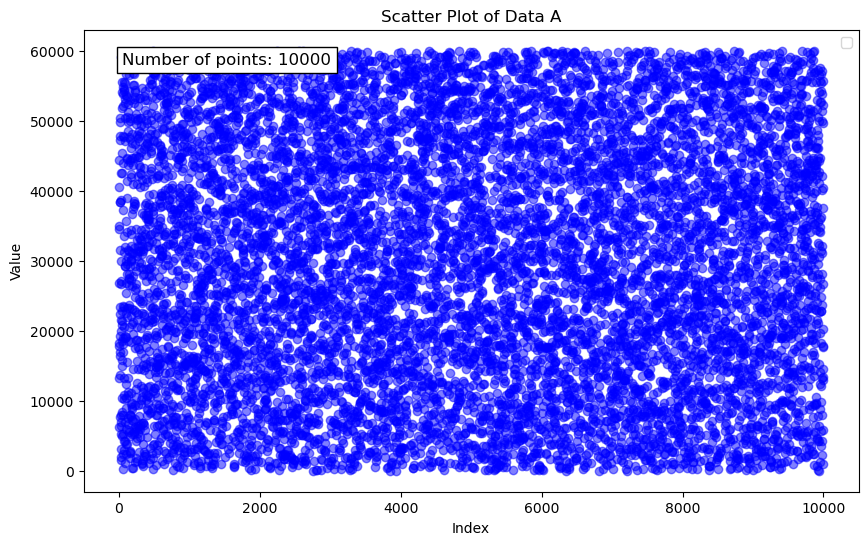

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 1)


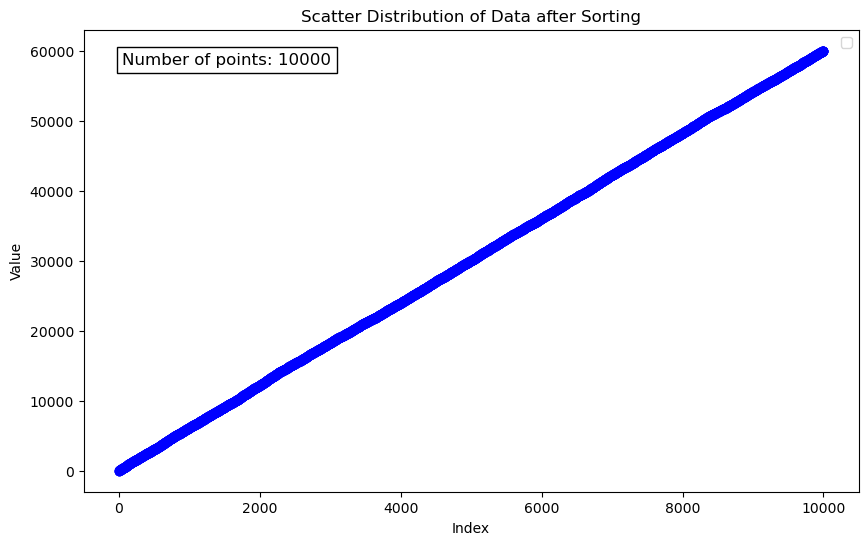

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.10934562493149812, 0.09874053654166495, 0.11648442217377993, 0.10690116621289214, 0.11069177417990014, 0.11014202102761478, 0.11826351084209138, 0.1097465491689666, 0.1062281282680322, 0.12748834738397208]
Error u of fuhe active learning(LHS sampling): 1.114032e-01
[0.028020179459096416, 0.025992423104280345, 0.03014973537701582, 0.026838055832942118, 0.028117122150620618, 0.02821452383882069, 0.030170449859698058, 0.027829037327636676, 0.026587168698949396, 0.033652723524789825]
MAE of fuhe active learning(LHS sampling): 2.855714e-02
[0.0032974043782657498, 0.002707931119532613, 0.0037369763218885006, 0.003158138189415402, 0.003366707391053878, 0.003348895530913328, 0.0038809808287114055, 0.0033120681900990433, 0.0031234858987023713, 0.004540963169840556]
MSE of fuhe active learning(LHS sampling): 3.447355e-03


[0.10934562493149812, 0.09874053654166495, 0.11648442217377993, 0.10690116621289214, 0.11069177417990014, 0.11014202102761478, 0.11826351084209138, 0.1097465491689666, 0.1062281282680322, 0.12748834738397208]
mean Error u: 1.114032e-01
Variance Error u: 5.480822e-05


/tmp/ipykernel_1629863/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


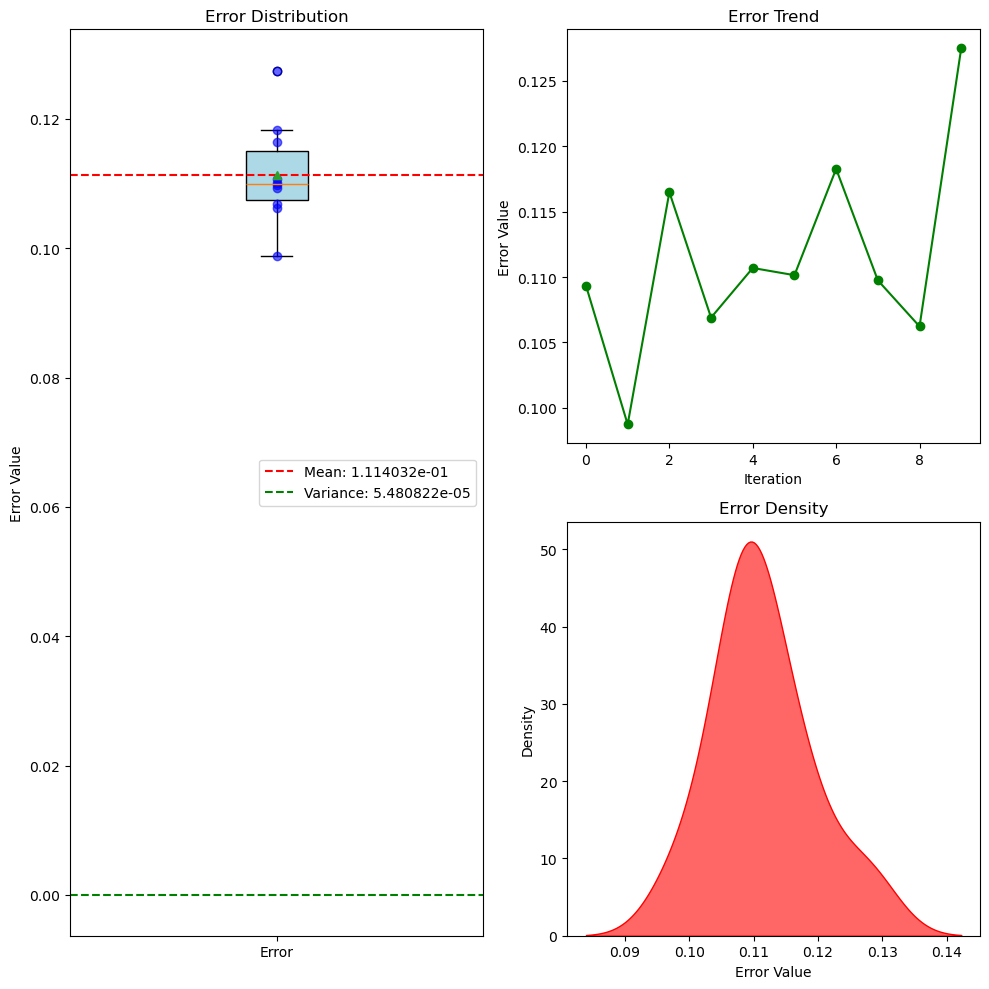

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.028020179459096416, 0.025992423104280345, 0.03014973537701582, 0.026838055832942118, 0.028117122150620618, 0.02821452383882069, 0.030170449859698058, 0.027829037327636676, 0.026587168698949396, 0.033652723524789825]
mean MAE: 2.855714e-02
Variance MAE: 4.564737e-06


/tmp/ipykernel_1629863/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


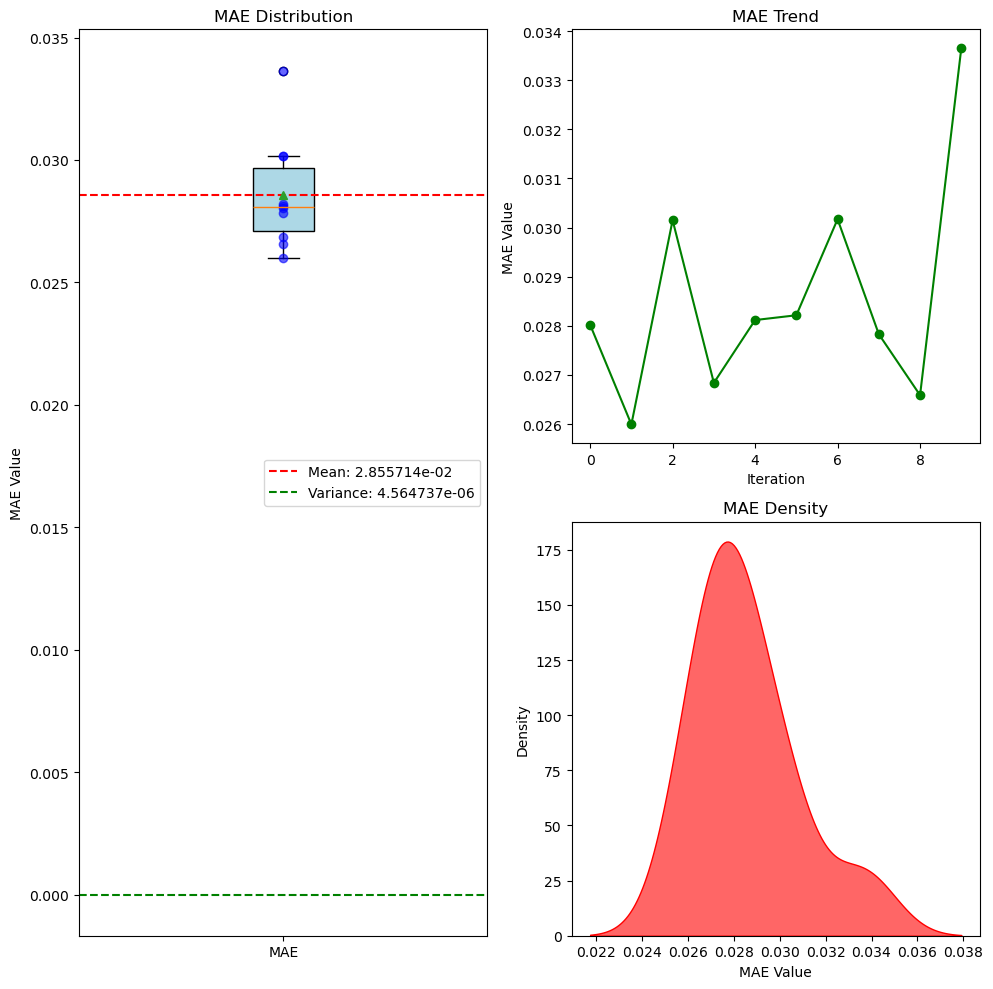

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0032974043782657498, 0.002707931119532613, 0.0037369763218885006, 0.003158138189415402, 0.003366707391053878, 0.003348895530913328, 0.0038809808287114055, 0.0033120681900990433, 0.0031234858987023713, 0.004540963169840556]
mean MSE: 3.447355e-03
Variance MSE: 2.260162e-07


/tmp/ipykernel_1629863/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


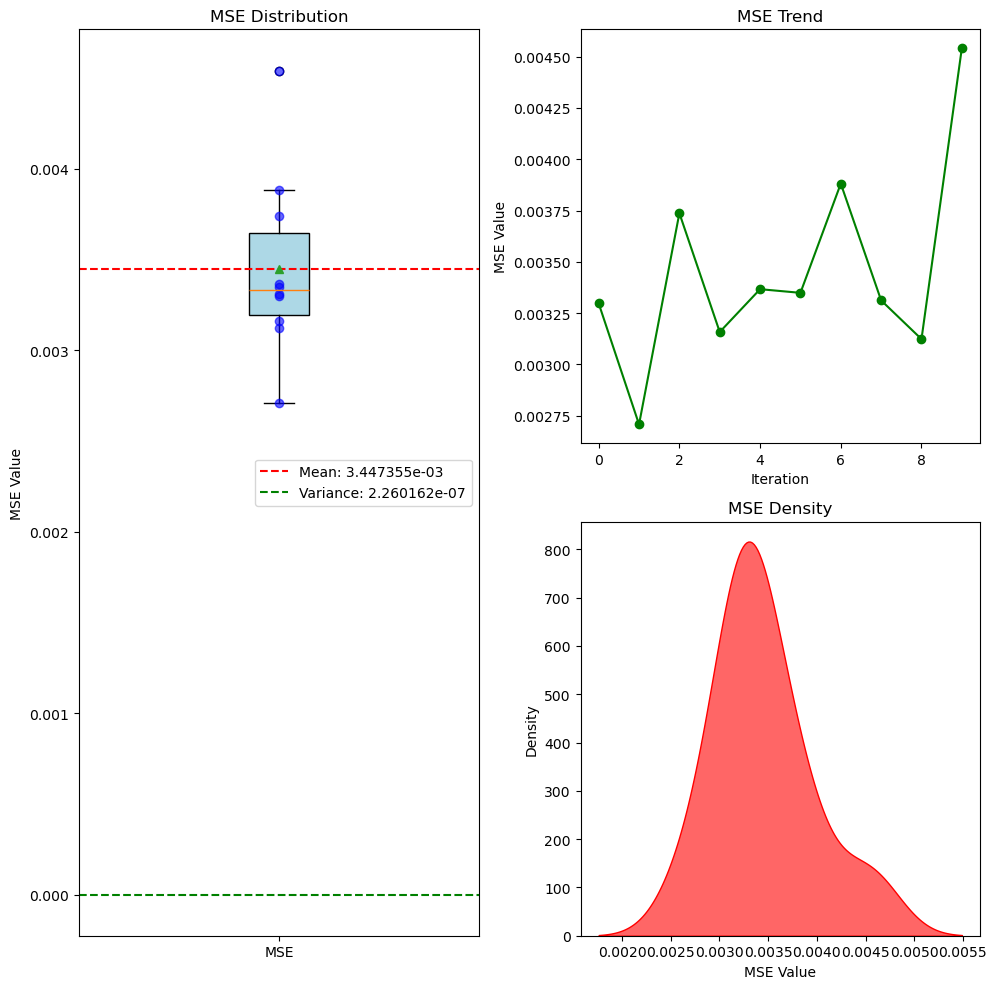

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.08172014, 440.956, 3592.7021, 0.0013722721, 2.521954, 0.0031478577, 0.003057261, 0.0013424057, 0.30642053, 2180.7188]
mean CHAOS: 6.217296e+02
Variance CHAOS: 1.399202e+06


/tmp/ipykernel_1629863/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


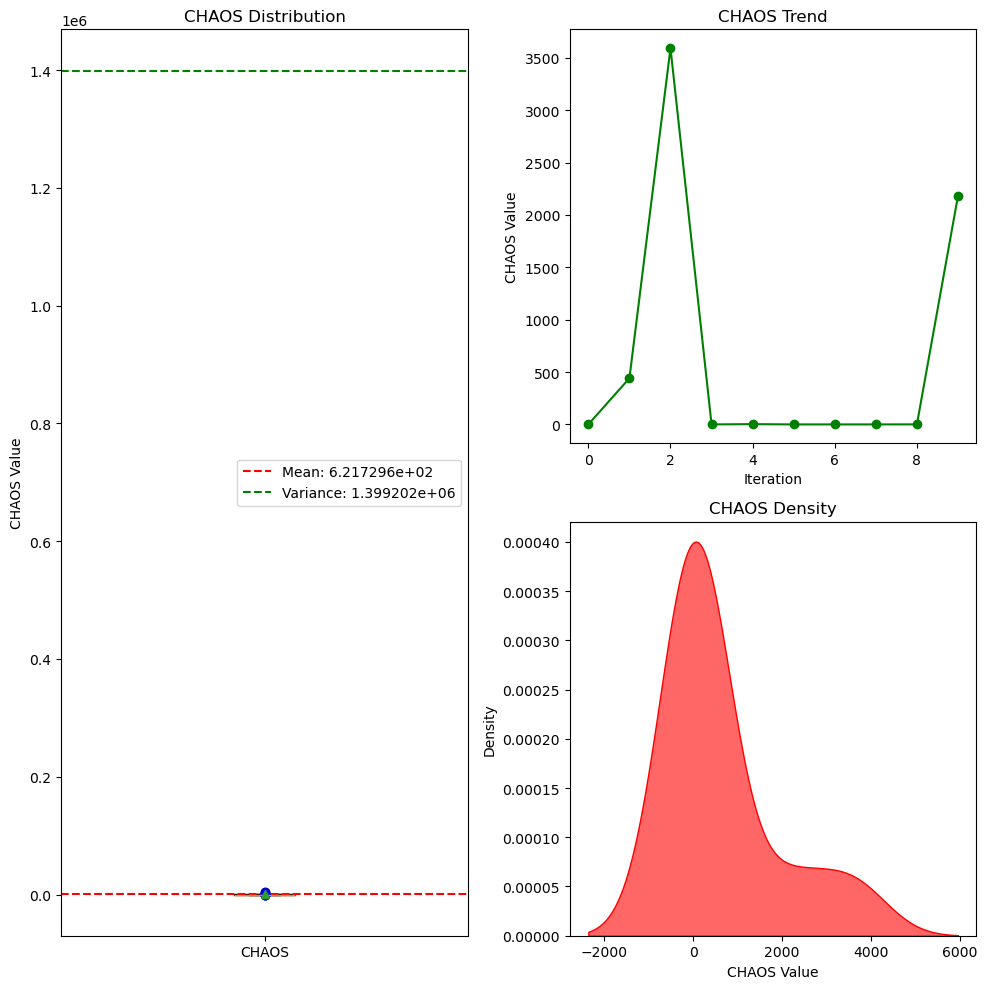

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.6567627e-08, 3.9441073e-08, 3.821987e-08, 3.982026e-08, 3.860687e-08, 3.7920394e-08, 3.8234667e-08, 3.4912567e-08, 3.449253e-08, 4.145136e-08]
mean RESIDUAL: 3.796672e-08
Variance RESIDUAL: 4.165519e-18


/tmp/ipykernel_1629863/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


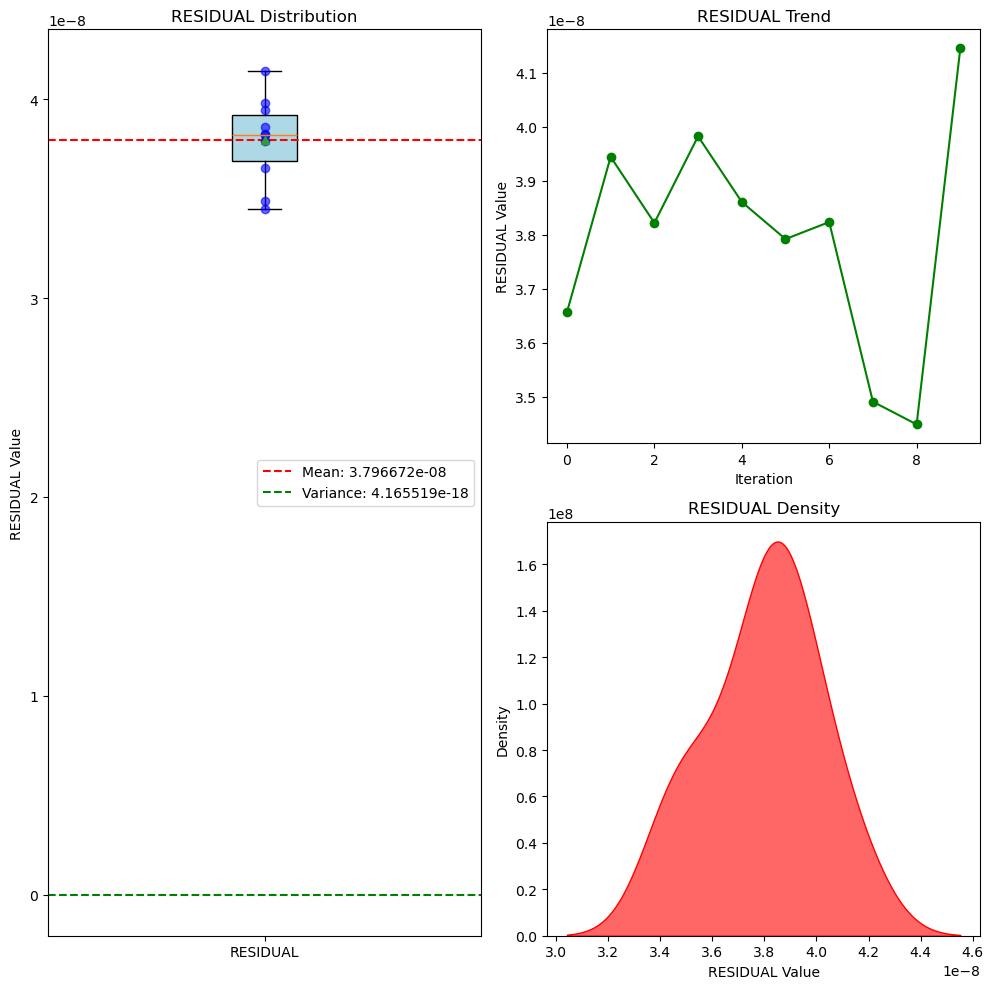

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

80000
[1.9815606e-01 1.6977435e-01 1.4300203e-01 ... 1.4151361e-09 1.4151190e-09
 1.4151025e-09]


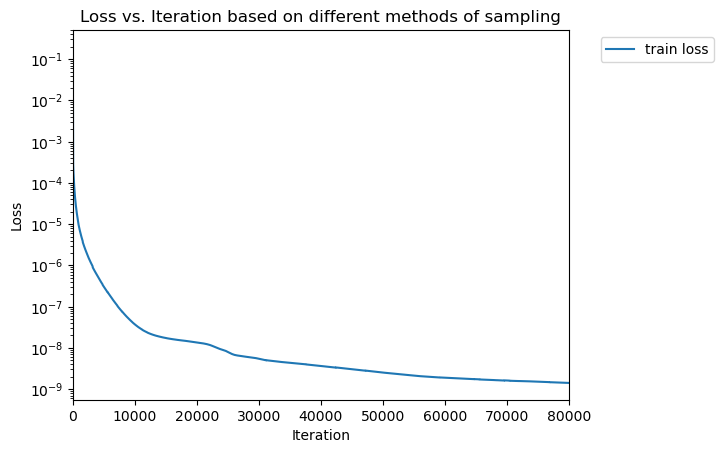

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

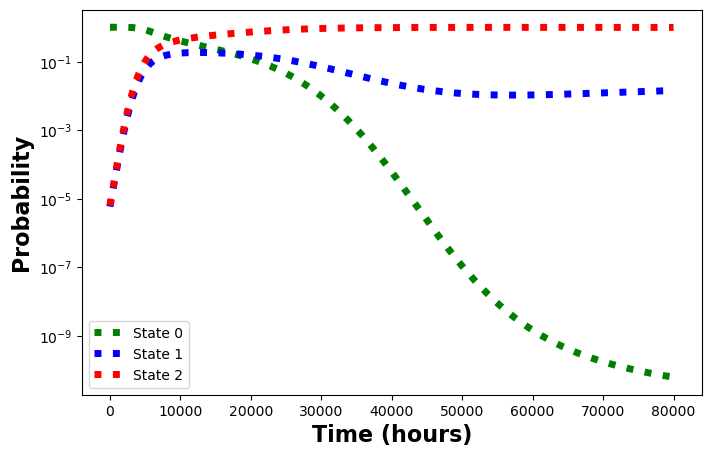

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

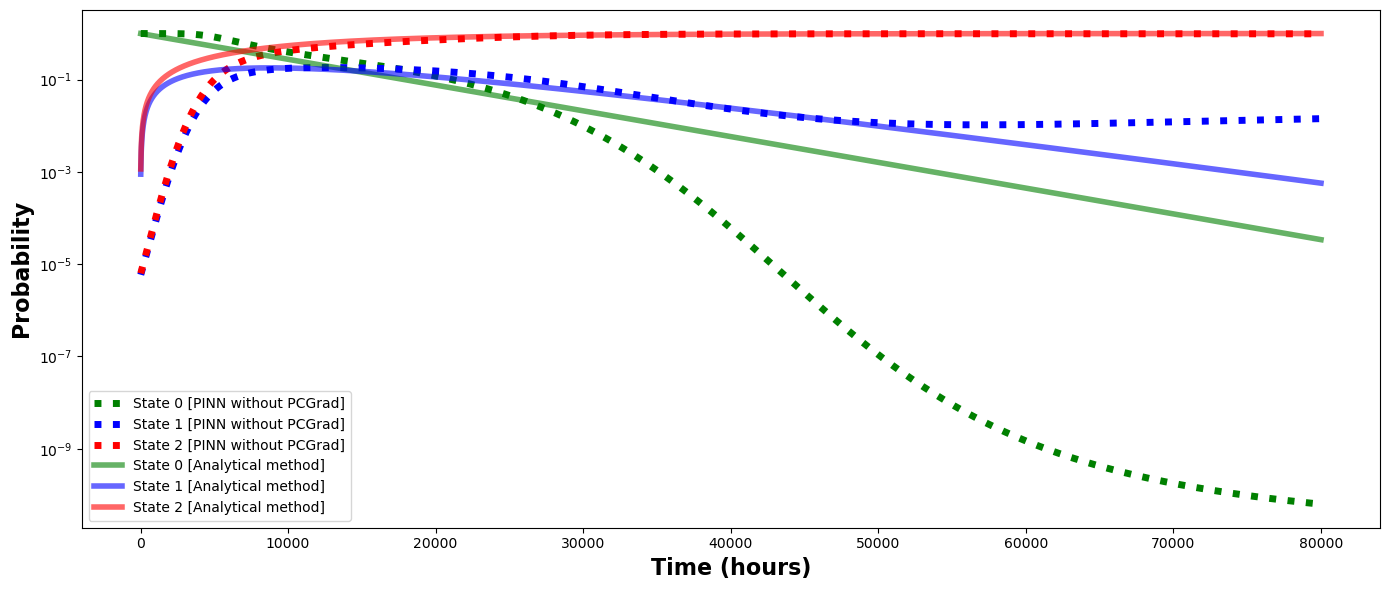

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999988  0.000006  0.000006
1  0.999987  0.000006  0.000007
2  0.999987  0.000006  0.000007
3  0.999986  0.000007  0.000007
4  0.999985  0.000007  0.000008
           state_0   state_1   state_2
4995  6.308044e-11  0.014265  0.985735
4996  6.300531e-11  0.014269  0.985731
4997  6.292966e-11  0.014272  0.985728
4998  6.285471e-11  0.014276  0.985725
4999  6.277961e-11  0.014279  0.985721


In [21]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_eigenvectors['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_eigenvectors['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.06470593638475942
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0813699994685067
RMSE between PINN without PCGrad and the analytical solution after 60000 is 0.014767029509484811


### 计算混沌度和残差

In [24]:
x_star.shape

(5000, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(1000, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[1.0934925  1.0933024  1.0930904  ... 0.26786232 0.26786554 0.26786932]
(5000,)
2314.1274


In [26]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[-7.2759576e-11  2.1827873e-11 -2.1827873e-11 ...  5.6843419e-13
 -1.3642421e-12  2.2737368e-13]
(5000,)
-5.329852e-10
